<h1><center>MARÍA VICTORIA SANTANA RODRÍGUEZ </center></h1>
<font color="darkblue">
<h3> <center>TFM</center> </h3>
<h3> <center>Julio-Agosto 2024</center> </h3>

<font color="darkblue"><h2> Previsión_OPERACIONES</h2> 

**Objetivo**: Hacer previsiones de los datos que se tiene de operaciones.

In [1]:
# Se importan los paquetes y librerías necesarias
import pandas as pd
import os
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import itertools
import random
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
from pmdarima import auto_arima
import joblib
import re
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR

### A. Carga del fichero

Se carga el fichero que previamente ha sido limpiado y procesado

In [2]:
# Ruta en la que se encuentra el fichero
Ruta_Operaciones_Unico = './Ficheros_unico/O_Unico.csv'

# Se carga el DataFrame desde el archivo CSV
Operaciones_merge_pivotar = pd.read_csv(Ruta_Operaciones_Unico, parse_dates=['Fecha'])

# Se comprueba que se carga correctamente
print(Operaciones_merge_pivotar.head())

                Aeropuerto_Base             Tipo      Fecha  Valor
0                      A CORUÑA  O_Total_Llegada 2004-01-01    461
1  ADOLFO SUÁREZ MADRID-BARAJAS  O_Total_Llegada 2004-01-01  15626
2                      ALBACETE  O_Total_Llegada 2004-01-01     33
3   ALICANTE-ELCHE MIGUEL HDEZ.  O_Total_Llegada 2004-01-01   2271
4                       ALMERÍA  O_Total_Llegada 2004-01-01    517


In [3]:
# Se modifica el nombre del fichero
Operaciones_Unico = Operaciones_merge_pivotar

# Se comprueba que tipo de dato hay en cada columna y que es correcto
print(Operaciones_Unico.dtypes)

# Asegurarse de que la fecha sea el índice para el análisis de series temporales
Operaciones_Unico.set_index('Fecha', inplace=True)

# Se comprueba que se carga correctamente
print(Operaciones_Unico.head())

Aeropuerto_Base            object
Tipo                       object
Fecha              datetime64[ns]
Valor                       int64
dtype: object
                         Aeropuerto_Base             Tipo  Valor
Fecha                                                           
2004-01-01                      A CORUÑA  O_Total_Llegada    461
2004-01-01  ADOLFO SUÁREZ MADRID-BARAJAS  O_Total_Llegada  15626
2004-01-01                      ALBACETE  O_Total_Llegada     33
2004-01-01   ALICANTE-ELCHE MIGUEL HDEZ.  O_Total_Llegada   2271
2004-01-01                       ALMERÍA  O_Total_Llegada    517


### B. Predicciones

En este apartado se trata de hacer las predicciones de los datos estudiados, para ello se van a probar distintos modelos hasta encontrar el que mejores resultados arroje.

In [4]:
import warnings
warnings.filterwarnings("ignore")

**1. Modelo ARIMA**

Se prueba un modelo Arima, con unos parámetros aleatorios, muy básicos de (1,1,2) para ver que resultados se obtienen, y partir de esta base. 

In [5]:
# Se crea un diccionario para almacenar las predicciones
Dicc_Predicciones_Operaciones = {}

# Se obtienen todos los aeropurtos y tipos únicos
Aeropuertos = Operaciones_Unico['Aeropuerto_Base'].unique()
Tipos_Operacion = Operaciones_Unico['Tipo'].unique()

# Se itera sobre cada aeropuerto y tipo
for Aeropuerto in Aeropuertos:
    for Operacion in Tipos_Operacion:
        # Se filtra cada aeropuerto y tipo de operación para los datos originales "reales"
        Datos_Reales_Operacion = Operaciones_Unico[(Operaciones_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                                   (Operaciones_Unico['Tipo'] == Operacion)]
        
        # Se comprueba que está ordenado cronologicamente
        Datos_Reales_Operacion = Datos_Reales_Operacion.sort_index()

        # Se entrena el modelo ARIMA en los datos históricos
        try:
            model_arima = ARIMA(Datos_Reales_Operacion['Valor'], order=(1, 1, 2))
            model_fit_arima = model_arima.fit()

            # Se realizan predicciones hasta los valores que ya se tienen, junio 2024 
            Predicciones_Originales = model_fit_arima.predict(start=Datos_Reales_Operacion.index[0], end=Datos_Reales_Operacion.index[-1])

           # Se realizan predicciones para fechas de las que no se tiene valores que ya se tienen, a partir de junio 2024 
            Predicciones_Futuras = model_fit_arima.forecast(steps=12)

            # Se almacenan las predicciones en el diccionario
            Dicc_Predicciones_Operaciones[(Aeropuerto, Operacion)] = (Predicciones_Originales, Predicciones_Futuras, Datos_Reales_Operacion.index)
        
        except Exception as e:
            print(f"Error al entrenar el modelo para {Aeropuerto}, {Operacion}: {e}")

**1-a. Almacenar las predicciones**

In [6]:
# Se crea un DataFrame para almacenar todas las predicciones
Predicciones_Operaciones = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'Fecha', 'Prediccion'])

for (Aeropuerto, Operacion), (Predicciones_Originales, Predicciones_Futuras, Fechas_Reales) in Dicc_Predicciones_Operaciones.items():
    # Se guardan en un DataFrame temporal para las predicciones de los datos orginales "reales"
    Predicciones_Originales = pd.DataFrame({
        'Aeropuerto_Base': Aeropuerto,
        'Tipo': Operacion,
        'Fecha': Fechas_Reales,
        'Prediccion': Predicciones_Originales
    })

    # Se guardan en un DataFrame temporal para las predicciones de fechas futuras
    Fechas_Futuras = pd.date_range(start=Fechas_Reales[-1] + pd.offsets.MonthBegin(1), periods=len(Predicciones_Futuras), freq='MS')
    Predicciones_Futuras = pd.DataFrame({
        'Aeropuerto_Base': Aeropuerto,
        'Tipo': Operacion,
        'Fecha': Fechas_Futuras,
        'Prediccion': Predicciones_Futuras
    })

    # Se concatenan ambas predicciones y se guardan en un dataframe único
    Predicciones_Operaciones = pd.concat([Predicciones_Operaciones, Predicciones_Originales, Predicciones_Futuras], ignore_index=True)

In [7]:
# Se crea un dataframe para poder comparar las predicciones
Comparacion_Total_Todos_Aeropuertos = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'Fecha', 'Valor Real', 'Prediccion'])

for (Aeropuerto, Operacion), (Predicciones_Originales, Predicciones_Futuras, Fechas_Reales) in Dicc_Predicciones_Operaciones.items():
    # Se crea un DataFrame temporal para las predicciones históricas con los valores originales
    Tem_Predicciones_Historicas = pd.DataFrame({
        'Aeropuerto_Base': Aeropuerto,
        'Tipo': Operacion,
        'Fecha': Fechas_Reales,
        'Valor Real': Operaciones_Unico[(Operaciones_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                        (Operaciones_Unico['Tipo'] == Operacion)]['Valor'],
        'Prediccion': Predicciones_Originales
    })

    # Se crea un DataFrame para las predicciones futuras
    Fechas_Futuras = pd.date_range(start=Fechas_Reales[-1] + pd.offsets.MonthBegin(1), periods=len(Predicciones_Futuras), freq='MS')
    Temp_Predicciones_Futuras = pd.DataFrame({
        'Aeropuerto_Base': Aeropuerto,
        'Tipo': Operacion,
        'Fecha': Fechas_Futuras,
        'Valor Real': [None] * len(Predicciones_Futuras),
        'Prediccion': Predicciones_Futuras
    })

    # Se concatena los dos dataframe (históricos y futuros)
    Comparacion_Total_Todos_Aeropuertos = pd.concat([Comparacion_Total_Todos_Aeropuertos, Tem_Predicciones_Historicas, Temp_Predicciones_Futuras], ignore_index=True)

# Se muestran las últimas filas para ver los valores reales y predicciones
print(Comparacion_Total_Todos_Aeropuertos.tail(20))

        Aeropuerto_Base               Tipo      Fecha Valor Real  Prediccion
50548  MURCIA COMBINADO  O_Nacional_Salida 2023-11-01         49   48.545418
50549  MURCIA COMBINADO  O_Nacional_Salida 2023-12-01         50   54.268446
50550  MURCIA COMBINADO  O_Nacional_Salida 2024-01-01         52   52.552600
50551  MURCIA COMBINADO  O_Nacional_Salida 2024-02-01         50   54.365604
50552  MURCIA COMBINADO  O_Nacional_Salida 2024-03-01         65   51.863032
50553  MURCIA COMBINADO  O_Nacional_Salida 2024-04-01         57   64.486819
50554  MURCIA COMBINADO  O_Nacional_Salida 2024-05-01        109   54.108611
50555  MURCIA COMBINADO  O_Nacional_Salida 2024-06-01         99   99.663516
50556  MURCIA COMBINADO  O_Nacional_Salida 2024-07-01       None   78.409959
50557  MURCIA COMBINADO  O_Nacional_Salida 2024-08-01       None   71.328860
50558  MURCIA COMBINADO  O_Nacional_Salida 2024-09-01       None   68.821219
50559  MURCIA COMBINADO  O_Nacional_Salida 2024-10-01       None   67.933185

**1-b. Visualizar predicciones**

**Operaciones de llegada**, se visualizan las predicciones para un aeropuerto en particular que se guardan en un mismo dataframe, los datos reales con las predicciones de los rangos de fecha de los datos que se tienen junto con un periodo de 12 meses adicionales

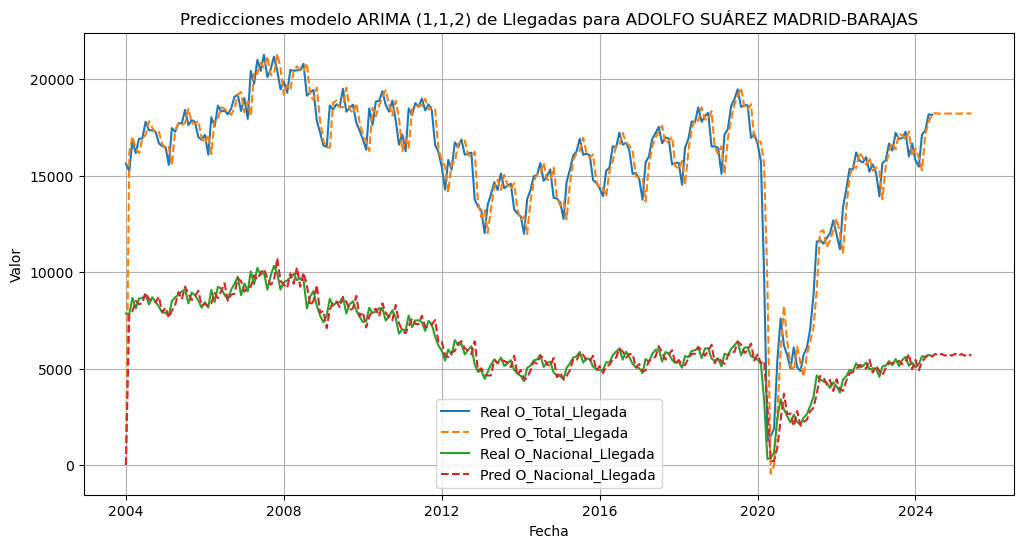

In [86]:
# Se visualizan las predicciones para un aeropuerto específico
Aeropuerto_Prediccion = 'ADOLFO SUÁREZ MADRID-BARAJAS'

# Se filtran los tipos de operación disponibles para el aeropuerto seleccionado
Tipos_Operacion = Operaciones_Unico[Operaciones_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion]['Tipo'].unique()

# Se filtran los tipos de operación para Llegada
Tipos_Llegada = [tipo for tipo in Tipos_Operacion if 'Llegada' in tipo]


# Gráfico para operaciones de Llegada
plt.figure(figsize=(12, 6))
for Tipo_Operacion_Prediccion in Tipos_Llegada:
    # Se filtran los datos reales para el tipo de operación
    Datos_Reales_Operacion = Operaciones_Unico[(Operaciones_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                               (Operaciones_Unico['Tipo'] == Tipo_Operacion_Prediccion)]
    
    # Se filtran las predicciones para el tipo de operación
    Datos_Predicciones_Operacion = Predicciones_Operaciones[(Predicciones_Operaciones['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                                            (Predicciones_Operaciones['Tipo'] == Tipo_Operacion_Prediccion)]
    
    # Se añaden las series reales y predicciones al gráfico
    plt.plot(Datos_Reales_Operacion.index, Datos_Reales_Operacion['Valor'], label=f'Real {Tipo_Operacion_Prediccion}')
    plt.plot(Datos_Predicciones_Operacion['Fecha'], Datos_Predicciones_Operacion['Prediccion'], linestyle='--', label=f'Pred {Tipo_Operacion_Prediccion}')

# Se configura el gráfico
plt.title(f'Predicciones modelo ARIMA (1,1,2) de Llegadas para {Aeropuerto_Prediccion}')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

**Operaciones de salida**, se visualizan las predicciones, para un aeropuerto en particular que se guardan en un mismo dataframe, los datos reales con las predicciones de los rangos de fecha de los datos que se tienen junto con un periodo de 12 meses adicionales.

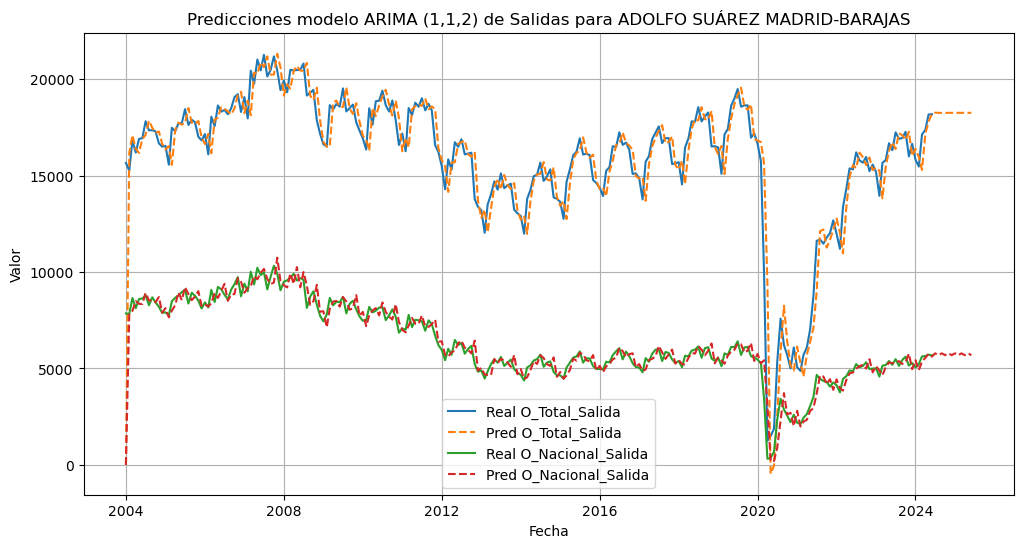

In [87]:
# Se visualizan las predicciones para un aeropuerto específico
Aeropuerto_Prediccion = 'ADOLFO SUÁREZ MADRID-BARAJAS'

# Se filtran los tipos de operación disponibles para el aeropuerto seleccionado
Tipos_Operacion = Operaciones_Unico[Operaciones_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion]['Tipo'].unique()

# Se filtran los tipos de operación para salida
Tipos_Salida = [tipo for tipo in Tipos_Operacion if 'Salida' in tipo]

# Gráfico para operaciones de Salida
plt.figure(figsize=(12, 6))
for Tipo_Operacion_Prediccion in Tipos_Salida:
    # Se filtran los datos reales para el tipo de operación
    Datos_reales_Operacion = Operaciones_Unico[(Operaciones_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                               (Operaciones_Unico['Tipo'] == Tipo_Operacion_Prediccion)]
    
    # Se filtran las predicciones para el tipo de operación
    Datos_Predicciones_Operacion = Predicciones_Operaciones[(Predicciones_Operaciones['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                                            (Predicciones_Operaciones['Tipo'] == Tipo_Operacion_Prediccion)]
    
    # Se añaden las series reales y predicciones al gráfico
    plt.plot(Datos_reales_Operacion.index, Datos_reales_Operacion['Valor'], label=f'Real {Tipo_Operacion_Prediccion}')
    plt.plot(Datos_Predicciones_Operacion['Fecha'], Datos_Predicciones_Operacion['Prediccion'], linestyle='--', label=f'Pred {Tipo_Operacion_Prediccion}')

# Se configura el gráfico
plt.title(f'Predicciones modelo ARIMA (1,1,2) de Salidas para {Aeropuerto_Prediccion}')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

**1-c. Métricas de Error**

In [10]:
# Se crea un DataFrame para almacenar las métricas de error
Metricas_Error_Operaciones = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'MAE', 'RMSE', 'MAPE'])

# Se itera sobre las combinaciones de aeropuerto y tipo de operación
for (Aeropuerto, Operacion), (Predicciones_Historicas, _, Fechas_Reales) in Dicc_Predicciones_Operaciones.items():
    # Se obtienen los valores reales
    Valores_Reales_Operacion = Operaciones_Unico[(Operaciones_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                       (Operaciones_Unico['Tipo'] == Operacion)]['Valor']
    
    # Se calculan las métricas de error si hay valores reales para comparar
    if len(Valores_Reales_Operacion) == len(Predicciones_Historicas):
        # MAE - Error Absoluto Medio
        mae = mean_absolute_error(Valores_Reales_Operacion, Predicciones_Historicas)
        # RMSE - Error Cuatrático Medio
        rmse = np.sqrt(mean_squared_error(Valores_Reales_Operacion, Predicciones_Historicas))
        # MAPE - Error Porcentual Absoluto Medio
        mape = np.mean(np.abs((Valores_Reales_Operacion - Predicciones_Historicas) / Valores_Reales_Operacion)) * 100

        # Se almacenan las métricas en el DataFrame
        Temp_Metricas_Error = pd.DataFrame({
            'Aeropuerto_Base': [Aeropuerto],
            'Tipo': [Operacion],
            'MAE': [mae],
            'RMSE': [rmse],
            'MAPE': [mape]
        })
       
        # Se concatenan las métricas de error
        Metricas_Error_Operaciones = pd.concat([Metricas_Error_Operaciones, Temp_Metricas_Error], ignore_index=True) 

# Se muestran las métricas
print(Metricas_Error_Operaciones)

                  Aeropuerto_Base                Tipo         MAE  \
0                        A CORUÑA     O_Total_Llegada   61.042625   
1                        A CORUÑA  O_Nacional_Llegada   58.771817   
2                        A CORUÑA      O_Total_Salida   60.313903   
3                        A CORUÑA   O_Nacional_Salida   57.996171   
4    ADOLFO SUÁREZ MADRID-BARAJAS     O_Total_Llegada  793.173932   
..                            ...                 ...         ...   
191         ALGECIRAS /HELIPUERTO   O_Nacional_Salida    9.757440   
192              MURCIA COMBINADO     O_Total_Llegada   74.612386   
193              MURCIA COMBINADO  O_Nacional_Llegada   25.608065   
194              MURCIA COMBINADO      O_Total_Salida   74.753579   
195              MURCIA COMBINADO   O_Nacional_Salida   25.936761   

            RMSE       MAPE  
0      82.075521  12.895350  
1      78.719716  13.629782  
2      81.473606  12.782031  
3      77.846884  13.481423  
4    1487.027566   8.

Se calculan los datos promedios de los errores para así, tener una visión de conjunto

In [11]:
# Se calculan las métricas medias para este modelo 
MAE_promedio = Metricas_Error_Operaciones['MAE'].mean()
RMSE_promedio = Metricas_Error_Operaciones['RMSE'].mean()
MAPE_promedio= Metricas_Error_Operaciones['MAPE'].mean()

# Se muestran los resultados ARIMA (1,1,2)
print(f"MAE Promedio ARIMA (1,1,2): {MAE_promedio}")
print(f"RMSE Promedio ARIMA (1,1,2): {RMSE_promedio}")
print(f"MAPE Promedio ARIMA (1,1,2): {MAPE_promedio}%")

MAE Promedio ARIMA (1,1,2): 137.59102508296962
RMSE Promedio ARIMA (1,1,2): 204.34110980495416
MAPE Promedio ARIMA (1,1,2): inf%


Aunque los datos no están del todo mal, las predicciones están muy alineadas con respecto a los datos reales, se va a probar a reentrenar el modelo modificando los hiperparámetros, hay que tener en cuenta que hay aeropuertos que no tienen datos, que su valor es 0, para ciertos periodos ya que durante este tiempo no estaban operativos, o dejaron de estarlo, y también existen diferenciencias entre los aeropuertos principales (Madrid-Barajs, Barcelona, Málaga, Palma de Mallorca y Gran Canaria) respecto del resto.

**2. Modelo Grid Search - ARIMA - 1 intento**

El segundo modelo es usar un Grid Search, para optimizar los hiperparámetros del modelo anterior, en teoría deberían de mejorar los resultados, ya que se están buscando los mejores para este conjunto de datos, y que así ofrezca un mejor rendimiento del mismo.

In [12]:
# Se definen los parámetros p, d, q
p = d = q = range(0, 4)  # Esto probará valores de 0 a 3 para p, d, q
pdq = list(itertools.product(p, d, q))

# Se almcenan los mejores resultados
best_aic = float('inf')
best_params = None

# Se itera sobre cada combinación de parámetros
for params in pdq:
    try:
        # Se entrena el modelo ARIMA con los parámetros actuales
        model_arima = ARIMA(Datos_Reales_Operacion['Valor'], order=params)
        model_fit_arima = model_arima.fit()
        
        # Se calcular el AIC
        aic = model_fit_arima.aic
        
        # Si el AIC actual es mejor que el anterior, actualizar los mejores parámetros
        if aic < best_aic:
            best_aic = aic
            best_params = params
            
    except Exception as e:
        print(f"Error con los parámetros {params}: {e}")
        continue

print(f'Mejor conjunto de parámetros: {best_params} con AIC: {best_aic}')

Mejor conjunto de parámetros: (3, 1, 3) con AIC: 2503.2486913479283


El mejor conjunto de parámetros con Grind Search que se obtiene para los datos de operaciones es el (3, 1, 3)

- p (componente autorregresivo)=3
- d (componente integrado) =1
- q (media móvil) =3

**2-a. Se reentrena el modelo con los parámetros obtenidos, Modelo Grid Search - ARIMA - 1 intento**

In [13]:
# Se crea un diccionario para almacenar las predicciones
Dicc_Predicciones_Operaciones_GS = {}

# Se obtienen todos los aeropurtos y tipos únicos
Aeropuertos = Operaciones_Unico['Aeropuerto_Base'].unique()
Tipos_Operacion = Operaciones_Unico['Tipo'].unique()

# Se itera sobre cada aeropuerto y tipo
for Aeropuerto in Aeropuertos:
    for Operacion in Tipos_Operacion:
        # Se filtra cada aeropuerto y tipo de operación para los datos originales "reales"
        Datos_Reales_Operacion_GS = Operaciones_Unico[(Operaciones_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                                   (Operaciones_Unico['Tipo'] == Operacion)]
        
        # Se comprueba que está ordenado cronologicamente
        Datos_Reales_Operacion_GS = Datos_Reales_Operacion_GS.sort_index()

        # Se entrena el modelo ARIMA en los datos históricos
        try:
            model_arima_GS = ARIMA(Datos_Reales_Operacion_GS['Valor'], order=(3, 1, 3))
            model_fit_arima_GS = model_arima_GS.fit()

            # Se realizan predicciones hasta los valores que ya se tienen, junio 2024 
            Predicciones_Originales_GS = model_fit_arima_GS.predict(start=Datos_Reales_Operacion_GS.index[0], end=Datos_Reales_Operacion_GS.index[-1])

           # Se realizan predicciones para fechas de las que no se tiene valores que ya se tienen, a partir de junio 2024 
            Predicciones_Futuras_GS = model_fit_arima_GS.forecast(steps=12)

            # Se almacenan las predicciones en el diccionario
            Dicc_Predicciones_Operaciones_GS[(Aeropuerto, Operacion)] = (Predicciones_Originales_GS, Predicciones_Futuras_GS, Datos_Reales_Operacion_GS.index)
        
        except Exception as e:
            print(f"Error al entrenar el modelo para {Aeropuerto}, {Operacion}: {e}")

**2-b. Dataframe en el que se guardan las predicciones y los datos reales**

In [14]:
# Se crea un dataframe para poder comparar las predicciones
Comparacion_Total_Todos_Aeropuertos_GS = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'Fecha', 'Valor Real', 'Prediccion'])

for (Aeropuerto, Operacion), (Predicciones_Originales_GS, Predicciones_Futuras_GS, Fechas_Reales) in Dicc_Predicciones_Operaciones_GS.items():
    # Se crea un DataFrame temporal para las predicciones históricas con los valores originales
    Tem_Predicciones_Historicas_GS = pd.DataFrame({
        'Aeropuerto_Base': Aeropuerto,
        'Tipo': Operacion,
        'Fecha': Fechas_Reales,
        'Valor Real': Operaciones_Unico[(Operaciones_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                        (Operaciones_Unico['Tipo'] == Operacion)]['Valor'],
        'Prediccion': Predicciones_Originales_GS
    })

    # Se crea un DataFrame para las predicciones futuras
    Fechas_Futuras = pd.date_range(start=Fechas_Reales[-1] + pd.offsets.MonthBegin(1), periods=len(Predicciones_Futuras_GS), freq='MS')
    Temp_Predicciones_Futuras_GS = pd.DataFrame({
        'Aeropuerto_Base': Aeropuerto,
        'Tipo': Operacion,
        'Fecha': Fechas_Futuras,
        'Valor Real': [None] * len(Predicciones_Futuras_GS),
        'Prediccion': Predicciones_Futuras_GS
    })

    # Se concatena los dos dataframe (históricos y futuros)
    Comparacion_Total_Todos_Aeropuertos_GS = pd.concat([Comparacion_Total_Todos_Aeropuertos_GS, Tem_Predicciones_Historicas_GS, Temp_Predicciones_Futuras_GS], ignore_index=True)

# Se muestran las últimas filas para ver los valores reales y predicciones
print(Comparacion_Total_Todos_Aeropuertos_GS.tail(20))

        Aeropuerto_Base               Tipo      Fecha Valor Real  Prediccion
50548  MURCIA COMBINADO  O_Nacional_Salida 2023-11-01         49   36.930056
50549  MURCIA COMBINADO  O_Nacional_Salida 2023-12-01         50   44.738096
50550  MURCIA COMBINADO  O_Nacional_Salida 2024-01-01         52   44.981707
50551  MURCIA COMBINADO  O_Nacional_Salida 2024-02-01         50   56.540625
50552  MURCIA COMBINADO  O_Nacional_Salida 2024-03-01         65   53.263966
50553  MURCIA COMBINADO  O_Nacional_Salida 2024-04-01         57   73.146377
50554  MURCIA COMBINADO  O_Nacional_Salida 2024-05-01        109   60.795870
50555  MURCIA COMBINADO  O_Nacional_Salida 2024-06-01         99  107.298001
50556  MURCIA COMBINADO  O_Nacional_Salida 2024-07-01       None   81.415024
50557  MURCIA COMBINADO  O_Nacional_Salida 2024-08-01       None   80.569094
50558  MURCIA COMBINADO  O_Nacional_Salida 2024-09-01       None   67.635778
50559  MURCIA COMBINADO  O_Nacional_Salida 2024-10-01       None   71.833783

**2-c.Visualización de las predicciones** 

In [78]:
# Se crea un DataFrame para almacenar todas las predicciones
Predicciones_Operaciones_GS = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'Fecha', 'Prediccion'])

for (Aeropuerto, Operacion), (Predicciones_Originales_GS, Predicciones_Futuras_GS, Fechas_Reales) in Dicc_Predicciones_Operaciones_GS.items():
    # Se guardan en un DataFrame temporal para las predicciones de los datos orginales "reales"
    Tem_Predicciones_Historicas_GS = pd.DataFrame({
        'Aeropuerto_Base': Aeropuerto,
        'Tipo': Operacion,
        'Fecha': Fechas_Reales,
        'Prediccion': Predicciones_Originales_GS
    })

    # Se guardan en un DataFrame temporal para las predicciones de fechas futuras
    Fechas_Futuras = pd.date_range(start=Fechas_Reales[-1] + pd.offsets.MonthBegin(1), periods=len(Predicciones_Futuras_GS), freq='MS')
    Temp_Predicciones_Futuras_GS = pd.DataFrame({
        'Aeropuerto_Base': Aeropuerto,
        'Tipo': Operacion,
        'Fecha': Fechas_Futuras,
        'Prediccion': Predicciones_Futuras_GS
    })

    # Se concatenan ambas predicciones y se guardan en un dataframe único
    Predicciones_Operaciones_GS = pd.concat([Predicciones_Operaciones_GS, Tem_Predicciones_Historicas_GS, Temp_Predicciones_Futuras_GS], ignore_index=True)

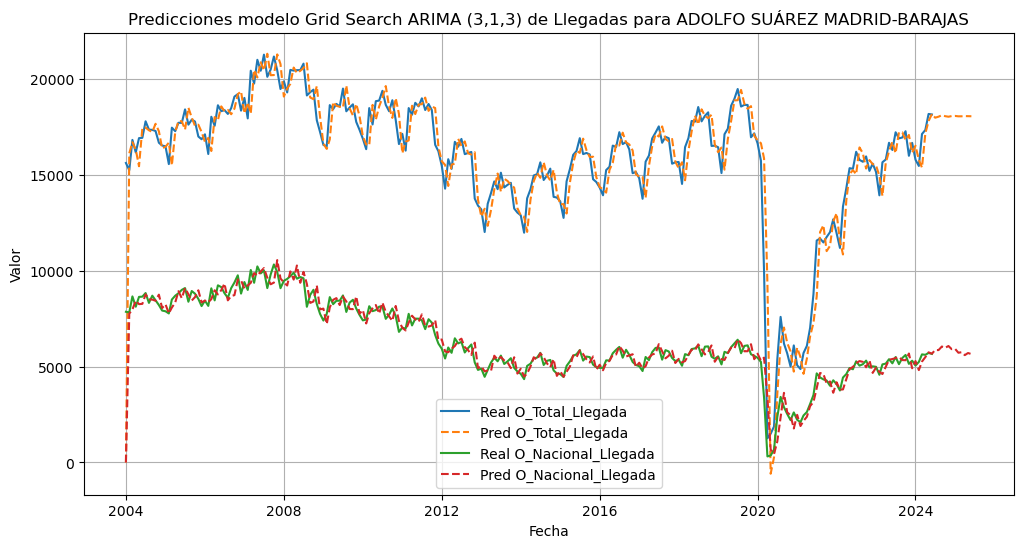

In [94]:
# Se visualizan las predicciones para un aeropuerto específico
Aeropuerto_Prediccion = 'ADOLFO SUÁREZ MADRID-BARAJAS'

# Se filtran los tipos de operación disponibles para el aeropuerto seleccionado
Tipos_Operacion = Operaciones_Unico[Operaciones_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion]['Tipo'].unique()

# Se filtran los tipos de operación para Llegada
Tipos_Llegada = [tipo for tipo in Tipos_Operacion if 'Llegada' in tipo]


# Gráfico para operaciones de Llegada
plt.figure(figsize=(12, 6))
for Tipo_Operacion_Prediccion in Tipos_Llegada:
    # Se filtran los datos reales para el tipo de operación
    Datos_Reales_Operacion_GS = Operaciones_Unico[(Operaciones_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                               (Operaciones_Unico['Tipo'] == Tipo_Operacion_Prediccion)]
    
    # Se filtran las predicciones para el tipo de operación
    Datos_Predicciones_Operacion_GS = Predicciones_Operaciones_GS[(Predicciones_Operaciones_GS['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                                            (Predicciones_Operaciones_GS['Tipo'] == Tipo_Operacion_Prediccion)]
    
    # Se añaden las series reales y predicciones al gráfico
    plt.plot(Datos_Reales_Operacion_GS.index, Datos_Reales_Operacion_GS['Valor'], label=f'Real {Tipo_Operacion_Prediccion}')
    plt.plot(Datos_Predicciones_Operacion_GS['Fecha'], Datos_Predicciones_Operacion_GS['Prediccion'], linestyle='--', label=f'Pred {Tipo_Operacion_Prediccion}')

# Se configura el gráfico
plt.title(f'Predicciones modelo Grid Search ARIMA (3,1,3) de Llegadas para {Aeropuerto_Prediccion}')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

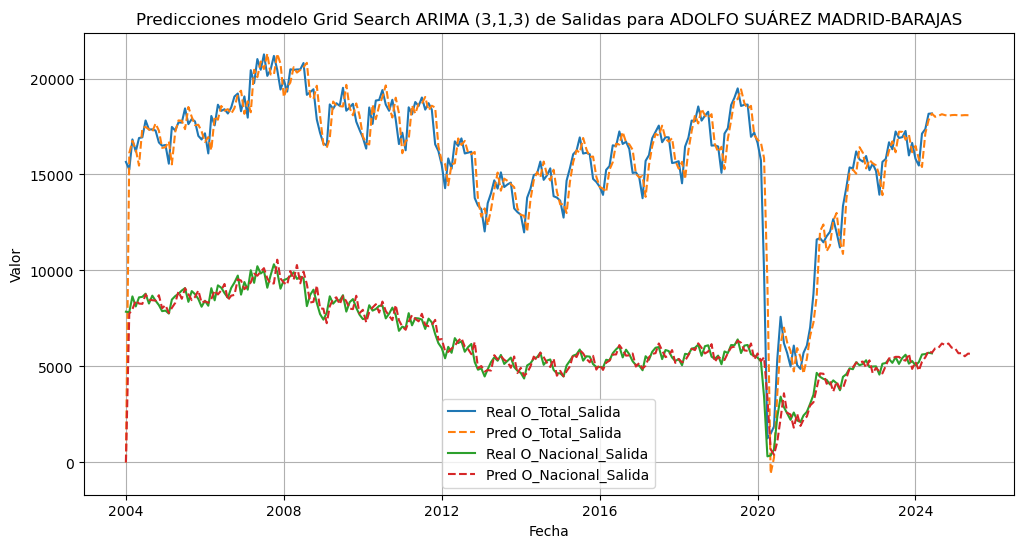

In [93]:
# Se visualizan las predicciones para un aeropuerto específico
Aeropuerto_Prediccion = 'ADOLFO SUÁREZ MADRID-BARAJAS'

# Se filtran los tipos de operación disponibles para el aeropuerto seleccionado
Tipos_Operacion = Operaciones_Unico[Operaciones_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion]['Tipo'].unique()

# Se filtran los tipos de operación para Llegada
Tipos_Salida = [tipo for tipo in Tipos_Operacion if 'Salida' in tipo]


# Gráfico para operaciones de Llegada
plt.figure(figsize=(12, 6))
for Tipo_Operacion_Prediccion in Tipos_Salida:
    # Se filtran los datos reales para el tipo de operación
    Datos_Reales_Operacion_GS = Operaciones_Unico[(Operaciones_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                               (Operaciones_Unico['Tipo'] == Tipo_Operacion_Prediccion)]
    
    # Se filtran las predicciones para el tipo de operación
    Datos_Predicciones_Operacion_GS = Predicciones_Operaciones_GS[(Predicciones_Operaciones_GS['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                                            (Predicciones_Operaciones_GS['Tipo'] == Tipo_Operacion_Prediccion)]
    
    # Se añaden las series reales y predicciones al gráfico
    plt.plot(Datos_Reales_Operacion_GS.index, Datos_Reales_Operacion_GS['Valor'], label=f'Real {Tipo_Operacion_Prediccion}')
    plt.plot(Datos_Predicciones_Operacion_GS['Fecha'], Datos_Predicciones_Operacion_GS['Prediccion'], linestyle='--', label=f'Pred {Tipo_Operacion_Prediccion}')

# Se configura el gráfico
plt.title(f'Predicciones modelo Grid Search ARIMA (3,1,3) de Salidas para {Aeropuerto_Prediccion}')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

**2-d. Métricas de error**

In [15]:
# Se crea un DataFrame para almacenar las métricas de error
Metricas_Error_Operaciones_GS = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'MAE', 'RMSE', 'MAPE'])

# Se itera sobre las combinaciones de aeropuerto y tipo de operación
for (Aeropuerto, Operacion), (Predicciones_Originales_GS, _, Fechas_Reales) in Dicc_Predicciones_Operaciones_GS.items():
    # Se obtienen los valores reales
    Valores_Reales_Operacion_GS = Operaciones_Unico[(Operaciones_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                       (Operaciones_Unico['Tipo'] == Operacion)]['Valor']
    
    # Se calculan las métricas de error si hay valores reales para comparar
    if len(Valores_Reales_Operacion_GS) == len(Predicciones_Originales_GS):
        # MAE - Error Absoluto Medio
        mae = mean_absolute_error(Valores_Reales_Operacion_GS, Predicciones_Originales_GS)
        # RMSE - Error Cuatrático Medio
        rmse = np.sqrt(mean_squared_error(Valores_Reales_Operacion_GS, Predicciones_Originales_GS))
        # MAPE - Error Porcentual Absoluto Medio
        mape = np.mean(np.abs((Valores_Reales_Operacion_GS - Predicciones_Originales_GS) / Valores_Reales_Operacion_GS)) * 100

        # Se almacenan las métricas en el DataFrame
        Temp_Metricas_Error_GS = pd.DataFrame({
            'Aeropuerto_Base': [Aeropuerto],
            'Tipo': [Operacion],
            'MAE': [mae],
            'RMSE': [rmse],
            'MAPE': [mape]
        })
       
        # Se concatenan las métricas de error
        Metricas_Error_Operaciones_GS = pd.concat([Metricas_Error_Operaciones_GS, Temp_Metricas_Error_GS], ignore_index=True) 

# Se muestran las métricas
print(Metricas_Error_Operaciones_GS)

                  Aeropuerto_Base                Tipo         MAE  \
0                        A CORUÑA     O_Total_Llegada   56.224500   
1                        A CORUÑA  O_Nacional_Llegada   54.501531   
2                        A CORUÑA      O_Total_Salida   55.833495   
3                        A CORUÑA   O_Nacional_Salida   54.209555   
4    ADOLFO SUÁREZ MADRID-BARAJAS     O_Total_Llegada  787.251436   
..                            ...                 ...         ...   
191         ALGECIRAS /HELIPUERTO   O_Nacional_Salida    9.495614   
192              MURCIA COMBINADO     O_Total_Llegada   63.312320   
193              MURCIA COMBINADO  O_Nacional_Llegada   24.401219   
194              MURCIA COMBINADO      O_Total_Salida   62.641108   
195              MURCIA COMBINADO   O_Nacional_Salida   24.805619   

            RMSE       MAPE  
0      77.298101  12.073830  
1      75.685803  13.117762  
2      76.979107  12.024443  
3      74.414674  12.829849  
4    1471.302643   8.

**2-e. Métricas de error promedias de todo el conjunto**

Se calculan los datos promedios de los errores para así, tener una visión de conjunto

In [16]:
# Se calculan las métricas medias para este modelo 
MAE_promedio_GS = Metricas_Error_Operaciones_GS['MAE'].mean()
RMSE_promedio_GS = Metricas_Error_Operaciones_GS['RMSE'].mean()
MAPE_promedio_GS = Metricas_Error_Operaciones_GS['MAPE'].mean()

# Se muestran los resultados GRID SEARCH ARIMA (3,1,3)
print(f"MAE Promedio GRID SEARCH ARIMA (3,1,3): {MAE_promedio_GS}")
print(f"RMSE Promedio GRID SEARCH ARIMA (3,1,3): {RMSE_promedio_GS}")
print(f"MAPE Promedio GRID SEARCH ARIMA (3,1,3): {MAPE_promedio_GS}%")

MAE Promedio GRID SEARCH ARIMA (3,1,3): 122.71754440171985
RMSE Promedio GRID SEARCH ARIMA (3,1,3): 186.91557583795552
MAPE Promedio GRID SEARCH ARIMA (3,1,3): inf%


Si se observan los datos de la predicciones, los datos que se obtienen son muy similare a los originales.
El MAE ha disminuido con respecto a los datos que se tenían con ARIMA sin el Grid Search, por lo que las predicciones son más precisas, como ya se ha podido comprobar.
También el Error Cuatrático Medio, también ha disminuido, por lo que se están cometiendo menos en las predicciones.
Por último, el MAPE también ha mejorado, por lo que parece que este modelo es mejor que el ARIMA sin el GRID SEARCH.
Si bien es cierto, que para el caso del aeropuerto de Murcia los datos han empeorado, por lo que se van a seguir probando modelos.

**3. Modelo Grid Search - ARIMA - 2 intento**

Se modifica el rango de los hiperparámetros para ver si se obtienen mejores resultados

In [17]:
# Se definen los parámetros p, d, q
p = d = q = range(0, 6)  # Esto probará valores de 0 a 6 para p, d, q
pdq = list(itertools.product(p, d, q))

# Se almcenan los mejores resultados
best_aic = float('inf')
best_params = None

# Se itera sobre cada combinación de parámetros
for params in pdq:
    try:
        # Se entrena el modelo ARIMA con los parámetros actuales
        model_arima = ARIMA(Datos_Reales_Operacion['Valor'], order=params)
        model_fit_arima = model_arima.fit()
        
        # Se calcula el AIC
        aic = model_fit_arima.aic
        
        # Si el AIC actual es mejor que el anterior, se actualizan los mejores parámetros
        if aic < best_aic:
            best_aic = aic
            best_params = params
            
    except Exception as e:
        print(f"Error con los parámetros {params}: {e}")
        continue

print(f'Mejor conjunto de parámetros: {best_params} con AIC: {best_aic}')

Mejor conjunto de parámetros: (5, 0, 3) con AIC: 20.0


**3-a. Se reentrena el modelo con los parámetros obtenidos, Modelo Grid Search - ARIMA - 2 intento**

Habiendo aumentado el rango de los hiperparámetros del Grid Search de 3, a 6, se obtiene otro conjunto de mejores hiperparámetros (5,0,3)

In [18]:
# Se crea un diccionario para almacenar las predicciones
Dicc_Predicciones_Operaciones_GS_2 = {}

# Se obtienen todos los aeropurtos y tipos únicos
Aeropuertos = Operaciones_Unico['Aeropuerto_Base'].unique()
Tipos_Operacion = Operaciones_Unico['Tipo'].unique()

# Se itera sobre cada aeropuerto y tipo
for Aeropuerto in Aeropuertos:
    for Operacion in Tipos_Operacion:
        # Se filtra cada aeropuerto y tipo de operación para los datos originales "reales"
        Datos_Reales_Operacion_GS_2 = Operaciones_Unico[(Operaciones_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                                   (Operaciones_Unico['Tipo'] == Operacion)]
        
        # Se comprueba que está ordenado cronologicamente
        Datos_Reales_Operacion_GS_2 = Datos_Reales_Operacion_GS_2.sort_index()

        # Se entrena el modelo ARIMA en los datos históricos
        try:
            model_arima_GS_2 = ARIMA(Datos_Reales_Operacion_GS_2['Valor'], order=(5, 0, 3))
            model_fit_arima_GS_2 = model_arima_GS_2.fit()

            # Se realizan predicciones hasta los valores que ya se tienen, junio 2024 
            Predicciones_Originales_GS_2 = model_fit_arima_GS_2.predict(start=Datos_Reales_Operacion_GS_2.index[0], end=Datos_Reales_Operacion_GS_2.index[-1])

           # Se realizan predicciones para fechas de las que no se tiene valores que ya se tienen, a partir de junio 2024 
            Predicciones_Futuras_GS_2 = model_fit_arima_GS_2.forecast(steps=12)

            # Se almacenan las predicciones en el diccionario
            Dicc_Predicciones_Operaciones_GS_2[(Aeropuerto, Operacion)] = (Predicciones_Originales_GS_2, Predicciones_Futuras_GS_2, Datos_Reales_Operacion_GS_2.index)
        
        except Exception as e:
            print(f"Error al entrenar el modelo para {Aeropuerto}, {Operacion}: {e}")

Error al entrenar el modelo para LOGROÑO, O_Nacional_Salida: LU decomposition error.
Error al entrenar el modelo para SALAMANCA, O_Nacional_Llegada: LU decomposition error.
Error al entrenar el modelo para SON BONET, O_Nacional_Salida: LU decomposition error.


Como ha dado error se prueba con otros parámetros (4,0,3)

In [19]:
# Se crea un diccionario para almacenar las predicciones
Dicc_Predicciones_Operaciones_GS_2 = {}

# Se obtienen todos los aeropurtos y tipos únicos
Aeropuertos = Operaciones_Unico['Aeropuerto_Base'].unique()
Tipos_Operacion = Operaciones_Unico['Tipo'].unique()

# Se itera sobre cada aeropuerto y tipo
for Aeropuerto in Aeropuertos:
    for Operacion in Tipos_Operacion:
        # Se filtra cada aeropuerto y tipo de operación para los datos originales "reales"
        Datos_Reales_Operacion_GS_2 = Operaciones_Unico[(Operaciones_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                                   (Operaciones_Unico['Tipo'] == Operacion)]
        
        # Se comprueba que está ordenado cronologicamente
        Datos_Reales_Operacion_GS_2 = Datos_Reales_Operacion_GS_2.sort_index()

        # Se entrena el modelo ARIMA en los datos históricos
        try:
            model_arima_GS_2 = ARIMA(Datos_Reales_Operacion_GS_2['Valor'], order=(4, 0, 3))
            model_fit_arima_GS_2 = model_arima_GS_2.fit()

            # Se realizan predicciones hasta los valores que ya se tienen, junio 2024 
            Predicciones_Originales_GS_2 = model_fit_arima_GS_2.predict(start=Datos_Reales_Operacion_GS_2.index[0], end=Datos_Reales_Operacion_GS_2.index[-1])

           # Se realizan predicciones para fechas de las que no se tiene valores que ya se tienen, a partir de junio 2024 
            Predicciones_Futuras_GS_2 = model_fit_arima_GS_2.forecast(steps=12)

            # Se almacenan las predicciones en el diccionario
            Dicc_Predicciones_Operaciones_GS_2[(Aeropuerto, Operacion)] = (Predicciones_Originales_GS_2, Predicciones_Futuras_GS_2, Datos_Reales_Operacion_GS_2.index)
        
        except Exception as e:
            print(f"Error al entrenar el modelo para {Aeropuerto}, {Operacion}: {e}")

**3-b. Dataframe en el que se guardan las predicciones y los datos reales**

In [20]:
# Se crea un dataframe para poder comparar las predicciones
Comparacion_Total_Todos_Aeropuertos_GS_2 = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'Fecha', 'Valor Real', 'Prediccion'])

for (Aeropuerto, Operacion), (Predicciones_Originales_GS_2, Predicciones_Futuras_GS_2, Fechas_Reales) in Dicc_Predicciones_Operaciones_GS_2.items():
    # Se crea un DataFrame temporal para las predicciones históricas con los valores originales
    Tem_Predicciones_Historicas_GS_2 = pd.DataFrame({
        'Aeropuerto_Base': Aeropuerto,
        'Tipo': Operacion,
        'Fecha': Fechas_Reales,
        'Valor Real': Operaciones_Unico[(Operaciones_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                        (Operaciones_Unico['Tipo'] == Operacion)]['Valor'],
        'Prediccion': Predicciones_Originales_GS_2
    })

    # Se crea un DataFrame para las predicciones futuras
    Fechas_Futuras = pd.date_range(start=Fechas_Reales[-1] + pd.offsets.MonthBegin(1), periods=len(Predicciones_Futuras_GS_2), freq='MS')
    Temp_Predicciones_Futuras_GS_2 = pd.DataFrame({
        'Aeropuerto_Base': Aeropuerto,
        'Tipo': Operacion,
        'Fecha': Fechas_Futuras,
        'Valor Real': [None] * len(Predicciones_Futuras_GS_2),
        'Prediccion': Predicciones_Futuras_GS_2
    })

    # Se concatena los dos dataframe (históricos y futuros)
    Comparacion_Total_Todos_Aeropuertos_GS_2 = pd.concat([Comparacion_Total_Todos_Aeropuertos_GS_2, Tem_Predicciones_Historicas_GS_2, Temp_Predicciones_Futuras_GS_2], ignore_index=True)

# Se muestran las últimas filas para ver los valores reales y predicciones
print(Comparacion_Total_Todos_Aeropuertos_GS_2.tail(20))

        Aeropuerto_Base               Tipo      Fecha Valor Real  Prediccion
50548  MURCIA COMBINADO  O_Nacional_Salida 2023-11-01         49   59.907746
50549  MURCIA COMBINADO  O_Nacional_Salida 2023-12-01         50   57.583348
50550  MURCIA COMBINADO  O_Nacional_Salida 2024-01-01         52   49.989900
50551  MURCIA COMBINADO  O_Nacional_Salida 2024-02-01         50   61.377100
50552  MURCIA COMBINADO  O_Nacional_Salida 2024-03-01         65   57.486731
50553  MURCIA COMBINADO  O_Nacional_Salida 2024-04-01         57   73.111402
50554  MURCIA COMBINADO  O_Nacional_Salida 2024-05-01        109   55.438662
50555  MURCIA COMBINADO  O_Nacional_Salida 2024-06-01         99  113.972586
50556  MURCIA COMBINADO  O_Nacional_Salida 2024-07-01       None   97.723965
50557  MURCIA COMBINADO  O_Nacional_Salida 2024-08-01       None  112.558343
50558  MURCIA COMBINADO  O_Nacional_Salida 2024-09-01       None  103.749799
50559  MURCIA COMBINADO  O_Nacional_Salida 2024-10-01       None  107.885598

**3-c. Visualización de las predicciones** 

In [90]:
# Se crea un DataFrame para almacenar todas las predicciones
Predicciones_Operaciones_GS2 = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'Fecha', 'Prediccion'])

for (Aeropuerto, Operacion), (Predicciones_Originales_GS_2, Predicciones_Futuras_GS_2, Fechas_Reales) in Dicc_Predicciones_Operaciones_GS_2.items():
    # Se guardan en un DataFrame temporal para las predicciones de los datos orginales "reales"
    Tem_Predicciones_Historicas_GS2 = pd.DataFrame({
        'Aeropuerto_Base': Aeropuerto,
        'Tipo': Operacion,
        'Fecha': Fechas_Reales,
        'Prediccion': Predicciones_Originales_GS_2
    })

    # Se guardan en un DataFrame temporal para las predicciones de fechas futuras
    Fechas_Futuras = pd.date_range(start=Fechas_Reales[-1] + pd.offsets.MonthBegin(1), periods=len(Predicciones_Futuras_GS_2), freq='MS')
    Temp_Predicciones_Futuras_GS2 = pd.DataFrame({
        'Aeropuerto_Base': Aeropuerto,
        'Tipo': Operacion,
        'Fecha': Fechas_Futuras,
        'Prediccion': Predicciones_Futuras_GS_2
    })

    # Se concatenan ambas predicciones y se guardan en un dataframe único
    Predicciones_Operaciones_GS2 = pd.concat([Predicciones_Operaciones_GS2, Tem_Predicciones_Historicas_GS2, Temp_Predicciones_Futuras_GS2], ignore_index=True)

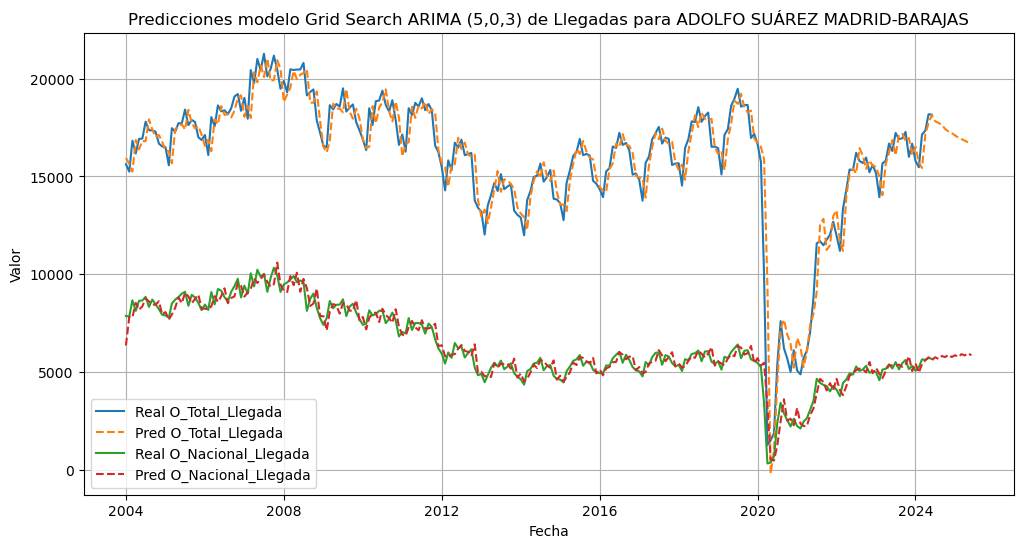

In [92]:
# Se visualizan las predicciones para un aeropuerto específico
Aeropuerto_Prediccion = 'ADOLFO SUÁREZ MADRID-BARAJAS'

# Se filtran los tipos de operación disponibles para el aeropuerto seleccionado
Tipos_Operacion = Operaciones_Unico[Operaciones_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion]['Tipo'].unique()

# Se filtran los tipos de operación para Llegada
Tipos_Llegada = [tipo for tipo in Tipos_Operacion if 'Llegada' in tipo]


# Gráfico para operaciones de Llegada
plt.figure(figsize=(12, 6))
for Tipo_Operacion_Prediccion in Tipos_Llegada:
    # Se filtran los datos reales para el tipo de operación
    Datos_Reales_Operacion_GS2 = Operaciones_Unico[(Operaciones_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                               (Operaciones_Unico['Tipo'] == Tipo_Operacion_Prediccion)]
    
    # Se filtran las predicciones para el tipo de operación
    Datos_Predicciones_Operacion_GS2 = Predicciones_Operaciones_GS2[(Predicciones_Operaciones_GS2['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                                            (Predicciones_Operaciones_GS2['Tipo'] == Tipo_Operacion_Prediccion)]
    
    # Se añaden las series reales y predicciones al gráfico
    plt.plot(Datos_Reales_Operacion_GS2.index, Datos_Reales_Operacion_GS2['Valor'], label=f'Real {Tipo_Operacion_Prediccion}')
    plt.plot(Datos_Predicciones_Operacion_GS2['Fecha'], Datos_Predicciones_Operacion_GS2['Prediccion'], linestyle='--', label=f'Pred {Tipo_Operacion_Prediccion}')

# Se configura el gráfico
plt.title(f'Predicciones modelo Grid Search ARIMA (5,0,3) de Llegadas para {Aeropuerto_Prediccion}')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

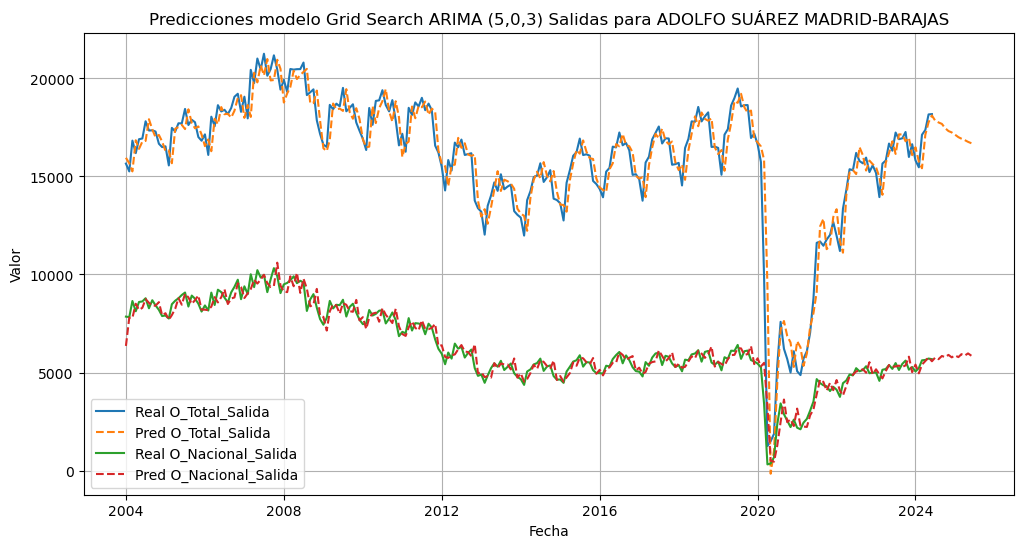

In [91]:
# Se visualizan las predicciones para un aeropuerto específico
Aeropuerto_Prediccion = 'ADOLFO SUÁREZ MADRID-BARAJAS'

# Se filtran los tipos de operación disponibles para el aeropuerto seleccionado
Tipos_Operacion = Operaciones_Unico[Operaciones_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion]['Tipo'].unique()

# Se filtran los tipos de operación para Llegada
Tipos_Salida = [tipo for tipo in Tipos_Operacion if 'Salida' in tipo]


# Gráfico para operaciones de Llegada
plt.figure(figsize=(12, 6))
for Tipo_Operacion_Prediccion in Tipos_Salida:
    # Se filtran los datos reales para el tipo de operación
    Datos_Reales_Operacion_GS2 = Operaciones_Unico[(Operaciones_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                               (Operaciones_Unico['Tipo'] == Tipo_Operacion_Prediccion)]
    
    # Se filtran las predicciones para el tipo de operación
    Datos_Predicciones_Operacion_GS2 = Predicciones_Operaciones_GS2[(Predicciones_Operaciones_GS2['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                                            (Predicciones_Operaciones_GS2['Tipo'] == Tipo_Operacion_Prediccion)]
    
    # Se añaden las series reales y predicciones al gráfico
    plt.plot(Datos_Reales_Operacion_GS2.index, Datos_Reales_Operacion_GS2['Valor'], label=f'Real {Tipo_Operacion_Prediccion}')
    plt.plot(Datos_Predicciones_Operacion_GS2['Fecha'], Datos_Predicciones_Operacion_GS2['Prediccion'], linestyle='--', label=f'Pred {Tipo_Operacion_Prediccion}')

# Se configura el gráfico
plt.title(f'Predicciones modelo Grid Search ARIMA (5,0,3) Salidas para {Aeropuerto_Prediccion}')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

**3-d. Métricas de error**

In [21]:
# Se crea un DataFrame para almacenar las métricas de error
Metricas_Error_Operaciones_GS_2 = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'MAE', 'RMSE', 'MAPE'])

# Se itera sobre las combinaciones de aeropuerto y tipo de operación
for (Aeropuerto, Operacion), (Predicciones_Originales_GS_2, _, Fechas_Reales) in Dicc_Predicciones_Operaciones_GS_2.items():
    # Se obtienen los valores reales
    Valores_Reales_Operacion_GS_2 = Operaciones_Unico[(Operaciones_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                       (Operaciones_Unico['Tipo'] == Operacion)]['Valor']
    
    # Se calculan las métricas de error si hay valores reales para comparar
    if len(Valores_Reales_Operacion_GS_2) == len(Predicciones_Originales_GS_2):
        # MAE - Error Absoluto Medio
        mae = mean_absolute_error(Valores_Reales_Operacion_GS_2, Predicciones_Originales_GS_2)
        # RMSE - Error Cuatrático Medio
        rmse = np.sqrt(mean_squared_error(Valores_Reales_Operacion_GS_2, Predicciones_Originales_GS_2))
        # MAPE - Error Porcentual Absoluto Medio
        mape = np.mean(np.abs((Valores_Reales_Operacion_GS_2 - Predicciones_Originales_GS_2) / Valores_Reales_Operacion_GS_2)) * 100

        # Se almacenan las métricas en el DataFrame
        Temp_Metricas_Error_GS_2 = pd.DataFrame({
            'Aeropuerto_Base': [Aeropuerto],
            'Tipo': [Operacion],
            'MAE': [mae],
            'RMSE': [rmse],
            'MAPE': [mape]
        })
       
        # Se concatenan las métricas de error
        Metricas_Error_Operaciones_GS_2 = pd.concat([Metricas_Error_Operaciones_GS_2, Temp_Metricas_Error_GS_2], ignore_index=True) 

# Se muestran las métricas
print(Metricas_Error_Operaciones_GS_2)

                  Aeropuerto_Base                Tipo         MAE  \
0                        A CORUÑA     O_Total_Llegada   55.378427   
1                        A CORUÑA  O_Nacional_Llegada   53.583345   
2                        A CORUÑA      O_Total_Salida   56.157677   
3                        A CORUÑA   O_Nacional_Salida   52.886698   
4    ADOLFO SUÁREZ MADRID-BARAJAS     O_Total_Llegada  718.213227   
..                            ...                 ...         ...   
191         ALGECIRAS /HELIPUERTO   O_Nacional_Salida   10.360751   
192              MURCIA COMBINADO     O_Total_Llegada   62.022418   
193              MURCIA COMBINADO  O_Nacional_Llegada   27.016093   
194              MURCIA COMBINADO      O_Total_Salida   61.003240   
195              MURCIA COMBINADO   O_Nacional_Salida   27.889161   

            RMSE       MAPE  
0      73.950192  11.718937  
1      70.917701  12.466756  
2      74.673354  12.012932  
3      70.250349  12.381725  
4    1060.914474   8.

**3-e. Métricas de error promedias de todo el conjunto**

In [22]:
# Se calculan las métricas medias para este modelo 
MAE_promedio_GS_2 = Metricas_Error_Operaciones_GS_2['MAE'].mean()
RMSE_promedio_GS_2 = Metricas_Error_Operaciones_GS_2['RMSE'].mean()
MAPE_promedio_GS_2 = Metricas_Error_Operaciones_GS_2['MAPE'].mean()

# Se muestran los resultados GRID SEARCH ARIMA (4,0,3)
print(f"MAE Promedio GRID SEARCH ARIMA (4,0,3): {MAE_promedio_GS_2}")
print(f"RMSE Promedio GGRID SEARCH ARIMA (4,0,3): {RMSE_promedio_GS_2}")
print(f"MAPE Promedio GRID SEARCH ARIMA (4,0,3): {MAPE_promedio_GS_2}%")

MAE Promedio GRID SEARCH ARIMA (4,0,3): 120.73715159727787
RMSE Promedio GGRID SEARCH ARIMA (4,0,3): 166.58384770578655
MAPE Promedio GRID SEARCH ARIMA (4,0,3): inf%


Si se observan los valores promedios del modelos GRID SEARCH ARIMA (4,0,3) comparado con los modelos anteriores, tanto el MAE como el RSM han disminuido, por lo que la precisión y la predicción son mejores que los modelos anteriores.
Además, si se observa los valores del Aeropuerto de A Coruña, que era el que había empeorado en el modelo anterior, en este ha mejorado:

Modelo ARIMA nuevo (4,0,3)

  Aeropuerto_Base	Tipo	    MAE	    RMSE    MAPE  	
- CORUÑA	O_Total_Llegada	    55,38	73.95	11.71
- CORUÑA	O_Nacional_Llegada	53,58	70.92	12.47
- CORUÑA	O_Total_Salida	    56,16	74.67	12.01
- CORUÑA	O_Nacional_Salida	52,89	70.25	12,38

Este modelo por ahora es el mejor de los estudiados.

**4. Modelo Random Search - ARIMA**

Se prueba otro modelo de búsqueda de los mejores parámetros esta vez, de manera aleatoria, sin comprobar todas las combinaciones posibles,Random Search, y, además como el ampliar el rango, en el modelo anterior funcionó, en este caso también se vuelve a ampliar hasta 7.

In [23]:
# Se definen los rangos de p, d, q
p = d = q = range(0, 7)  # Como uno de los modelos mejores fue el (4,0,3), se añade un rango más por si pudiera mejorar

# Se crean las combinaciones posibles de p, d, q
pdq = list(itertools.product(p, d, q))

# Se define el número de combinaciones
N_Iteraciones = 10  #

# Se selecciona el número de combinaciones e iteracciones aleatoriamente
Combinaciones_Aleatorias_RS = random.sample(pdq, N_Iteraciones)

In [24]:
# Se almcenan los mejores resultados
Mejor_aic = float('inf')
Mejor_params = None

# Se itera sobre cada combinación de parámetros
for params in Combinaciones_Aleatorias_RS:
    try:
        # Se entrena el modelo ARIMA con los parámetros actuales
        model_arima_RS = ARIMA(Datos_Reales_Operacion['Valor'], order=params)
        model_fit_arima_RS = model_arima_RS.fit()
        
        # Se calcula el AIC
        aic = model_fit_arima_RS.aic
        
        # Si el AIC actual es mejor que el anterior, actualizar los mejores parámetros
        if aic < Mejor_aic:
            Mejor_aic = aic
            Mejor_params = params
            
    except Exception as e:
        print(f"Error con los parámetros {params}: {e}")
        continue

print(f'Mejor conjunto de parámetros: {Mejor_params} con AIC: {Mejor_aic}')

Mejor conjunto de parámetros: (6, 1, 1) con AIC: 2509.0073376243963


**4-a. Se reentrena el modelo con los parámetros obtenidos, Modelo Random Search - ARIMA**

Se reentrena el modelo con el conjunto de parámetros que el modelo ha evaluado como más óptimos (6,1,1)

In [25]:
# Se crea un diccionario para almacenar las predicciones
Dicc_Predicciones_Operaciones_RS = {}

# Se obtienen todos los aeropurtos y tipos únicos
Aeropuertos = Operaciones_Unico['Aeropuerto_Base'].unique()
Tipos_Operacion = Operaciones_Unico['Tipo'].unique()

# Se itera sobre cada aeropuerto y tipo
for Aeropuerto in Aeropuertos:
    for Operacion in Tipos_Operacion:
        # Se filtra cada aeropuerto y tipo de operación para los datos originales "reales"
        Datos_Reales_Operacion_RS = Operaciones_Unico[(Operaciones_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                                   (Operaciones_Unico['Tipo'] == Operacion)]
        
        # Se comprueba que está ordenado cronologicamente
        Datos_Reales_Operacion_RS = Datos_Reales_Operacion_RS.sort_index()

        # Se entrena el modelo ARIMA en los datos históricos
        try:
            model_arima_RS = ARIMA(Datos_Reales_Operacion_RS['Valor'], order=(6, 1, 1))
            model_fit_arima_RS = model_arima_RS.fit()

            # Se realizan predicciones hasta los valores que ya se tienen, junio 2024 
            Predicciones_Originales_RS = model_fit_arima_RS.predict(start=Datos_Reales_Operacion_RS.index[0], end=Datos_Reales_Operacion_RS.index[-1])

           # Se realizan predicciones para fechas de las que no se tiene valores que ya se tienen, a partir de junio 2024 
            Predicciones_Futuras_RS = model_fit_arima_RS.forecast(steps=12)

            # Se almacenan las predicciones en el diccionario
            Dicc_Predicciones_Operaciones_RS[(Aeropuerto, Operacion)] = (Predicciones_Originales_RS, Predicciones_Futuras_RS, Datos_Reales_Operacion_RS.index)
        
        except Exception as e:
            print(f"Error al entrenar el modelo para {Aeropuerto}, {Operacion}: {e}")

**4-b. Dataframe en el que se guardan las predicciones y los datos reales**

In [26]:
# Se crea un dataframe para poder comparar las predicciones
Comparacion_Total_Todos_Aeropuertos_RS = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'Fecha', 'Valor Real', 'Prediccion'])

for (Aeropuerto, Operacion), (Predicciones_Originales_RS, Predicciones_Futuras_RS, Fechas_Reales) in Dicc_Predicciones_Operaciones_RS.items():
    # Se crea un DataFrame temporal para las predicciones históricas con los valores originales
    Tem_Predicciones_Historicas_RS = pd.DataFrame({
        'Aeropuerto_Base': Aeropuerto,
        'Tipo': Operacion,
        'Fecha': Fechas_Reales,
        'Valor Real': Operaciones_Unico[(Operaciones_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                        (Operaciones_Unico['Tipo'] == Operacion)]['Valor'],
        'Prediccion': Predicciones_Originales_RS
    })

    # Se crea un DataFrame para las predicciones futuras
    Fechas_Futuras = pd.date_range(start=Fechas_Reales[-1] + pd.offsets.MonthBegin(1), periods=len(Predicciones_Futuras_RS), freq='MS')
    Temp_Predicciones_Futuras_RS = pd.DataFrame({
        'Aeropuerto_Base': Aeropuerto,
        'Tipo': Operacion,
        'Fecha': Fechas_Futuras,
        'Valor Real': [None] * len(Predicciones_Futuras_RS),
        'Prediccion': Predicciones_Futuras_RS
    })

    # Se concatena los dos dataframe (históricos y futuros)
    Comparacion_Total_Todos_Aeropuertos_RS = pd.concat([Comparacion_Total_Todos_Aeropuertos_RS, Tem_Predicciones_Historicas_RS, Temp_Predicciones_Futuras_RS], ignore_index=True)

# Se muestran las últimas filas para ver los valores reales y predicciones
print(Comparacion_Total_Todos_Aeropuertos_RS.tail(20))

        Aeropuerto_Base               Tipo      Fecha Valor Real  Prediccion
50548  MURCIA COMBINADO  O_Nacional_Salida 2023-11-01         49   37.825406
50549  MURCIA COMBINADO  O_Nacional_Salida 2023-12-01         50   49.384812
50550  MURCIA COMBINADO  O_Nacional_Salida 2024-01-01         52   44.173151
50551  MURCIA COMBINADO  O_Nacional_Salida 2024-02-01         50   55.378993
50552  MURCIA COMBINADO  O_Nacional_Salida 2024-03-01         65   51.490595
50553  MURCIA COMBINADO  O_Nacional_Salida 2024-04-01         57   71.640268
50554  MURCIA COMBINADO  O_Nacional_Salida 2024-05-01        109   61.158221
50555  MURCIA COMBINADO  O_Nacional_Salida 2024-06-01         99  100.533053
50556  MURCIA COMBINADO  O_Nacional_Salida 2024-07-01       None   78.156537
50557  MURCIA COMBINADO  O_Nacional_Salida 2024-08-01       None   72.760716
50558  MURCIA COMBINADO  O_Nacional_Salida 2024-09-01       None   62.891018
50559  MURCIA COMBINADO  O_Nacional_Salida 2024-10-01       None   62.333675

**4-c. Métricas de error**

In [27]:
# Se crea un DataFrame para almacenar las métricas de error
Metricas_Error_Operaciones_RS = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'MAE', 'RMSE', 'MAPE'])

# Se itera sobre las combinaciones de aeropuerto y tipo de operación
for (Aeropuerto, Operacion), (Predicciones_Originales_RS, _, Fechas_Reales) in Dicc_Predicciones_Operaciones_RS.items():
    # Se obtienen los valores reales
    Valores_Reales_Operacion_RS = Operaciones_Unico[(Operaciones_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                       (Operaciones_Unico['Tipo'] == Operacion)]['Valor']
    
    # Se calculan las métricas de error si hay valores reales para comparar
    if len(Valores_Reales_Operacion_RS) == len(Predicciones_Originales_RS):
        # MAE - Error Absoluto Medio
        mae = mean_absolute_error(Valores_Reales_Operacion_RS, Predicciones_Originales_RS)
        # RMSE - Error Cuatrático Medio
        rmse = np.sqrt(mean_squared_error(Valores_Reales_Operacion_RS, Predicciones_Originales_RS))
        # MAPE - Error Porcentual Absoluto Medio
        mape = np.mean(np.abs((Valores_Reales_Operacion_RS - Predicciones_Originales_RS) / Valores_Reales_Operacion_RS)) * 100

        # Se almacenan las métricas en el DataFrame
        Temp_Metricas_Error_RS = pd.DataFrame({
            'Aeropuerto_Base': [Aeropuerto],
            'Tipo': [Operacion],
            'MAE': [mae],
            'RMSE': [rmse],
            'MAPE': [mape]
        })
       
        # Se concatenan las métricas de error
        Metricas_Error_Operaciones_RS = pd.concat([Metricas_Error_Operaciones_RS, Temp_Metricas_Error_RS], ignore_index=True) 

# Se muestran las métricas
print(Metricas_Error_Operaciones_RS)

                  Aeropuerto_Base                Tipo         MAE  \
0                        A CORUÑA     O_Total_Llegada   57.656022   
1                        A CORUÑA  O_Nacional_Llegada   55.731432   
2                        A CORUÑA      O_Total_Salida   56.995702   
3                        A CORUÑA   O_Nacional_Salida   54.816264   
4    ADOLFO SUÁREZ MADRID-BARAJAS     O_Total_Llegada  756.923136   
..                            ...                 ...         ...   
191         ALGECIRAS /HELIPUERTO   O_Nacional_Salida    9.660361   
192              MURCIA COMBINADO     O_Total_Llegada   60.116205   
193              MURCIA COMBINADO  O_Nacional_Llegada   24.567703   
194              MURCIA COMBINADO      O_Total_Salida   60.365307   
195              MURCIA COMBINADO   O_Nacional_Salida   24.934932   

            RMSE       MAPE  
0      79.471910  12.383100  
1      76.606026  13.122742  
2      78.899546  12.278567  
3      75.759568  12.944627  
4    1438.796957   8.

**4-d. Métricas de error promedias de todo el conjunto**

In [28]:
# Se calculan las métricas medias para este modelo 
MAE_promedio_RS = Metricas_Error_Operaciones_RS['MAE'].mean()
RMSE_promedio_RS = Metricas_Error_Operaciones_RS['RMSE'].mean()
MAPE_promedio_RS = Metricas_Error_Operaciones_RS['MAPE'].mean()

# Se muestran los resultados RANDOM SEARCH ARIMA (6,1,1)
print(f"MAE Promedio RANDOM SEARCH ARIMA (6,1,1): {MAE_promedio_RS}")
print(f"RMSE Promedio RANDOM SEARCH ARIMA (6,1,1): {RMSE_promedio_RS}")
print(f"MAPE Promedio RANDOM SEARCH ARIMA (6,1,1): {MAPE_promedio_RS}%")

MAE Promedio RANDOM SEARCH ARIMA (6,1,1): 121.51427728373788
RMSE Promedio RANDOM SEARCH ARIMA (6,1,1): 186.14723612927904
MAPE Promedio RANDOM SEARCH ARIMA (6,1,1): inf%


Este modelo no ha mejorado en medias con respecto al modelo anterior GRID SEARCH ARIMA (4,1,3) como se puede comprobar con los datos obtenidos de las métricas de errores, por lo que este modelo no es mejor

**5. Modelo SARIMA**

Los parámetros que se van a usar ptra combinación diferencte de hiperparámetros (3,0,3), por si es capaz de interpretar la sutil estacionalidad que tienen los aeropuertos según determinadas temporadas (verano, Navidad, Semana Santa)

In [29]:
# Se crea un diccionario para almacenar las predicciones
Dicc_Predicciones_Operaciones_SA = {}

# Se obtienen todos los aeropurtos y tipos únicos
Aeropuertos = Operaciones_Unico['Aeropuerto_Base'].unique()
Tipos_Operacion = Operaciones_Unico['Tipo'].unique()

# Se itera sobre cada aeropuerto y tipo
for Aeropuerto in Aeropuertos:
    for Operacion in Tipos_Operacion:
        # Se filtra cada aeropuerto y tipo de operación para los datos originales "reales"
        Datos_Reales_Operacion_SA = Operaciones_Unico[(Operaciones_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                                      (Operaciones_Unico['Tipo'] == Operacion)]
        
        # Se comprueba que está ordenado cronológicamente
        Datos_Reales_Operacion_SA = Datos_Reales_Operacion_SA.sort_index()

        # Se entrena el modelo SARIMA en los datos históricos
        try:
            # Se ajustan los parámetros del modelo SARIMA
            model_sarima_SA = SARIMAX(Datos_Reales_Operacion_SA['Valor'], 
                                      order=(3, 0, 3),  # Parámetros ARIMA que mejor han funcionado en el modelo anterior
                                      seasonal_order=(1, 1, 1, 12))  # Parámetros estacionales
            model_fit_sarima_SA = model_sarima_SA.fit()

            # Se realizan predicciones para los valores históricos
            Predicciones_Originales_SA = model_fit_sarima_SA.predict(start=Datos_Reales_Operacion_SA.index[0], end=Datos_Reales_Operacion_SA.index[-1])

            # Se realizan predicciones para fechas futuras, el siguiente año completo, 12 meses
            Predicciones_Futuras_SA = model_fit_sarima_SA.forecast(steps=12)

            # Se almacenan las predicciones en el diccionario
            Dicc_Predicciones_Operaciones_SA[(Aeropuerto, Operacion)] = (Predicciones_Originales_SA, Predicciones_Futuras_SA, Datos_Reales_Operacion_SA.index)
        
        except Exception as e:
            print(f"Error al entrenar el modelo SARIMA para {Aeropuerto}, {Operacion}: {e}")

**5-a. Dataframe en el que se guardan las predicciones y los datos reales**

In [30]:
# Se crea un dataframe para poder comparar las predicciones
Comparacion_Total_Todos_Aeropuertos_SA = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'Fecha', 'Valor Real', 'Prediccion'])

for (Aeropuerto, Operacion), (Predicciones_Originales_SA, Predicciones_Futuras_SA, Fechas_Reales) in Dicc_Predicciones_Operaciones_SA.items():
    # Se crea un DataFrame temporal para las predicciones históricas con los valores originales
    Tem_Predicciones_Historicas_SA = pd.DataFrame({
        'Aeropuerto_Base': Aeropuerto,
        'Tipo': Operacion,
        'Fecha': Fechas_Reales,
        'Valor Real': Operaciones_Unico[(Operaciones_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                        (Operaciones_Unico['Tipo'] == Operacion)]['Valor'],
        'Prediccion': Predicciones_Originales_SA
    })

    # Se crea un DataFrame para las predicciones futuras
    Fechas_Futuras = pd.date_range(start=Fechas_Reales[-1] + pd.offsets.MonthBegin(1), periods=len(Predicciones_Futuras_SA), freq='MS')
    Temp_Predicciones_Futuras_SA = pd.DataFrame({
        'Aeropuerto_Base': Aeropuerto,
        'Tipo': Operacion,
        'Fecha': Fechas_Futuras,
        'Valor Real': [None] * len(Predicciones_Futuras_SA),
        'Prediccion': Predicciones_Futuras_SA
    })

    # Se concatena los dos dataframe (históricos y futuros)
    Comparacion_Total_Todos_Aeropuertos_SA = pd.concat([Comparacion_Total_Todos_Aeropuertos_SA, Tem_Predicciones_Historicas_SA, Temp_Predicciones_Futuras_SA], ignore_index=True)

# Se muestran las últimas filas para ver los valores reales y predicciones
print(Comparacion_Total_Todos_Aeropuertos_SA.tail(20))

        Aeropuerto_Base               Tipo      Fecha Valor Real  Prediccion
50548  MURCIA COMBINADO  O_Nacional_Salida 2023-11-01         49   41.153511
50549  MURCIA COMBINADO  O_Nacional_Salida 2023-12-01         50   46.903146
50550  MURCIA COMBINADO  O_Nacional_Salida 2024-01-01         52   51.462106
50551  MURCIA COMBINADO  O_Nacional_Salida 2024-02-01         50   33.748291
50552  MURCIA COMBINADO  O_Nacional_Salida 2024-03-01         65   57.868450
50553  MURCIA COMBINADO  O_Nacional_Salida 2024-04-01         57   65.006841
50554  MURCIA COMBINADO  O_Nacional_Salida 2024-05-01        109   87.322443
50555  MURCIA COMBINADO  O_Nacional_Salida 2024-06-01         99   89.664607
50556  MURCIA COMBINADO  O_Nacional_Salida 2024-07-01       None  110.596359
50557  MURCIA COMBINADO  O_Nacional_Salida 2024-08-01       None   95.778314
50558  MURCIA COMBINADO  O_Nacional_Salida 2024-09-01       None   99.442033
50559  MURCIA COMBINADO  O_Nacional_Salida 2024-10-01       None   69.128629

**5-c. Visualización de las predicciones**

In [95]:
# Se crea un DataFrame para almacenar todas las predicciones
Predicciones_Operaciones_SA = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'Fecha', 'Prediccion'])

for (Aeropuerto, Operacion), (Predicciones_Originales_SA, Predicciones_Futuras_SA, Fechas_Reales) in Dicc_Predicciones_Operaciones_SA.items():
    # Se guardan en un DataFrame temporal para las predicciones de los datos orginales "reales"
    Tem_Predicciones_Historicas_SA = pd.DataFrame({
        'Aeropuerto_Base': Aeropuerto,
        'Tipo': Operacion,
        'Fecha': Fechas_Reales,
        'Prediccion': Predicciones_Originales_SA
    })

    # Se guardan en un DataFrame temporal para las predicciones de fechas futuras
    Fechas_Futuras = pd.date_range(start=Fechas_Reales[-1] + pd.offsets.MonthBegin(1), periods=len(Predicciones_Futuras_SA), freq='MS')
    Temp_Predicciones_Futuras_SA = pd.DataFrame({
        'Aeropuerto_Base': Aeropuerto,
        'Tipo': Operacion,
        'Fecha': Fechas_Futuras,
        'Prediccion': Predicciones_Futuras_SA
    })

    # Se concatenan ambas predicciones y se guardan en un dataframe único
    Predicciones_Operaciones_SA = pd.concat([Predicciones_Operaciones_SA, Tem_Predicciones_Historicas_SA, Temp_Predicciones_Futuras_SA], ignore_index=True)

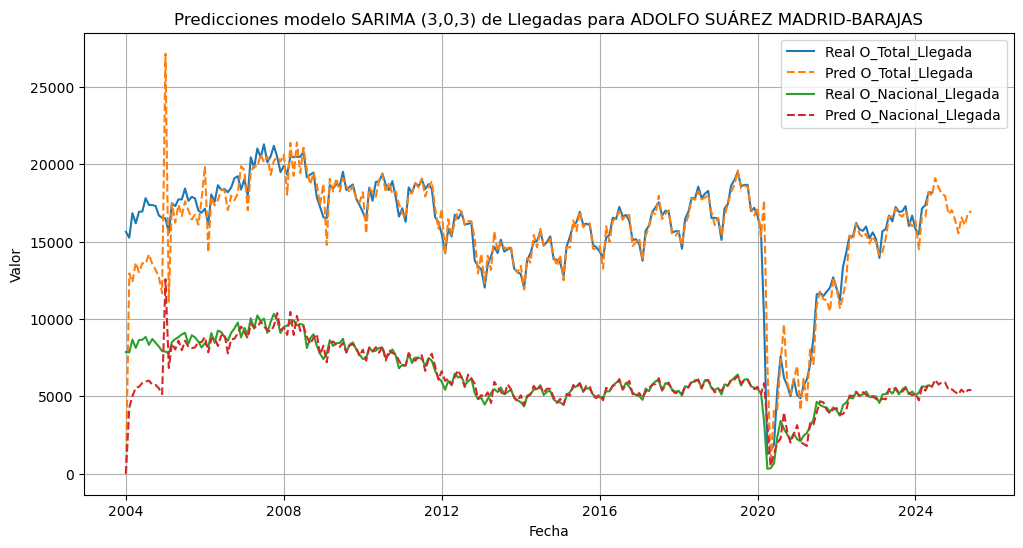

In [96]:
# Se visualizan las predicciones para un aeropuerto específico
Aeropuerto_Prediccion = 'ADOLFO SUÁREZ MADRID-BARAJAS'

# Se filtran los tipos de operación disponibles para el aeropuerto seleccionado
Tipos_Operacion = Operaciones_Unico[Operaciones_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion]['Tipo'].unique()

# Se filtran los tipos de operación para Llegada
Tipos_Llegada = [tipo for tipo in Tipos_Operacion if 'Llegada' in tipo]


# Gráfico para operaciones de Llegada
plt.figure(figsize=(12, 6))
for Tipo_Operacion_Prediccion in Tipos_Llegada:
    # Se filtran los datos reales para el tipo de operación
    Datos_Reales_Operacion_SA = Operaciones_Unico[(Operaciones_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                               (Operaciones_Unico['Tipo'] == Tipo_Operacion_Prediccion)]
    
    # Se filtran las predicciones para el tipo de operación
    Datos_Predicciones_Operacion_SA = Predicciones_Operaciones_SA[(Predicciones_Operaciones_SA['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                                            (Predicciones_Operaciones_SA['Tipo'] == Tipo_Operacion_Prediccion)]
    
    # Se añaden las series reales y predicciones al gráfico
    plt.plot(Datos_Reales_Operacion_SA.index, Datos_Reales_Operacion_SA['Valor'], label=f'Real {Tipo_Operacion_Prediccion}')
    plt.plot(Datos_Predicciones_Operacion_SA['Fecha'], Datos_Predicciones_Operacion_SA['Prediccion'], linestyle='--', label=f'Pred {Tipo_Operacion_Prediccion}')

# Se configura el gráfico
plt.title(f'Predicciones modelo SARIMA (3,0,3) de Llegadas para {Aeropuerto_Prediccion}')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

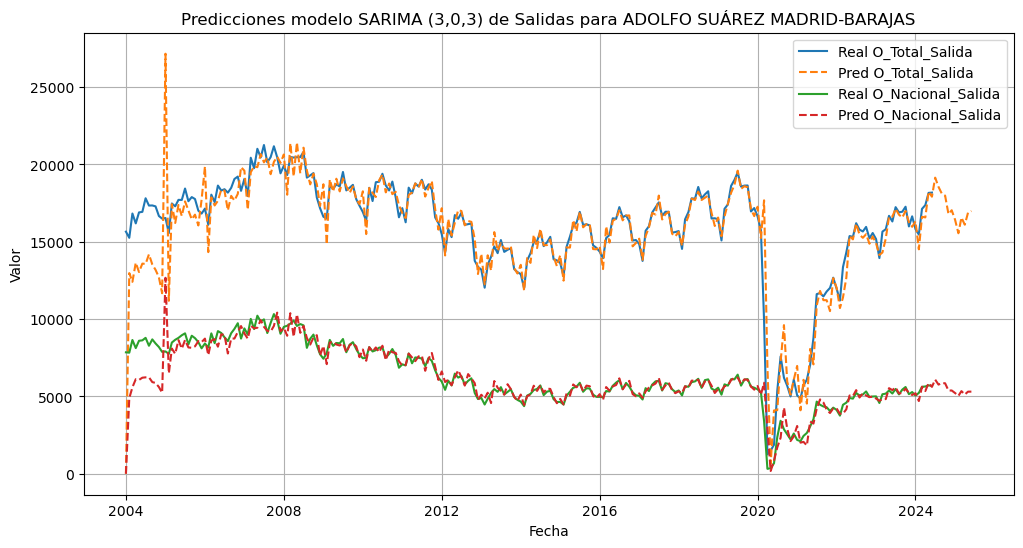

In [97]:
# Se visualizan las predicciones para un aeropuerto específico
Aeropuerto_Prediccion = 'ADOLFO SUÁREZ MADRID-BARAJAS'

# Se filtran los tipos de operación disponibles para el aeropuerto seleccionado
Tipos_Operacion = Operaciones_Unico[Operaciones_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion]['Tipo'].unique()

# Se filtran los tipos de operación para Llegada
Tipos_Salida = [tipo for tipo in Tipos_Operacion if 'Salida' in tipo]


# Gráfico para operaciones de Llegada
plt.figure(figsize=(12, 6))
for Tipo_Operacion_Prediccion in Tipos_Salida:
    # Se filtran los datos reales para el tipo de operación
    Datos_Reales_Operacion_SA = Operaciones_Unico[(Operaciones_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                               (Operaciones_Unico['Tipo'] == Tipo_Operacion_Prediccion)]
    
    # Se filtran las predicciones para el tipo de operación
    Datos_Predicciones_Operacion_SA = Predicciones_Operaciones_SA[(Predicciones_Operaciones_SA['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                                            (Predicciones_Operaciones_SA['Tipo'] == Tipo_Operacion_Prediccion)]
    
    # Se añaden las series reales y predicciones al gráfico
    plt.plot(Datos_Reales_Operacion_SA.index, Datos_Reales_Operacion_SA['Valor'], label=f'Real {Tipo_Operacion_Prediccion}')
    plt.plot(Datos_Predicciones_Operacion_SA['Fecha'], Datos_Predicciones_Operacion_SA['Prediccion'], linestyle='--', label=f'Pred {Tipo_Operacion_Prediccion}')

# Se configura el gráfico
plt.title(f'Predicciones modelo SARIMA (3,0,3) de Salidas para {Aeropuerto_Prediccion}')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

**5-d. Métricas de error**

In [31]:
# Se crea un DataFrame para almacenar las métricas de error
Metricas_Error_Operaciones_SA = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'MAE', 'RMSE', 'MAPE'])

# Se itera sobre las combinaciones de aeropuerto y tipo de operación
for (Aeropuerto, Operacion), (Predicciones_Originales_SA, _, Fechas_Reales) in Dicc_Predicciones_Operaciones_SA.items():
    # Se obtienen los valores reales
    Valores_Reales_Operacion_SA = Operaciones_Unico[(Operaciones_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                       (Operaciones_Unico['Tipo'] == Operacion)]['Valor']
    
    # Se calculan las métricas de error si hay valores reales para comparar
    if len(Valores_Reales_Operacion_SA) == len(Predicciones_Originales_SA):
        # MAE - Error Absoluto Medio
        mae = mean_absolute_error(Valores_Reales_Operacion_SA, Predicciones_Originales_SA)
        # RMSE - Error Cuatrático Medio
        rmse = np.sqrt(mean_squared_error(Valores_Reales_Operacion_SA, Predicciones_Originales_SA))
        # MAPE - Error Porcentual Absoluto Medio
        mape = np.mean(np.abs((Valores_Reales_Operacion_SA - Predicciones_Originales_SA) / Valores_Reales_Operacion_SA)) * 100

        # Se almacenan las métricas en el DataFrame
        Temp_Metricas_Error_SA = pd.DataFrame({
            'Aeropuerto_Base': [Aeropuerto],
            'Tipo': [Operacion],
            'MAE': [mae],
            'RMSE': [rmse],
            'MAPE': [mape]
        })
       
        # Se concatenan las métricas de error
        Metricas_Error_Operaciones_SA = pd.concat([Metricas_Error_Operaciones_SA, Temp_Metricas_Error_SA], ignore_index=True) 

# Se muestran las métricas
print(Metricas_Error_Operaciones_SA)

                  Aeropuerto_Base                Tipo         MAE  \
0                        A CORUÑA     O_Total_Llegada   73.758234   
1                        A CORUÑA  O_Nacional_Llegada   70.910329   
2                        A CORUÑA      O_Total_Salida   73.579909   
3                        A CORUÑA   O_Nacional_Salida   69.485587   
4    ADOLFO SUÁREZ MADRID-BARAJAS     O_Total_Llegada  816.502424   
..                            ...                 ...         ...   
191         ALGECIRAS /HELIPUERTO   O_Nacional_Salida    9.371451   
192              MURCIA COMBINADO     O_Total_Llegada   57.337017   
193              MURCIA COMBINADO  O_Nacional_Llegada   29.429073   
194              MURCIA COMBINADO      O_Total_Salida   57.382147   
195              MURCIA COMBINADO   O_Nacional_Salida   29.520510   

            RMSE       MAPE  
0     135.181278  15.807878  
1     127.851104  16.574892  
2     134.913473  15.783347  
3     126.802589  16.306543  
4    1743.733930   7.

**5-e. Métricas de error promedias de todo el conjunto**

In [32]:
# Se calculan las métricas medias para este modelo 
MAE_promedio_SA = Metricas_Error_Operaciones_SA['MAE'].mean()
RMSE_promedio_SA = Metricas_Error_Operaciones_SA['RMSE'].mean()
MAPE_promedio_SA = Metricas_Error_Operaciones_SA['MAPE'].mean()

# Se muestran los resultados SARIMA
print(f"MAE Promedio SARIMA (3,0,3): {MAE_promedio_SA}")
print(f"RMSE Promedio SARIMA (3,0,3): {RMSE_promedio_SA}")
print(f"MAPE Promedio SARIMA (3,0,3): {MAPE_promedio_SA}%")

MAE Promedio SARIMA (3,0,3): 125.01305317280384
RMSE Promedio SARIMA (3,0,3): 239.45290138485277
MAPE Promedio SARIMA (3,0,3): inf%


Los datos promedios en este modelo (SARIMA) no han mejorado, no es que con respecto al anterior hayan empeorado mucho la precisión pero no son los datos mejores.
Se siguen estudiando más modelos.

**6. Modelo Exponencial Holt-Winters - aditivo**

Dado que las series presentan cierta estacionalidad se prueba con este tipo de modelo, para ver si mejoran las predicciones

In [5]:
# Se crea un diccionario para almacenar las predicciones
Dicc_Predicciones_HoltWinters_AD = {}

# Se obtienen todos los aeropuertos y tipos únicos
Aeropuertos = Operaciones_Unico['Aeropuerto_Base'].unique()
Tipos_Operacion = Operaciones_Unico['Tipo'].unique()

# Se itera sobre cada aeropuerto y tipo
for Aeropuerto in Aeropuertos:
    for Operacion in Tipos_Operacion:
        # Se filtra cada aeropuerto y tipo de operación
        Datos_Reales_Operacion_HW_AD = Operaciones_Unico[(Operaciones_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                                      (Operaciones_Unico['Tipo'] == Operacion)]
        
        # Se comprueba que está ordenado cronológicamente
        Datos_Reales_Operacion_HW_AD = Datos_Reales_Operacion_HW_AD.sort_index()

        # Se entrena el modelo Holt-Winters en los datos históricos
        try:
            model_hw_AD = ExponentialSmoothing(Datos_Reales_Operacion_HW_AD['Valor'], 
                                            trend='add', 
                                            seasonal='add', 
                                            seasonal_periods=12)
            model_fit_hw_AD = model_hw_AD.fit()

            # Se realizan predicciones para los valores históricos
            Predicciones_Originales_HWA = model_fit_hw_AD.predict(start=Datos_Reales_Operacion_HW_AD.index[0], end=Datos_Reales_Operacion_HW_AD.index[-1])

            # Se realizan predicciones para fechas futuras, el siguiente año completo, 12 meses
            Predicciones_Futuras_HWA = model_fit_hw_AD.forecast(steps=12)

             # Se almacenan las predicciones en el diccionario
            Dicc_Predicciones_HoltWinters_AD[(Aeropuerto, Operacion)] = (Predicciones_Originales_HWA, Predicciones_Futuras_HWA, Datos_Reales_Operacion_HW_AD.index)
        
        except Exception as e:
            print(f"Error al entrenar el modelo Holt-Winters ADitivo para {Aeropuerto}, {Operacion}: {e}")

**6-a. Dataframe en el que se guardan las predicciones y los datos reales**

In [6]:
# Se crea un dataframe para poder comparar las predicciones
Comparacion_Total_Todos_Aeropuertos_HWA_O = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'Fecha', 'Valor Real', 'Prediccion'])

for (Aeropuerto, Operacion), (Predicciones_Originales_HWA, Predicciones_Futuras_HWA, Fechas_Reales) in Dicc_Predicciones_HoltWinters_AD.items():
    # Se crea un DataFrame temporal para las predicciones históricas con los valores originales
    Tem_Predicciones_Historicas_HWA = pd.DataFrame({
        'Aeropuerto_Base': Aeropuerto,
        'Tipo': Operacion,
        'Fecha': Fechas_Reales,
        'Valor Real': Operaciones_Unico[(Operaciones_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                        (Operaciones_Unico['Tipo'] == Operacion)]['Valor'],
        'Prediccion': Predicciones_Originales_HWA
    })

    # Se crea un DataFrame para las predicciones futuras
    Fechas_Futuras = pd.date_range(start=Fechas_Reales[-1] + pd.offsets.MonthBegin(1), periods=len(Predicciones_Futuras_HWA), freq='MS')
    Temp_Predicciones_Futuras_HWA = pd.DataFrame({
        'Aeropuerto_Base': Aeropuerto,
        'Tipo': Operacion,
        'Fecha': Fechas_Futuras,
        'Valor Real': [None] * len(Predicciones_Futuras_HWA),
        'Prediccion': Predicciones_Futuras_HWA
    })

    # Se concatena los dos dataframe (históricos y futuros)
    Comparacion_Total_Todos_Aeropuertos_HWA_O = pd.concat([Comparacion_Total_Todos_Aeropuertos_HWA_O, Tem_Predicciones_Historicas_HWA, Temp_Predicciones_Futuras_HWA], ignore_index=True)

# Se muestran las últimas filas para ver los valores reales y predicciones
print(Comparacion_Total_Todos_Aeropuertos_HWA_O.tail(20))

        Aeropuerto_Base               Tipo      Fecha Valor Real  Prediccion
50548  MURCIA COMBINADO  O_Nacional_Salida 2023-11-01         49   35.971651
50549  MURCIA COMBINADO  O_Nacional_Salida 2023-12-01         50   43.532360
50550  MURCIA COMBINADO  O_Nacional_Salida 2024-01-01         52   45.953724
50551  MURCIA COMBINADO  O_Nacional_Salida 2024-02-01         50   35.446724
50552  MURCIA COMBINADO  O_Nacional_Salida 2024-03-01         65   54.141321
50553  MURCIA COMBINADO  O_Nacional_Salida 2024-04-01         57   60.099432
50554  MURCIA COMBINADO  O_Nacional_Salida 2024-05-01        109   79.983394
50555  MURCIA COMBINADO  O_Nacional_Salida 2024-06-01         99   88.434517
50556  MURCIA COMBINADO  O_Nacional_Salida 2024-07-01       None  108.579259
50557  MURCIA COMBINADO  O_Nacional_Salida 2024-08-01       None   94.987277
50558  MURCIA COMBINADO  O_Nacional_Salida 2024-09-01       None   96.727595
50559  MURCIA COMBINADO  O_Nacional_Salida 2024-10-01       None   66.229543

In [7]:
# Se convierten los valores a flotantes si no son nulos y no son cadenas vacías
Comparacion_Total_Todos_Aeropuertos_HWA_O['Valor Real'] = Comparacion_Total_Todos_Aeropuertos_HWA_O['Valor Real'].apply(lambda x: float(x) if pd.notnull(x) and x != '' else x)
Comparacion_Total_Todos_Aeropuertos_HWA_O['Prediccion'] = Comparacion_Total_Todos_Aeropuertos_HWA_O['Prediccion'].apply(lambda x: float(x) if pd.notnull(x) and x != '' else x)

# Se reemplazan los puntos por comas en las columnas de interés ('Valor Real' y 'Prediccion')
Comparacion_Total_Todos_Aeropuertos_HWA_O['Valor Real'] = Comparacion_Total_Todos_Aeropuertos_HWA_O['Valor Real'].apply(lambda x: f"{x:.2f}".replace('.', ',') if pd.notnull(x) else '')
Comparacion_Total_Todos_Aeropuertos_HWA_O['Prediccion'] = Comparacion_Total_Todos_Aeropuertos_HWA_O['Prediccion'].apply(lambda x: f"{x:.2f}".replace('.', ',') if pd.notnull(x) else '')

# Se muestran las últimas filas para verificar los cambios
print(Comparacion_Total_Todos_Aeropuertos_HWA_O.tail(20))

        Aeropuerto_Base               Tipo      Fecha Valor Real Prediccion
50548  MURCIA COMBINADO  O_Nacional_Salida 2023-11-01      49,00      35,97
50549  MURCIA COMBINADO  O_Nacional_Salida 2023-12-01      50,00      43,53
50550  MURCIA COMBINADO  O_Nacional_Salida 2024-01-01      52,00      45,95
50551  MURCIA COMBINADO  O_Nacional_Salida 2024-02-01      50,00      35,45
50552  MURCIA COMBINADO  O_Nacional_Salida 2024-03-01      65,00      54,14
50553  MURCIA COMBINADO  O_Nacional_Salida 2024-04-01      57,00      60,10
50554  MURCIA COMBINADO  O_Nacional_Salida 2024-05-01     109,00      79,98
50555  MURCIA COMBINADO  O_Nacional_Salida 2024-06-01      99,00      88,43
50556  MURCIA COMBINADO  O_Nacional_Salida 2024-07-01                108,58
50557  MURCIA COMBINADO  O_Nacional_Salida 2024-08-01                 94,99
50558  MURCIA COMBINADO  O_Nacional_Salida 2024-09-01                 96,73
50559  MURCIA COMBINADO  O_Nacional_Salida 2024-10-01                 66,23
50560  MURCI

**6-b. Métricas de error**

In [8]:
# Se crea un DataFrame para almacenar las métricas de error
Metricas_Error_Operaciones_HWA = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'MAE', 'RMSE', 'MAPE'])

# Se itera sobre las combinaciones de aeropuerto y tipo de operación
for (Aeropuerto, Operacion), (Predicciones_Originales_HWA, _, Fechas_Reales) in Dicc_Predicciones_HoltWinters_AD.items():
    # Se obtienen los valores reales
    Valores_Reales_Operacion_HWA = Operaciones_Unico[(Operaciones_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                       (Operaciones_Unico['Tipo'] == Operacion)]['Valor']
    
    # Se calculan las métricas de error si hay valores reales para comparar
    if len(Valores_Reales_Operacion_HWA) == len(Predicciones_Originales_HWA):
        # MAE - Error Absoluto Medio
        mae = mean_absolute_error(Valores_Reales_Operacion_HWA, Predicciones_Originales_HWA)
        # RMSE - Error Cuatrático Medio
        rmse = np.sqrt(mean_squared_error(Valores_Reales_Operacion_HWA, Predicciones_Originales_HWA))
        # MAPE - Error Porcentual Absoluto Medio
        mape = np.mean(np.abs((Valores_Reales_Operacion_HWA - Predicciones_Originales_HWA) / Valores_Reales_Operacion_HWA)) * 100

        # Se almacenan las métricas en el DataFrame
        Temp_Metricas_Error_HWA = pd.DataFrame({
            'Aeropuerto_Base': [Aeropuerto],
            'Tipo': [Operacion],
            'MAE': [mae],
            'RMSE': [rmse],
            'MAPE': [mape]
        })
       
        # Se concatenan las métricas de error
        Metricas_Error_Operaciones_HWA = pd.concat([Metricas_Error_Operaciones_HWA, Temp_Metricas_Error_HWA], ignore_index=True) 

# Se muestran las métricas
print(Metricas_Error_Operaciones_HWA)

                  Aeropuerto_Base                Tipo         MAE        RMSE  \
0                        A CORUÑA     O_Total_Llegada   52.251717   73.309119   
1                        A CORUÑA  O_Nacional_Llegada   51.056430   71.154748   
2                        A CORUÑA      O_Total_Salida   51.105086   71.915096   
3                        A CORUÑA   O_Nacional_Salida   51.569721   71.394762   
4    ADOLFO SUÁREZ MADRID-BARAJAS     O_Total_Llegada  445.995845  936.332517   
..                            ...                 ...         ...         ...   
191         ALGECIRAS /HELIPUERTO   O_Nacional_Salida   11.036724   17.737120   
192              MURCIA COMBINADO     O_Total_Llegada   44.463020   61.486160   
193              MURCIA COMBINADO  O_Nacional_Llegada   18.851484   26.887216   
194              MURCIA COMBINADO      O_Total_Salida   45.863778   63.152239   
195              MURCIA COMBINADO   O_Nacional_Salida   18.921202   26.572557   

          MAPE  
0    11.66

**6-c. Métricas de error promedias de todo el conjunto**

In [9]:
# Se calculan las métricas medias para este modelo 
MAE_promedio_HWA = Metricas_Error_Operaciones_HWA['MAE'].mean()
RMSE_promedio_HWA = Metricas_Error_Operaciones_HWA['RMSE'].mean()
MAPE_promedio_HWA = Metricas_Error_Operaciones_HWA['MAPE'].mean()

# Se muestran los resultados Holt-Winters Aditivo
print(f"MAE Promedio Holt-Winters Aditivo: {MAE_promedio_HWA}")
print(f"RMSE Promedio Holt-Winters Aditivo: {RMSE_promedio_HWA}")
print(f"MAPE Promedio Holt-Winters Aditivo: {MAPE_promedio_HWA}%")

MAE Promedio Holt-Winters Aditivo: 86.91166157868858
RMSE Promedio Holt-Winters Aditivo: 137.81195954419698
MAPE Promedio Holt-Winters Aditivo: inf%


Como está sucediendo con todos los modelos que se están probando, salvo el SARIMA, este también ha mejorado respecto del anterior, lo que a diferencia del SARIMA, este ha mejorado para la mayoría de aeropuertos, y no solamente para los que tenían una estacionalidad más acentuada. Todas las métricas de errores han mejorado, por lo que por ahora este es el mejor modelo, no se va a probar con el multiplicativo, debido a que se conoce que hay aeropuertos para los cuales no hay datos, y por lo tanto, va a haber problemas a la hora de realizar el modelo.

**7. Modelo Random Forest**

Se prueba con el modelo Random Forest basado en los árboles de desición

In [37]:
# Se crea un diccionario para almacenar las predicciones
Dicc_Predicciones_Operaciones_RF = {}

# Función para crear variables lag
# Los lags permiten capturar patrones y dependencias en los datos pasados para mejorar la precisión de valores futuros
def crear_lags(data, lags):
    df_lags = pd.DataFrame()
    for lag in range(1, lags + 1):
        df_lags[f'lag_{lag}'] = data.shift(lag)
    df_lags['Valor'] = data.values
    return df_lags.dropna()

# Se obtienen todos los aeropuertos y tipos únicos
Aeropuertos = Operaciones_Unico['Aeropuerto_Base'].unique()
Tipos_Operacion = Operaciones_Unico['Tipo'].unique()

# Se itera sobre cada aeropuerto y tipo
for Aeropuerto in Aeropuertos:
    for Operacion in Tipos_Operacion:
        # Se filtra cada aeropuerto y tipo de operación para los datos originales "reales"
        Datos_Reales_Operacion_RF = Operaciones_Unico[(Operaciones_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                                   (Operaciones_Unico['Tipo'] == Operacion)]
        
        # Se comprueba que está ordenado cronológicamente
        Datos_Reales_Operacion_RF = Datos_Reales_Operacion_RF.sort_index()

        # Se crean las variables lag 
        lags = 3
        data_lags_RF = crear_lags(Datos_Reales_Operacion_RF['Valor'], lags)
        
        # Se Separa el conjunto en entrenamiento (80%) y test (20%)
        X = data_lags_RF.drop(columns=['Valor'])
        y = data_lags_RF['Valor']
        X_train_RF, X_test_RF, y_train_RF, y_test_RF = train_test_split(X, y, test_size=0.2, shuffle=False)
        
        # Se entrena el modelo Random Forest
        try:
            model_RF = RandomForestRegressor(n_estimators=100, random_state=42)
            model_RF.fit(X_train_RF, y_train_RF)

            # Se realizan las predicciones sobre los datos históricos
            Predicciones_Originales_RF = model_RF.predict(X_test_RF)
            
            # Se realizan las predicciones futuras, pero es necesario construir las características de manera iterativa
            last_values = X_test_RF.iloc[-1].values
            Predicciones_Futuras_RF = []
            for _ in range(12):
                next_pred = model_RF.predict(pd.DataFrame([last_values], columns=X.columns))
                Predicciones_Futuras_RF.append(next_pred[0])
                last_values = np.roll(last_values, -1)
                last_values[-1] = next_pred[0]  # Extraer el valor escalar de next_pred

            # Se convierten las predicciones futuras en un array de pandas
            Predicciones_Futuras_RF = pd.Series(Predicciones_Futuras_RF)

            # Se almacenan las predicciones en el diccionario
            Dicc_Predicciones_Operaciones_RF[(Aeropuerto, Operacion)] = (Predicciones_Originales_RF, Predicciones_Futuras_RF, Datos_Reales_Operacion_RF.index[-len(Predicciones_Originales_RF):])
        
        except Exception as e:
            print(f"Error al entrenar el modelo para {Aeropuerto}, {Operacion}: {e}")

**7-a. Dataframe en el que se guardan las predicciones y los datos reales**

In [38]:
# Se crea un dataframe para poder comparar las predicciones
Comparacion_Total_Todos_Aeropuertos_RF = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'Fecha', 'Valor Real', 'Prediccion'])

for (Aeropuerto, Operacion), (Predicciones_Originales_RF, Predicciones_Futuras_RF, Fechas_Reales) in Dicc_Predicciones_Operaciones_RF.items():
    # Se extraen los valores reales coincidentes con las predicciones originales
    Valores_Reales_Operacion_RF = Operaciones_Unico[(Operaciones_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                        (Operaciones_Unico['Tipo'] == Operacion)].loc[Fechas_Reales, 'Valor']
    
    # Se comprueba que ambas longitudes coinciden
    min_len = min(len(Fechas_Reales), len(Predicciones_Originales_RF), len(Valores_Reales_Operacion_RF))
    
    # Se crea un DataFrame temporal para las predicciones históricas con los valores originales
    Tem_Predicciones_Historicas_RF = pd.DataFrame({
        'Aeropuerto_Base': [Aeropuerto] * min_len,
        'Tipo': [Operacion] * min_len,
        'Fecha': Fechas_Reales[:min_len],
        'Valor Real': Valores_Reales_Operacion_RF[:min_len],
        'Prediccion': Predicciones_Originales_RF[:min_len]
    })

    # Se filtran las columnas que contenga un NaN, en el caso de las históricas, son todas aquellas que pasan de la fecha de junio 2024
    Tem_Predicciones_Historicas_RF = Tem_Predicciones_Historicas_RF.dropna(axis=1, how='all')

    # Se crea un DataFrame temporal para las predicciones futuras
    Fechas_Futuras = pd.date_range(start=Fechas_Reales[-1] + pd.offsets.MonthBegin(1), periods=len(Predicciones_Futuras_RF), freq='MS')
    Temp_Predicciones_Futuras_RF = pd.DataFrame({
        'Aeropuerto_Base': [Aeropuerto] * len(Predicciones_Futuras_RF),
        'Tipo': [Operacion] * len(Predicciones_Futuras_RF),
        'Fecha': Fechas_Futuras,
        'Valor Real': [None] * len(Predicciones_Futuras_RF),
        'Prediccion': Predicciones_Futuras_RF
    })

    # Se filtran las columnas que contenga un NaN
    Temp_Predicciones_Futuras_RF = Temp_Predicciones_Futuras_RF.dropna(axis=1, how='all')

    # Se concatena los dos dataframe (históricos y futuros)
    Comparacion_Total_Todos_Aeropuertos_RF = pd.concat([Comparacion_Total_Todos_Aeropuertos_RF, Tem_Predicciones_Historicas_RF, Temp_Predicciones_Futuras_RF], ignore_index=True)

# Se muestran las últimas filas para ver los valores reales y predicciones
print(Comparacion_Total_Todos_Aeropuertos_RF.tail(20))

        Aeropuerto_Base               Tipo      Fecha  Valor Real  Prediccion
11936  MURCIA COMBINADO  O_Nacional_Salida 2023-11-01        49.0       40.51
11937  MURCIA COMBINADO  O_Nacional_Salida 2023-12-01        50.0       46.68
11938  MURCIA COMBINADO  O_Nacional_Salida 2024-01-01        52.0       54.28
11939  MURCIA COMBINADO  O_Nacional_Salida 2024-02-01        50.0       53.11
11940  MURCIA COMBINADO  O_Nacional_Salida 2024-03-01        65.0       52.43
11941  MURCIA COMBINADO  O_Nacional_Salida 2024-04-01        57.0       62.93
11942  MURCIA COMBINADO  O_Nacional_Salida 2024-05-01       109.0       57.54
11943  MURCIA COMBINADO  O_Nacional_Salida 2024-06-01        99.0      111.77
11944  MURCIA COMBINADO  O_Nacional_Salida 2024-07-01         NaN      111.77
11945  MURCIA COMBINADO  O_Nacional_Salida 2024-08-01         NaN       53.77
11946  MURCIA COMBINADO  O_Nacional_Salida 2024-09-01         NaN       57.45
11947  MURCIA COMBINADO  O_Nacional_Salida 2024-10-01         Na

**7-c. Visualización de las predicciones**

In [98]:
# Se crea un DataFrame para almacenar todas las predicciones
Predicciones_Operaciones_RF = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'Fecha', 'Prediccion'])

for (Aeropuerto, Operacion), (Predicciones_Originales_RF, Predicciones_Futuras_RF, Fechas_Reales) in Dicc_Predicciones_Operaciones_RF.items():
    # Se guardan en un DataFrame temporal para las predicciones de los datos orginales "reales"
    Tem_Predicciones_Historicas_RF = pd.DataFrame({
        'Aeropuerto_Base': Aeropuerto,
        'Tipo': Operacion,
        'Fecha': Fechas_Reales,
        'Prediccion': Predicciones_Originales_RF
    })

    # Se guardan en un DataFrame temporal para las predicciones de fechas futuras
    Fechas_Futuras = pd.date_range(start=Fechas_Reales[-1] + pd.offsets.MonthBegin(1), periods=len(Predicciones_Futuras_RF), freq='MS')
    Temp_Predicciones_Futuras_RF = pd.DataFrame({
        'Aeropuerto_Base': Aeropuerto,
        'Tipo': Operacion,
        'Fecha': Fechas_Futuras,
        'Prediccion': Predicciones_Futuras_RF
    })

    # Se concatenan ambas predicciones y se guardan en un dataframe único
    Predicciones_Operaciones_RF = pd.concat([Predicciones_Operaciones_RF, Tem_Predicciones_Historicas_RF, Temp_Predicciones_Futuras_RF], ignore_index=True)

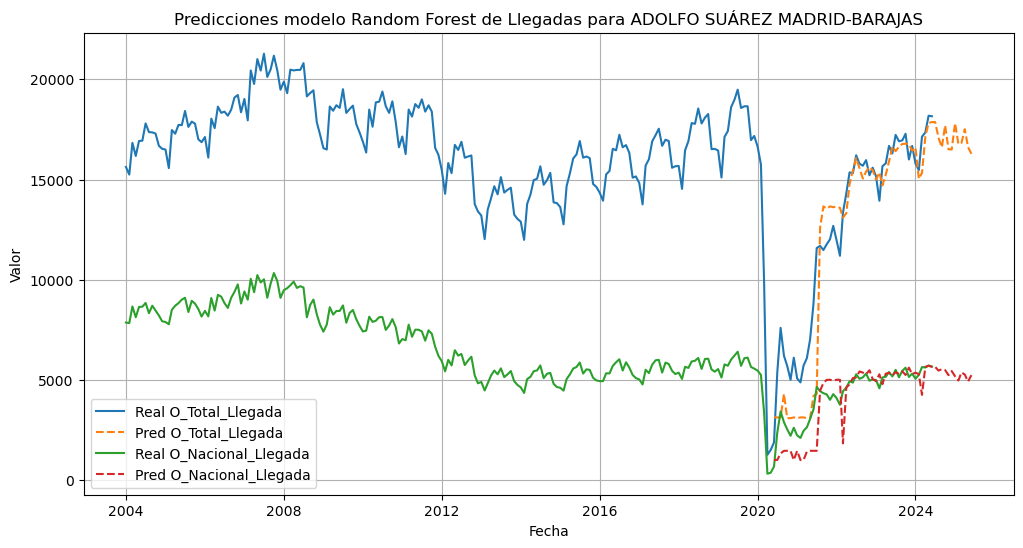

In [99]:
# Se visualizan las predicciones para un aeropuerto específico
Aeropuerto_Prediccion = 'ADOLFO SUÁREZ MADRID-BARAJAS'

# Se filtran los tipos de operación disponibles para el aeropuerto seleccionado
Tipos_Operacion = Operaciones_Unico[Operaciones_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion]['Tipo'].unique()

# Se filtran los tipos de operación para Llegada
Tipos_Llegada = [tipo for tipo in Tipos_Operacion if 'Llegada' in tipo]


# Gráfico para operaciones de Llegada
plt.figure(figsize=(12, 6))
for Tipo_Operacion_Prediccion in Tipos_Llegada:
    # Se filtran los datos reales para el tipo de operación
    Datos_Reales_Operacion_RF = Operaciones_Unico[(Operaciones_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                               (Operaciones_Unico['Tipo'] == Tipo_Operacion_Prediccion)]
    
    # Se filtran las predicciones para el tipo de operación
    Datos_Predicciones_Operacion_RF = Predicciones_Operaciones_RF[(Predicciones_Operaciones_RF['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                                            (Predicciones_Operaciones_RF['Tipo'] == Tipo_Operacion_Prediccion)]
    
    # Se añaden las series reales y predicciones al gráfico
    plt.plot(Datos_Reales_Operacion_RF.index, Datos_Reales_Operacion_RF['Valor'], label=f'Real {Tipo_Operacion_Prediccion}')
    plt.plot(Datos_Predicciones_Operacion_RF['Fecha'], Datos_Predicciones_Operacion_RF['Prediccion'], linestyle='--', label=f'Pred {Tipo_Operacion_Prediccion}')

# Se configura el gráfico
plt.title(f'Predicciones modelo Random Forest de Llegadas para {Aeropuerto_Prediccion}')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

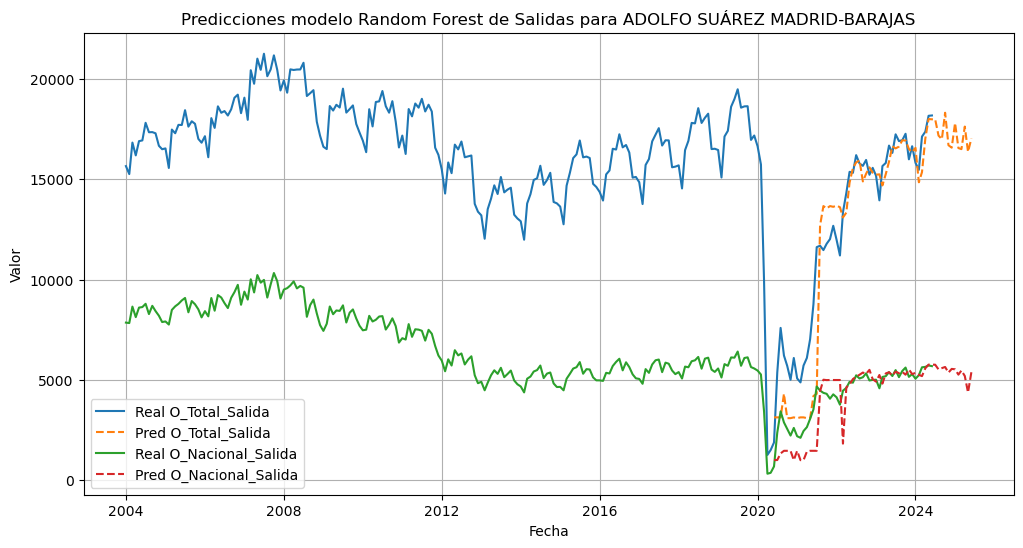

In [100]:
# Se visualizan las predicciones para un aeropuerto específico
Aeropuerto_Prediccion = 'ADOLFO SUÁREZ MADRID-BARAJAS'

# Se filtran los tipos de operación disponibles para el aeropuerto seleccionado
Tipos_Operacion = Operaciones_Unico[Operaciones_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion]['Tipo'].unique()

# Se filtran los tipos de operación para Llegada
Tipos_Salida = [tipo for tipo in Tipos_Operacion if 'Salida' in tipo]


# Gráfico para operaciones de Llegada
plt.figure(figsize=(12, 6))
for Tipo_Operacion_Prediccion in Tipos_Salida:
    # Se filtran los datos reales para el tipo de operación
    Datos_Reales_Operacion_RF = Operaciones_Unico[(Operaciones_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                               (Operaciones_Unico['Tipo'] == Tipo_Operacion_Prediccion)]
    
    # Se filtran las predicciones para el tipo de operación
    Datos_Predicciones_Operacion_RF = Predicciones_Operaciones_RF[(Predicciones_Operaciones_RF['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                                            (Predicciones_Operaciones_RF['Tipo'] == Tipo_Operacion_Prediccion)]
    
    # Se añaden las series reales y predicciones al gráfico
    plt.plot(Datos_Reales_Operacion_RF.index, Datos_Reales_Operacion_RF['Valor'], label=f'Real {Tipo_Operacion_Prediccion}')
    plt.plot(Datos_Predicciones_Operacion_RF['Fecha'], Datos_Predicciones_Operacion_RF['Prediccion'], linestyle='--', label=f'Pred {Tipo_Operacion_Prediccion}')

# Se configura el gráfico
plt.title(f'Predicciones modelo Random Forest de Salidas para {Aeropuerto_Prediccion}')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

**7-d. Métricas de error**

In [39]:
# Se crea un DataFrame para almacenar las métricas de error
Metricas_Error_Operaciones_RF = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'MAE', 'RMSE', 'MAPE'])

# Se itera sobre las combinaciones de aeropuerto y tipo de operación
for (Aeropuerto, Operacion), (Predicciones_Originales_RF, _, Fechas_Reales) in Dicc_Predicciones_Operaciones_RF.items():
    # Se obtienen los valores reales
    Valores_Reales_Operacion_RF = Operaciones_Unico[(Operaciones_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                       (Operaciones_Unico['Tipo'] == Operacion)]['Valor'][-len(Predicciones_Originales_RF):]

     # Se calculan las métricas de error si hay valores reales para comparar
    if len(Valores_Reales_Operacion_RF) == len(Predicciones_Originales_RF):
        # MAE - Error Absoluto Medio
        mae = mean_absolute_error(Valores_Reales_Operacion_RF, Predicciones_Originales_RF)
        # RMSE - Error Cuatrático Medio
        rmse = np.sqrt(mean_squared_error(Valores_Reales_Operacion_RF, Predicciones_Originales_RF))
        # MAPE - Error Porcentual Absoluto Medio
        mape = np.mean(np.abs((Valores_Reales_Operacion_RF - Predicciones_Originales_RF) / Valores_Reales_Operacion_RF)) * 100

        # Se almacenan las métricas en el DataFrame
        Temp_Metricas_Error_RF = pd.DataFrame({
            'Aeropuerto_Base': [Aeropuerto],
            'Tipo': [Operacion],
            'MAE': [mae],
            'RMSE': [rmse],
            'MAPE': [mape]
        })
       
        # Se concatenan las métricas de error
        Metricas_Error_Operaciones_RF = pd.concat([Metricas_Error_Operaciones_RF, Temp_Metricas_Error_RF], ignore_index=True) 
    else:
        print(f"Las longitudes no coinciden para {Aeropuerto} - {Operacion}")

# Se muestran las métricas
print(Metricas_Error_Operaciones_RF)

                  Aeropuerto_Base                Tipo          MAE  \
0                        A CORUÑA     O_Total_Llegada    61.463878   
1                        A CORUÑA  O_Nacional_Llegada    57.843265   
2                        A CORUÑA      O_Total_Salida    64.225714   
3                        A CORUÑA   O_Nacional_Salida    52.352857   
4    ADOLFO SUÁREZ MADRID-BARAJAS     O_Total_Llegada  1407.564898   
..                            ...                 ...          ...   
191         ALGECIRAS /HELIPUERTO   O_Nacional_Salida    16.972245   
192              MURCIA COMBINADO     O_Total_Llegada    70.727755   
193              MURCIA COMBINADO  O_Nacional_Llegada    15.577755   
194              MURCIA COMBINADO      O_Total_Salida    71.300000   
195              MURCIA COMBINADO   O_Nacional_Salida    15.609184   

            RMSE       MAPE  
0      77.678535  11.497032  
1      72.752458  11.055443  
2      78.178280  11.860114  
3      69.290295  10.231061  
4    1994

**7-e. Métricas de error promedias de todo el conjunto**

In [40]:
# Se calculan las métricas medias para este modelo 
MAE_promedio_RF = Metricas_Error_Operaciones_RF['MAE'].mean()
RMSE_promedio_RF = Metricas_Error_Operaciones_RF['RMSE'].mean()
MAPE_promedio_RF = Metricas_Error_Operaciones_RF['MAPE'].mean()

# Se muestran los resultados Random Forest
print(f"MAE Promedio Random Forest: {MAE_promedio_RF}")
print(f"RMSE Promedio Random Forest: {RMSE_promedio_RF}")
print(f"MAPE Promedio Random Forest: {MAPE_promedio_RF}%")

MAE Promedio Random Forest: 200.2790017680852
RMSE Promedio Random Forest: 266.88269632295385
MAPE Promedio Random Forest: 23.813752453265497%


Como se puede comprobar, es el primer modelo en el que las métricas han empeorado, por lo que se van a ajustar los hiperparámetros para tratar de conseguir mejores resultados que los obtenidos en el modelo Holt-Winters Aditivo.

**8. Modelo Random Forest con Random Search - 2 intento**

Se prueba otro Random Forest pero esta vez con el Random Search, para obtener los hiperparámetros de manera aleatoria

In [41]:
#Se crea un diccionario para almacenar las predicciones
Dicc_Predicciones_Operaciones_RF2 = {}

# Función para crear variables lag
# Los lags permiten capturar patrones y dependencias en los datos pasados para mejorar la precisión de valores futuros
def crear_lags(data, lags):
    df_lags = pd.DataFrame()
    for lag in range(1, lags + 1):
        df_lags[f'lag_{lag}'] = data.shift(lag)
    df_lags['Valor'] = data.values
    return df_lags.dropna()

# Se definen los posibles hiperparámetros del modelo para RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Se obtienen todos los aeropuertos y tipos únicos
Aeropuertos = Operaciones_Unico['Aeropuerto_Base'].unique()
Tipos_Operacion = Operaciones_Unico['Tipo'].unique()

# Se itera sobre cada aeropuerto y tipo
for Aeropuerto in Aeropuertos:
    for Operacion in Tipos_Operacion:
        # Se filtra cada aeropuerto y tipo de operación para los datos originales "reales"
        Datos_Reales_Operacion_RF2 = Operaciones_Unico[(Operaciones_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                                   (Operaciones_Unico['Tipo'] == Operacion)]
        
        # Se comprueba que está ordenado cronológicamente
        Datos_Reales_Operacion_RF2 = Datos_Reales_Operacion_RF2.sort_index()

        # Se crean las variables lag 
        lags = 3
        data_lags_RF2 = crear_lags(Datos_Reales_Operacion_RF2['Valor'], lags)
        
        # Se separa el conjunto en entrenamiento (80%) y test (20%)
        X = data_lags_RF2.drop(columns=['Valor'])
        y = data_lags_RF2['Valor']
        X_train_RF2, X_test_RF2, y_train_RF2, y_test_RF2 = train_test_split(X, y, test_size=0.2, shuffle=False)
        
        # Se aplica RandomizedSearchCV para encontrar los mejores hiperparámetros
        try:
            model_RF2 = RandomForestRegressor(random_state=42)
            random_search = RandomizedSearchCV(model_RF2, param_distributions=param_dist, n_iter=50, cv=3, verbose=2, random_state=42, n_jobs=-1)
            random_search.fit(X_train_RF2, y_train_RF2)

            # Se entrena el modelo con los mejores hiperparámetros encontrados
            best_rf_model = random_search.best_estimator_

            # Se realiza las predicciones sobre los datos históricos
            Predicciones_Originales_RF2 = best_rf_model.predict(X_test_RF2)
            
            # Se realiza las predicciones futuras, pero es necesario construir las características de manera iterativa
            last_values = X_test_RF2.iloc[-1].values
            Predicciones_Futuras_RF2 = []
            for _ in range(12):
                next_pred = best_rf_model.predict(pd.DataFrame([last_values], columns=X.columns))
                Predicciones_Futuras_RF2.append(next_pred[0])
                last_values = np.roll(last_values, -1)
                last_values[-1] = next_pred[0]  # Extraer el valor escalar de next_pred

            # Se convierten las predicciones futuras en un array de pandas
            Predicciones_Futuras_RF2 = pd.Series(Predicciones_Futuras_RF2)

            # Se almacenan las predicciones en el diccionario
            Dicc_Predicciones_Operaciones_RF2[(Aeropuerto, Operacion)] = (Predicciones_Originales_RF2, Predicciones_Futuras_RF2, Datos_Reales_Operacion_RF2.index[-len(Predicciones_Originales_RF2):])
        
        except Exception as e:
            print(f"Error al entrenar el modelo para {Aeropuerto}, {Operacion}: {e}")

# Se muestra el mejor conjunto de parámetros
print(f"Mejor conjunto de parámetros: {random_search.best_params_}")

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 

**8-a. Dataframe en el que se guardan las predicciones y los datos reales**

In [42]:
# Se crea un dataframe para poder comparar las predicciones
Comparacion_Total_Todos_Aeropuertos_RF2 = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'Fecha', 'Valor Real', 'Prediccion'])

for (Aeropuerto, Operacion), (Predicciones_Originales_RF2, Predicciones_Futuras_RF2, Fechas_Reales) in Dicc_Predicciones_Operaciones_RF2.items():
    # Se extraen los valores reales coincidentes con las predicciones originales
    Valores_Reales_Operacion_RF2 = Operaciones_Unico[(Operaciones_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                        (Operaciones_Unico['Tipo'] == Operacion)].loc[Fechas_Reales, 'Valor']
    
    # Se comprueba que ambas longitudes coinciden
    min_len = min(len(Fechas_Reales), len(Predicciones_Originales_RF2), len(Valores_Reales_Operacion_RF2))
    
    # Se crea un DataFrame temporal para las predicciones históricas con los valores originales
    Tem_Predicciones_Historicas_RF2 = pd.DataFrame({
        'Aeropuerto_Base': [Aeropuerto] * min_len,
        'Tipo': [Operacion] * min_len,
        'Fecha': Fechas_Reales[:min_len],
        'Valor Real': Valores_Reales_Operacion_RF2[:min_len],
        'Prediccion': Predicciones_Originales_RF2[:min_len]
    })

    # Se filtran las columnas que contenga un NaN, en el caso de las históricas, son todas aquellas que pasan de la fecha de junio 2024
    Tem_Predicciones_Historicas_RF2 = Tem_Predicciones_Historicas_RF2.dropna(axis=1, how='all')

    # Se crea un DataFrame temporal para las predicciones futuras
    Fechas_Futuras = pd.date_range(start=Fechas_Reales[-1] + pd.offsets.MonthBegin(1), periods=len(Predicciones_Futuras_RF2), freq='MS')
    Temp_Predicciones_Futuras_RF2 = pd.DataFrame({
        'Aeropuerto_Base': [Aeropuerto] * len(Predicciones_Futuras_RF2),
        'Tipo': [Operacion] * len(Predicciones_Futuras_RF2),
        'Fecha': Fechas_Futuras,
        'Valor Real': [None] * len(Predicciones_Futuras_RF2),
        'Prediccion': Predicciones_Futuras_RF2
    })

    # Se filtran las columnas que contenga un NaN
    Temp_Predicciones_Futuras_RF2 = Temp_Predicciones_Futuras_RF2.dropna(axis=1, how='all')

    # Se concatena los dos dataframe (históricos y futuros)
    Comparacion_Total_Todos_Aeropuertos_RF2 = pd.concat([Comparacion_Total_Todos_Aeropuertos_RF2, Tem_Predicciones_Historicas_RF2, Temp_Predicciones_Futuras_RF2], ignore_index=True)

# Se muestran las últimas filas para ver los valores reales y predicciones
print(Comparacion_Total_Todos_Aeropuertos_RF2.tail(20))

        Aeropuerto_Base               Tipo      Fecha  Valor Real  Prediccion
11936  MURCIA COMBINADO  O_Nacional_Salida 2023-11-01        49.0   59.396600
11937  MURCIA COMBINADO  O_Nacional_Salida 2023-12-01        50.0   45.564471
11938  MURCIA COMBINADO  O_Nacional_Salida 2024-01-01        52.0   49.830884
11939  MURCIA COMBINADO  O_Nacional_Salida 2024-02-01        50.0   51.228239
11940  MURCIA COMBINADO  O_Nacional_Salida 2024-03-01        65.0   51.464053
11941  MURCIA COMBINADO  O_Nacional_Salida 2024-04-01        57.0   61.782421
11942  MURCIA COMBINADO  O_Nacional_Salida 2024-05-01       109.0   59.931584
11943  MURCIA COMBINADO  O_Nacional_Salida 2024-06-01        99.0   86.453825
11944  MURCIA COMBINADO  O_Nacional_Salida 2024-07-01         NaN   86.453825
11945  MURCIA COMBINADO  O_Nacional_Salida 2024-08-01         NaN   52.004088
11946  MURCIA COMBINADO  O_Nacional_Salida 2024-09-01         NaN   69.980093
11947  MURCIA COMBINADO  O_Nacional_Salida 2024-10-01         Na

**8-b. Métricas de error**

In [43]:
# Se crea un DataFrame para almacenar las métricas de error
Metricas_Error_Operaciones_RF2 = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'MAE', 'RMSE', 'MAPE'])

# Se itera sobre las combinaciones de aeropuerto y tipo de operación
for (Aeropuerto, Operacion), (Predicciones_Originales_RF2, _, Fechas_Reales) in Dicc_Predicciones_Operaciones_RF2.items():
    # Se obtienen los valores reales
    Valores_Reales_Operacion_RF2 = Operaciones_Unico[(Operaciones_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                       (Operaciones_Unico['Tipo'] == Operacion)]['Valor'][-len(Predicciones_Originales_RF2):]

     # Se calculan las métricas de error si hay valores reales para comparar
    if len(Valores_Reales_Operacion_RF2) == len(Predicciones_Originales_RF2):
        # MAE - Error Absoluto Medio
        mae = mean_absolute_error(Valores_Reales_Operacion_RF2, Predicciones_Originales_RF2)
        # RMSE - Error Cuatrático Medio
        rmse = np.sqrt(mean_squared_error(Valores_Reales_Operacion_RF2, Predicciones_Originales_RF2))
        # MAPE - Error Porcentual Absoluto Medio
        mape = np.mean(np.abs((Valores_Reales_Operacion_RF2 - Predicciones_Originales_RF2) / Valores_Reales_Operacion_RF2)) * 100

        # Se almacenan las métricas en el DataFrame
        Temp_Metricas_Error_RF2 = pd.DataFrame({
            'Aeropuerto_Base': [Aeropuerto],
            'Tipo': [Operacion],
            'MAE': [mae],
            'RMSE': [rmse],
            'MAPE': [mape]
        })
       
        # Se concatenan las métricas de error
        Metricas_Error_Operaciones_RF2 = pd.concat([Metricas_Error_Operaciones_RF2, Temp_Metricas_Error_RF2], ignore_index=True) 
    else:
        print(f"Las longitudes no coinciden para {Aeropuerto} - {Operacion}")

# Se muestran las métricas
print(Metricas_Error_Operaciones_RF2)

                  Aeropuerto_Base                Tipo         MAE  \
0                        A CORUÑA     O_Total_Llegada   68.943433   
1                        A CORUÑA  O_Nacional_Llegada   61.181162   
2                        A CORUÑA      O_Total_Salida   70.632898   
3                        A CORUÑA   O_Nacional_Salida   58.459830   
4    ADOLFO SUÁREZ MADRID-BARAJAS     O_Total_Llegada  990.649621   
..                            ...                 ...         ...   
191         ALGECIRAS /HELIPUERTO   O_Nacional_Salida   17.139383   
192              MURCIA COMBINADO     O_Total_Llegada   78.678289   
193              MURCIA COMBINADO  O_Nacional_Llegada   15.091344   
194              MURCIA COMBINADO      O_Total_Salida   80.301837   
195              MURCIA COMBINADO   O_Nacional_Salida   14.593320   

            RMSE       MAPE  
0      82.738367  12.841069  
1      74.837594  11.819252  
2      83.090472  13.229764  
3      73.004118  11.348822  
4    1394.821531  12.

**8-c. Métricas de error promedias de todo el conjunto**

In [44]:
# Se calculan las métricas medias para este modelo 
MAE_promedio_RF2 = Metricas_Error_Operaciones_RF2['MAE'].mean()
RMSE_promedio_RF2 = Metricas_Error_Operaciones_RF2['RMSE'].mean()
MAPE_promedio_RF2 = Metricas_Error_Operaciones_RF2['MAPE'].mean()

# Se muestran los resultados Random Forest - random search
print(f"MAE Promedio Random Forest - random search: {MAE_promedio_RF2}")
print(f"RMSE Promedio Random Forest - random search: {RMSE_promedio_RF2}")
print(f"MAPE Promedio Random Forest - random search: {MAPE_promedio_RF2}%")

MAE Promedio Random Forest - random search: 205.03404986538374
RMSE Promedio Random Forest - random search: 263.30561772028176
MAPE Promedio Random Forest - random search: 26.14353829117596%


En términos generales, este modelo ha empeorado con respecto al anterior tanto para las métricas de MAE como RMSE, por lo que también se descarta.

**9. Modelo XGBoost**

Se prueba otro modelo basado también en árboles de desición

In [45]:
# Se crea un diccionario para almacenar las predicciones
Dicc_Predicciones_Operaciones_XGB = {}

# Función para crear variables lag
# Los lags permiten capturar patrones y dependencias en los datos pasados para mejorar la precisión de valores futuros
def crear_lags(data, lags):
    df_lags = pd.DataFrame()
    for lag in range(1, lags + 1):
        df_lags[f'lag_{lag}'] = data.shift(lag)
    df_lags['Valor'] = data.values
    return df_lags.dropna()

# Se definen los posibles hiperparámetros del modelo para RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Se obtienen todos los aeropuertos y tipos únicos
Aeropuertos = Operaciones_Unico['Aeropuerto_Base'].unique()
Tipos_Operacion = Operaciones_Unico['Tipo'].unique()

# Se itera sobre cada aeropuerto y tipo
for Aeropuerto in Aeropuertos:
    for Operacion in Tipos_Operacion:
        # Se filtra cada aeropuerto y tipo de operación para los datos originales "reales"
        Datos_Reales_Operacion_XGB = Operaciones_Unico[(Operaciones_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                                   (Operaciones_Unico['Tipo'] == Operacion)]
        
        # Se comprueba que está ordenado cronológicamente
        Datos_Reales_Operacion_XGB = Datos_Reales_Operacion_XGB.sort_index()

        # Se crean las variables lag 
        lags = 3
        data_lags_XGB = crear_lags(Datos_Reales_Operacion_XGB['Valor'], lags)
        
        # Se separa el conjunto en entrenamiento (80%) y test (20%)
        X = data_lags_XGB.drop(columns=['Valor'])
        y = data_lags_XGB['Valor']
        X_train_XGB, X_test_XGB, y_train_XGB, y_test_XGB = train_test_split(X, y, test_size=0.2, shuffle=False)
        
        # Se aplica RandomizedSearchCV para encontrar los mejores hiperparámetros
        try:
            model_XGB = XGBRegressor(random_state=42, objective='reg:squarederror')
            random_search = RandomizedSearchCV(model_XGB, param_distributions=param_dist, n_iter=50, cv=3, verbose=2, random_state=42, n_jobs=-1)
            random_search.fit(X_train_XGB, y_train_XGB)

            # Se entrena el modelo con los mejores hiperparámetros encontrados
            best_xgb_model = random_search.best_estimator_

            # Se realiza las predicciones sobre los datos históricos
            Predicciones_Originales_XGB = best_xgb_model.predict(X_test_XGB)
            
            # Se realiza las predicciones futuras, pero es necesario construir las características de manera iterativa
            last_values = X_test_XGB.iloc[-1].values
            Predicciones_Futuras_XGB = []
            for _ in range(12):
                next_pred = best_xgb_model.predict(pd.DataFrame([last_values], columns=X.columns))
                Predicciones_Futuras_XGB.append(next_pred[0])
                last_values = np.roll(last_values, -1)
                last_values[-1] = next_pred[0]  # Extraer el valor escalar de next_pred

            # Se convierten las predicciones futuras en un array de pandas
            Predicciones_Futuras_XGB = pd.Series(Predicciones_Futuras_XGB)

            # Se almacenan las predicciones en el diccionario
            Dicc_Predicciones_Operaciones_XGB[(Aeropuerto, Operacion)] = (Predicciones_Originales_XGB, Predicciones_Futuras_XGB, Datos_Reales_Operacion_XGB.index[-len(Predicciones_Originales_XGB):])
        
        except Exception as e:
            print(f"Error al entrenar el modelo para {Aeropuerto}, {Operacion}: {e}")

# Se muestra el mejor conjunto de parámetros
print(f"Mejor conjunto de parámetros: {random_search.best_params_}")

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 

**9-a. Dataframe en el que se guardan las predicciones y los datos reales**

In [46]:
# Se crea un dataframe para poder comparar las predicciones
Comparacion_Total_Todos_Aeropuertos_XGB = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'Fecha', 'Valor Real', 'Prediccion'])

for (Aeropuerto, Operacion), (Predicciones_Originales_XGB, Predicciones_Futuras_XGB, Fechas_Reales) in Dicc_Predicciones_Operaciones_XGB.items():
    # Se extraen los valores reales coincidentes con las predicciones originales
    Valores_Reales_Operacion_XGB = Operaciones_Unico[(Operaciones_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                        (Operaciones_Unico['Tipo'] == Operacion)].loc[Fechas_Reales, 'Valor']
    
    # Se comprueba que ambas longitudes coinciden
    min_len = min(len(Fechas_Reales), len(Predicciones_Originales_XGB), len(Valores_Reales_Operacion_XGB))
    
    # Se crea un DataFrame temporal para las predicciones históricas con los valores originales
    Tem_Predicciones_Historicas_XGB = pd.DataFrame({
        'Aeropuerto_Base': [Aeropuerto] * min_len,
        'Tipo': [Operacion] * min_len,
        'Fecha': Fechas_Reales[:min_len],
        'Valor Real': Valores_Reales_Operacion_XGB[:min_len],
        'Prediccion': Predicciones_Originales_XGB[:min_len]
    })

    # Se filtran las columnas que contenga un NaN, en el caso de las históricas, son todas aquellas que pasan de la fecha de junio 2024
    Tem_Predicciones_Historicas_XGB = Tem_Predicciones_Historicas_XGB.dropna(axis=1, how='all')

    # Se crea un DataFrame temporal para las predicciones futuras
    Fechas_Futuras = pd.date_range(start=Fechas_Reales[-1] + pd.offsets.MonthBegin(1), periods=len(Predicciones_Futuras_XGB), freq='MS')
    Temp_Predicciones_Futuras_XGB = pd.DataFrame({
        'Aeropuerto_Base': [Aeropuerto] * len(Predicciones_Futuras_XGB),
        'Tipo': [Operacion] * len(Predicciones_Futuras_XGB),
        'Fecha': Fechas_Futuras,
        'Valor Real': [None] * len(Predicciones_Futuras_XGB),
        'Prediccion': Predicciones_Futuras_XGB
    })

    # Se filtran las columnas que contenga un NaN
    Temp_Predicciones_Futuras_XGB = Temp_Predicciones_Futuras_XGB.dropna(axis=1, how='all')

    # Se concatena los dos dataframe (históricos y futuros)
    Comparacion_Total_Todos_Aeropuertos_XGB = pd.concat([Comparacion_Total_Todos_Aeropuertos_XGB, Tem_Predicciones_Historicas_XGB, Temp_Predicciones_Futuras_XGB], ignore_index=True)

# Se muestran las últimas filas para ver los valores reales y predicciones
print(Comparacion_Total_Todos_Aeropuertos_XGB.tail(20))

        Aeropuerto_Base               Tipo      Fecha  Valor Real  Prediccion
11936  MURCIA COMBINADO  O_Nacional_Salida 2023-11-01        49.0   51.483273
11937  MURCIA COMBINADO  O_Nacional_Salida 2023-12-01        50.0   43.767429
11938  MURCIA COMBINADO  O_Nacional_Salida 2024-01-01        52.0   50.285213
11939  MURCIA COMBINADO  O_Nacional_Salida 2024-02-01        50.0   49.643566
11940  MURCIA COMBINADO  O_Nacional_Salida 2024-03-01        65.0   50.678398
11941  MURCIA COMBINADO  O_Nacional_Salida 2024-04-01        57.0   61.445404
11942  MURCIA COMBINADO  O_Nacional_Salida 2024-05-01       109.0   65.280663
11943  MURCIA COMBINADO  O_Nacional_Salida 2024-06-01        99.0   96.090881
11944  MURCIA COMBINADO  O_Nacional_Salida 2024-07-01         NaN   96.090881
11945  MURCIA COMBINADO  O_Nacional_Salida 2024-08-01         NaN   49.527153
11946  MURCIA COMBINADO  O_Nacional_Salida 2024-09-01         NaN   60.798279
11947  MURCIA COMBINADO  O_Nacional_Salida 2024-10-01         Na

**9-b. Métricas de error**

In [47]:
# Se crea un DataFrame para almacenar las métricas de error
Metricas_Error_Operaciones_XGB = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'MAE', 'RMSE', 'MAPE'])

# Se itera sobre las combinaciones de aeropuerto y tipo de operación
for (Aeropuerto, Operacion), (Predicciones_Originales_XGB, _, Fechas_Reales) in Dicc_Predicciones_Operaciones_XGB.items():
    # Se obtienen los valores reales
    Valores_Reales_Operacion_XGB = Operaciones_Unico[(Operaciones_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                       (Operaciones_Unico['Tipo'] == Operacion)]['Valor'][-len(Predicciones_Originales_XGB):]

     # Se calculan las métricas de error si hay valores reales para comparar
    if len(Valores_Reales_Operacion_XGB) == len(Predicciones_Originales_XGB):
        # MAE - Error Absoluto Medio
        mae = mean_absolute_error(Valores_Reales_Operacion_XGB, Predicciones_Originales_XGB)
        # RMSE - Error Cuatrático Medio
        rmse = np.sqrt(mean_squared_error(Valores_Reales_Operacion_XGB, Predicciones_Originales_XGB))
        # MAPE - Error Porcentual Absoluto Medio
        mape = np.mean(np.abs((Valores_Reales_Operacion_XGB - Predicciones_Originales_XGB) / Valores_Reales_Operacion_XGB)) * 100

        # Se almacenan las métricas en el DataFrame
        Temp_Metricas_Error_XGB = pd.DataFrame({
            'Aeropuerto_Base': [Aeropuerto],
            'Tipo': [Operacion],
            'MAE': [mae],
            'RMSE': [rmse],
            'MAPE': [mape]
        })
       
        # Se concatenan las métricas de error
        Metricas_Error_Operaciones_XGB = pd.concat([Metricas_Error_Operaciones_XGB, Temp_Metricas_Error_XGB], ignore_index=True) 
    else:
        print(f"Las longitudes no coinciden para {Aeropuerto} - {Operacion}")

# Se muestran las métricas
print(Metricas_Error_Operaciones_XGB)

                  Aeropuerto_Base                Tipo          MAE  \
0                        A CORUÑA     O_Total_Llegada    62.314072   
1                        A CORUÑA  O_Nacional_Llegada    56.783348   
2                        A CORUÑA      O_Total_Salida    70.938163   
3                        A CORUÑA   O_Nacional_Salida    54.435745   
4    ADOLFO SUÁREZ MADRID-BARAJAS     O_Total_Llegada  1943.279526   
..                            ...                 ...          ...   
191         ALGECIRAS /HELIPUERTO   O_Nacional_Salida    18.307408   
192              MURCIA COMBINADO     O_Total_Llegada    65.399111   
193              MURCIA COMBINADO  O_Nacional_Llegada    15.653811   
194              MURCIA COMBINADO      O_Total_Salida    54.560390   
195              MURCIA COMBINADO   O_Nacional_Salida    15.086465   

            RMSE       MAPE  
0      78.862164  12.336667  
1      69.666037  11.412479  
2      85.715510  14.115867  
3      67.099230  10.943563  
4    2860

**9-c. Métricas de error promedias de todo el conjunto**

In [48]:
# Se calculan las métricas medias para este modelo 
MAE_promedio_XGB = Metricas_Error_Operaciones_XGB['MAE'].mean()
RMSE_promedio_XGB = Metricas_Error_Operaciones_XGB['RMSE'].mean()
MAPE_promedio_XGB = Metricas_Error_Operaciones_XGB['MAPE'].mean()

# Se muestran los resultados XGBoost - random search
print(f"MAE Promedio XGBoost - random search: {MAE_promedio_XGB}")
print(f"RMSE Promedio XGBoost - random search: {RMSE_promedio_XGB}")
print(f"MAPE Promedio XGBoost - random search: {MAPE_promedio_XGB}%")

MAE Promedio XGBoost - random search: 227.83834100347772
RMSE Promedio XGBoost - random search: 300.89151192423924
MAPE Promedio XGBoost - random search: inf%


Al igual que los últimos modelos que se han ido probando, éstos han empeorado la precisión de las predicciones.

**10. Modelo Autoarima**

El último modelo que se va a probar es el AutoARIMA

In [49]:
import pandas as pd
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Se crea un diccionario para almacenar las predicciones
Dicc_Predicciones_AutoARIMA = {}

# Se obtienen todos los aeropuertos y tipos únicos
Aeropuertos = Operaciones_Unico['Aeropuerto_Base'].unique()
Tipos_Operacion = Operaciones_Unico['Tipo'].unique()

# Se itera sobre cada aeropuerto y tipo
for Aeropuerto in Aeropuertos:
    for Operacion in Tipos_Operacion:
        # Se filtra cada aeropuerto y tipo de operación para los datos originales "reales"
        Datos_Reales_Operacion_ARIMA = Operaciones_Unico[(Operaciones_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                                         (Operaciones_Unico['Tipo'] == Operacion)]
        
        # Se comprueba que está ordenado cronológicamente
        Datos_Reales_Operacion_ARIMA = Datos_Reales_Operacion_ARIMA.sort_index()

        # Se entrena el modelo AutoARIMA
        try:
            model_auto_arima = auto_arima(Datos_Reales_Operacion_ARIMA['Valor'], 
                                          seasonal=False, 
                                          stepwise=True, 
                                          trace=True, 
                                          error_action='ignore', 
                                          suppress_warnings=True)
            
            # Se realizan predicciones sobre los datos históricos
            Predicciones_Originales_ARIMA = model_auto_arima.predict_in_sample()
            
            # Se realizan predicciones para fechas futuras, 12 meses por ejemplo
            Predicciones_Futuras_ARIMA = model_auto_arima.predict(n_periods=12)

            # Se almacenan las predicciones en el diccionario
            Dicc_Predicciones_AutoARIMA[(Aeropuerto, Operacion)] = (Predicciones_Originales_ARIMA, Predicciones_Futuras_ARIMA, Datos_Reales_Operacion_ARIMA.index)
        
        except Exception as e:
            print(f"Error al entrenar el modelo AutoARIMA para {Aeropuerto}, {Operacion}: {e}")

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2851.670, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2853.565, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2853.571, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2849.684, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.787 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3843.197, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=3560.639, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2851.008, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.18 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=2853.002, Time=0.05 sec
 ARI

**10-a. Dataframe en el que se guardan las predicciones y los datos reales**

In [50]:
# Se crea un dataframe para poder comparar las predicciones
Comparacion_Total_Todos_Aeropuertos_AutoARIMA = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'Fecha', 'Valor Real', 'Prediccion'])

for (Aeropuerto, Operacion), (Predicciones_Originales_ARIMA, Predicciones_Futuras_ARIMA, Fechas_Reales) in Dicc_Predicciones_AutoARIMA.items():
    # Se extraen los valores reales coincidentes con las predicciones originales
    Valores_Reales_Operacion_AutoARIMA = Operaciones_Unico[(Operaciones_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                        (Operaciones_Unico['Tipo'] == Operacion)].loc[Fechas_Reales, 'Valor']
    
    # Se comprueba que ambas longitudes coinciden
    min_len = min(len(Fechas_Reales), len(Predicciones_Originales_ARIMA), len(Valores_Reales_Operacion_AutoARIMA))
    
    # Se crea un DataFrame temporal para las predicciones históricas con los valores originales
    Tem_Predicciones_Historicas_AutoARIMA = pd.DataFrame({
        'Aeropuerto_Base': [Aeropuerto] * min_len,
        'Tipo': [Operacion] * min_len,
        'Fecha': Fechas_Reales[:min_len],
        'Valor Real': Valores_Reales_Operacion_AutoARIMA[:min_len],
        'Prediccion': Predicciones_Originales_ARIMA[:min_len]
    })

    # Se filtran las columnas que contenga un NaN, en el caso de las históricas, son todas aquellas que pasan de la fecha de junio 2024
    Tem_Predicciones_Historicas_AutoARIMA = Tem_Predicciones_Historicas_AutoARIMA.dropna(axis=1, how='all')

    # Se crea un DataFrame temporal para las predicciones futuras
    Fechas_Futuras = pd.date_range(start=Fechas_Reales[-1] + pd.offsets.MonthBegin(1), periods=len(Predicciones_Futuras_ARIMA), freq='MS')
    Temp_Predicciones_Futuras_AutoARIMA = pd.DataFrame({
        'Aeropuerto_Base': [Aeropuerto] * len(Predicciones_Futuras_ARIMA),
        'Tipo': [Operacion] * len(Predicciones_Futuras_ARIMA),
        'Fecha': Fechas_Futuras,
        'Valor Real': [None] * len(Predicciones_Futuras_ARIMA),
        'Prediccion': Predicciones_Futuras_ARIMA
    })

    # Se filtran las columnas que contenga un NaN
    Temp_Predicciones_Futuras_AutoARIMA = Temp_Predicciones_Futuras_AutoARIMA.dropna(axis=1, how='all')

    # Se concatena los dos dataframe (históricos y futuros)
    Comparacion_Total_Todos_Aeropuertos_AutoARIMA = pd.concat([Comparacion_Total_Todos_Aeropuertos_AutoARIMA, Tem_Predicciones_Historicas_AutoARIMA, Temp_Predicciones_Futuras_AutoARIMA], ignore_index=True)

# Se muestran las últimas filas para ver los valores reales y predicciones
print(Comparacion_Total_Todos_Aeropuertos_AutoARIMA.tail(20))

        Aeropuerto_Base               Tipo      Fecha  Valor Real  Prediccion
50548  MURCIA COMBINADO  O_Nacional_Salida 2023-11-01        49.0   35.683356
50549  MURCIA COMBINADO  O_Nacional_Salida 2023-12-01        50.0   29.024146
50550  MURCIA COMBINADO  O_Nacional_Salida 2024-01-01        52.0   35.360190
50551  MURCIA COMBINADO  O_Nacional_Salida 2024-02-01        50.0   34.509551
50552  MURCIA COMBINADO  O_Nacional_Salida 2024-03-01        65.0   55.410516
50553  MURCIA COMBINADO  O_Nacional_Salida 2024-04-01        57.0   59.269651
50554  MURCIA COMBINADO  O_Nacional_Salida 2024-05-01       109.0   76.738492
50555  MURCIA COMBINADO  O_Nacional_Salida 2024-06-01        99.0   94.165332
50556  MURCIA COMBINADO  O_Nacional_Salida 2024-07-01         NaN   91.877644
50557  MURCIA COMBINADO  O_Nacional_Salida 2024-08-01         NaN   89.586744
50558  MURCIA COMBINADO  O_Nacional_Salida 2024-09-01         NaN   76.942512
50559  MURCIA COMBINADO  O_Nacional_Salida 2024-10-01         Na

**10-b.Visualización de las predicciones**

In [71]:
# Se crea un DataFrame para almacenar todas las predicciones
Predicciones_Operaciones_AutoARIMA = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'Fecha', 'Prediccion'])

for (Aeropuerto, Operacion), (Predicciones_Originales_ARIMA, Predicciones_Futuras_ARIMA, Fechas_Reales) in Dicc_Predicciones_AutoARIMA.items():
    # Se guardan en un DataFrame temporal para las predicciones de los datos orginales "reales"
    Tem_Predicciones_Historicas_AutoARIMA = pd.DataFrame({
        'Aeropuerto_Base': Aeropuerto,
        'Tipo': Operacion,
        'Fecha': Fechas_Reales,
        'Prediccion': Predicciones_Originales_ARIMA
    })

    # Se guardan en un DataFrame temporal para las predicciones de fechas futuras
    Fechas_Futuras = pd.date_range(start=Fechas_Reales[-1] + pd.offsets.MonthBegin(1), periods=len(Predicciones_Futuras_ARIMA), freq='MS')
    Temp_Predicciones_Futuras_AutoARIMA = pd.DataFrame({
        'Aeropuerto_Base': Aeropuerto,
        'Tipo': Operacion,
        'Fecha': Fechas_Futuras,
        'Prediccion': Predicciones_Futuras_ARIMA
    })

    # Se concatenan ambas predicciones y se guardan en un dataframe único
    Predicciones_Operaciones_AutoARIMA = pd.concat([Predicciones_Operaciones_AutoARIMA, Tem_Predicciones_Historicas_AutoARIMA, Temp_Predicciones_Futuras_AutoARIMA], ignore_index=True)

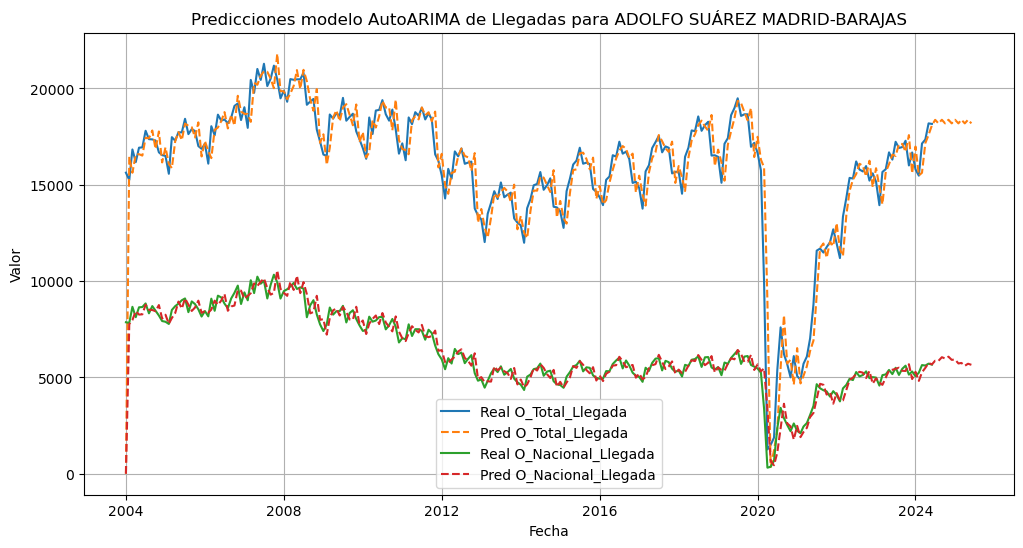

In [101]:
# Se visualizan las predicciones para un aeropuerto específico
Aeropuerto_Prediccion = 'ADOLFO SUÁREZ MADRID-BARAJAS'

# Se filtran los tipos de operación disponibles para el aeropuerto seleccionado
Tipos_Operacion = Operaciones_Unico[Operaciones_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion]['Tipo'].unique()

# Se filtran los tipos de operación para Llegada
Tipos_Llegada = [tipo for tipo in Tipos_Operacion if 'Llegada' in tipo]


# Gráfico para operaciones de Llegada
plt.figure(figsize=(12, 6))
for Tipo_Operacion_Prediccion in Tipos_Llegada:
    # Se filtran los datos reales para el tipo de operación
    Datos_Reales_Operacion_AutoARIMA = Operaciones_Unico[(Operaciones_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                               (Operaciones_Unico['Tipo'] == Tipo_Operacion_Prediccion)]
    
    # Se filtran las predicciones para el tipo de operación
    Datos_Predicciones_Operacion_AutoARIMA = Predicciones_Operaciones_AutoARIMA[(Predicciones_Operaciones_AutoARIMA['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                                            (Predicciones_Operaciones_AutoARIMA['Tipo'] == Tipo_Operacion_Prediccion)]
    
    # Se añaden las series reales y predicciones al gráfico
    plt.plot(Datos_Reales_Operacion_AutoARIMA.index, Datos_Reales_Operacion_AutoARIMA['Valor'], label=f'Real {Tipo_Operacion_Prediccion}')
    plt.plot(Datos_Predicciones_Operacion_AutoARIMA['Fecha'], Datos_Predicciones_Operacion_AutoARIMA['Prediccion'], linestyle='--', label=f'Pred {Tipo_Operacion_Prediccion}')

# Se configura el gráfico
plt.title(f'Predicciones modelo AutoARIMA de Llegadas para {Aeropuerto_Prediccion}')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

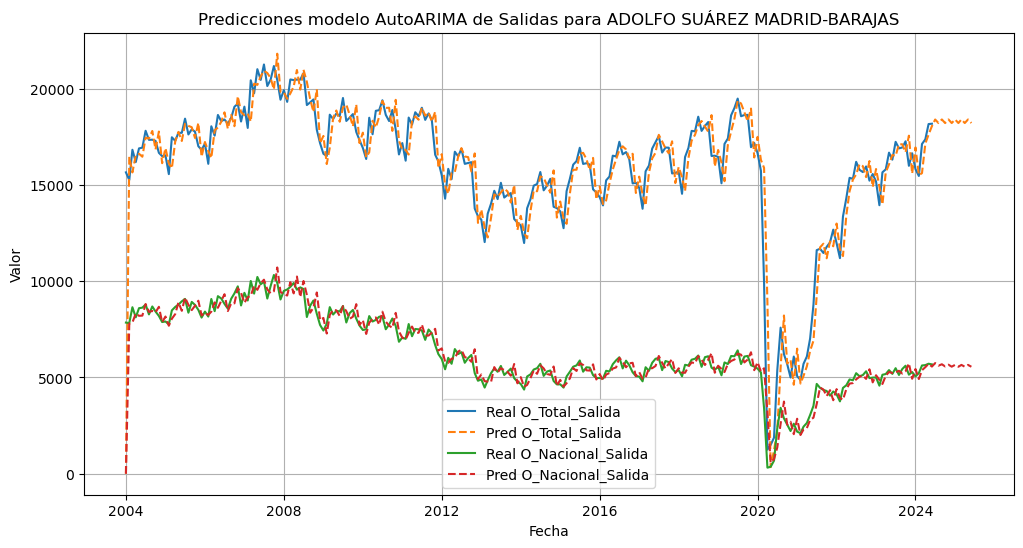

In [102]:
# Se visualizan las predicciones para un aeropuerto específico
Aeropuerto_Prediccion = 'ADOLFO SUÁREZ MADRID-BARAJAS'

# Se filtran los tipos de operación disponibles para el aeropuerto seleccionado
Tipos_Operacion = Operaciones_Unico[Operaciones_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion]['Tipo'].unique()

# Se filtran los tipos de operación para Salida
Tipos_Salida = [tipo for tipo in Tipos_Operacion if 'Salida' in tipo]


# Gráfico para operaciones de Llegada
plt.figure(figsize=(12, 6))
for Tipo_Operacion_Prediccion in Tipos_Salida:
    # Se filtran los datos reales para el tipo de operación
    Datos_Reales_Operacion_AutoARIMA = Operaciones_Unico[(Operaciones_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                               (Operaciones_Unico['Tipo'] == Tipo_Operacion_Prediccion)]
    
    # Se filtran las predicciones para el tipo de operación
    Datos_Predicciones_Operacion_AutoARIMA = Predicciones_Operaciones_AutoARIMA[(Predicciones_Operaciones_AutoARIMA['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                                            (Predicciones_Operaciones_AutoARIMA['Tipo'] == Tipo_Operacion_Prediccion)]
    
    # Se añaden las series reales y predicciones al gráfico
    plt.plot(Datos_Reales_Operacion_AutoARIMA.index, Datos_Reales_Operacion_AutoARIMA['Valor'], label=f'Real {Tipo_Operacion_Prediccion}')
    plt.plot(Datos_Predicciones_Operacion_AutoARIMA['Fecha'], Datos_Predicciones_Operacion_AutoARIMA['Prediccion'], linestyle='--', label=f'Pred {Tipo_Operacion_Prediccion}')

# Se configura el gráfico
plt.title(f'Predicciones modelo AutoARIMA de Salidas para {Aeropuerto_Prediccion}')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

**10-c. Métricas de error**

In [51]:
# Se crea un DataFrame para almacenar las métricas de error
Metricas_Error_Operaciones_AutoARIMA = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'MAE', 'RMSE', 'MAPE'])

# Se itera sobre las combinaciones de aeropuerto y tipo de operación
for (Aeropuerto, Operacion), (Predicciones_Originales_ARIMA, _, Fechas_Reales) in Dicc_Predicciones_AutoARIMA.items():
    # Se obtienen los valores reales
    Valores_Reales_Operacion_AutoARIMA = Operaciones_Unico[(Operaciones_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                       (Operaciones_Unico['Tipo'] == Operacion)]['Valor']
    
    # Se calculan las métricas de error si hay valores reales para comparar
    if len(Valores_Reales_Operacion_AutoARIMA) == len(Predicciones_Originales_ARIMA):
        # MAE - Error Absoluto Medio
        mae = mean_absolute_error(Valores_Reales_Operacion_AutoARIMA, Predicciones_Originales_ARIMA)
        # RMSE - Error Cuatrático Medio
        rmse = np.sqrt(mean_squared_error(Valores_Reales_Operacion_AutoARIMA, Predicciones_Originales_ARIMA))
        # MAPE - Error Porcentual Absoluto Medio
        mape = np.mean(np.abs((Valores_Reales_Operacion_AutoARIMA - Predicciones_Originales_ARIMA) / Valores_Reales_Operacion_AutoARIMA)) * 100

        # Se almacenan las métricas en el DataFrame
        Temp_Metricas_Error_AutoARIMA = pd.DataFrame({
            'Aeropuerto_Base': [Aeropuerto],
            'Tipo': [Operacion],
            'MAE': [mae],
            'RMSE': [rmse],
            'MAPE': [mape]
        })
       
        # Se concatenan las métricas de error
        Metricas_Error_Operaciones_AutoARIMA = pd.concat([Metricas_Error_Operaciones_AutoARIMA, Temp_Metricas_Error_AutoARIMA], ignore_index=True) 

# Se muestran las métricas
print(Metricas_Error_Operaciones_AutoARIMA)

                  Aeropuerto_Base                Tipo         MAE  \
0                        A CORUÑA     O_Total_Llegada   64.284553   
1                        A CORUÑA  O_Nacional_Llegada   54.420406   
2                        A CORUÑA      O_Total_Salida   63.459350   
3                        A CORUÑA   O_Nacional_Salida   53.814542   
4    ADOLFO SUÁREZ MADRID-BARAJAS     O_Total_Llegada  777.566320   
..                            ...                 ...         ...   
191         ALGECIRAS /HELIPUERTO   O_Nacional_Salida    9.459350   
192              MURCIA COMBINADO     O_Total_Llegada   58.460346   
193              MURCIA COMBINADO  O_Nacional_Llegada   24.563223   
194              MURCIA COMBINADO      O_Total_Salida   58.033876   
195              MURCIA COMBINADO   O_Nacional_Salida   25.775592   

            RMSE       MAPE  
0      85.877347  13.256296  
1      72.061238  12.715846  
2      85.250349  13.170048  
3      71.233193  12.606826  
4    1467.788902   8.

**10-d. Métricas de error promedias de todo el conjunto**

In [52]:
# Se calculan las métricas medias para este modelo 
MAE_promedio_AutoARIMA = Metricas_Error_Operaciones_AutoARIMA['MAE'].mean()
RMSE_promedio_AutoARIMA = Metricas_Error_Operaciones_AutoARIMA['RMSE'].mean()
MAPE_promedio_AutoARIMA = Metricas_Error_Operaciones_AutoARIMA['MAPE'].mean()

# Se muestran los resultados AutoARIMA
print(f"MAE Promedio AutoARIMA: {MAE_promedio_AutoARIMA}")
print(f"RMSE Promedio AutoARIMA: {RMSE_promedio_AutoARIMA}")
print(f"MAPE Promedio AutoARIMA): {MAPE_promedio_AutoARIMA}%")

MAE Promedio AutoARIMA: 123.64265058567423
RMSE Promedio AutoARIMA: 183.0220766579695
MAPE Promedio AutoARIMA): inf%


Como ha mejorado con respecto a los Random Forest, XGBoost, se compara con el que mejor resultado se había obtenido hasta el momento, modelo Holt-Winters Aditivo:

- MAE Promedio Holt-Winters Aditivo: 86.91166157868858
- RMSE Promedio Holt-Winters Aditivo: 137.81195954419698- - 
MAPE Promedio Holt-Winters Aditivo: if%n

Lo que indica que las medidas en promedio han empeorado ligeramente, respecto a las anteriores%

**11. MPL Regressor**

In [8]:
# Se crea un diccionario para almacenar las predicciones
Dicc_Predicciones_Operaciones_MPL = {}

# Función para crear variables lag
def crear_lags(data, lags):
    df_lags = pd.DataFrame()
    for lag in range(1, lags + 1):
        df_lags[f'lag_{lag}'] = data.shift(lag)
    df_lags['Valor'] = data.values
    return df_lags.dropna()

# Se obtienen todos los aeropuertos y tipos únicos
Aeropuertos = Operaciones_Unico['Aeropuerto_Base'].unique()
Tipos_Operacion = Operaciones_Unico['Tipo'].unique()

# Se itera sobre cada aeropuerto y tipo
for Aeropuerto in Aeropuertos:
    for Operacion in Tipos_Operacion:
        # Se filtra cada aeropuerto y tipo de operación para los datos originales "reales"
        Datos_Reales_Operacion_MPL = Operaciones_Unico[(Operaciones_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                                   (Operaciones_Unico['Tipo'] == Operacion)]
        
        # Se comprueba que está ordenado cronológicamente
        Datos_Reales_Operacion_MPL = Datos_Reales_Operacion_MPL.sort_index()

        # Se crean las variables lag 
        lags = 3
        data_lags_MPL = crear_lags(Datos_Reales_Operacion_MPL['Valor'], lags)
        
        # Se Separa el conjunto en entrenamiento (80%) y test (20%)
        X = data_lags_MPL.drop(columns=['Valor'])
        y = data_lags_MPL['Valor']
        X_train_MPL, X_test_MPL, y_train_MPL, y_test_MPL = train_test_split(X, y, test_size=0.2, shuffle=False)
        
        # Entrenamiento y predicciones
        try:
            
            model_MPL = MLPRegressor(hidden_layer_sizes=(100,), activation='relu', solver='adam', random_state=42, max_iter=500)
            model_MPL.fit(X_train_MPL, y_train_MPL)

            # Predicciones sobre los datos históricos
            Predicciones_Originales_MPL = model_MPL.predict(X_test_MPL)

            # Predicciones futuras
            last_values = X_test_MPL.iloc[-1].values
            Predicciones_Futuras_MPL = []
            for _ in range(12):
                next_pred = model_MPL.predict(pd.DataFrame([last_values], columns=X.columns))
                Predicciones_Futuras_MPL.append(next_pred[0])
                last_values = np.roll(last_values, -1)
                last_values[-1] = next_pred[0]

            Predicciones_Futuras_MPL = pd.Series(Predicciones_Futuras_MPL)

            # Almacenar las predicciones en el diccionario
            Dicc_Predicciones_Operaciones_MPL[(Aeropuerto, Operacion)] = (Predicciones_Originales_MPL, Predicciones_Futuras_MPL, Datos_Reales_Operacion_MPL.index[-len(Predicciones_Originales_MPL):])

        except Exception as e:
            print(f"Error al entrenar el modelo para {Aeropuerto}, {Operacion}: {e}")

**11-a. Dataframe en el que se guardan las predicciones y los datos reales**

In [9]:
# Se crea un dataframe para poder comparar las predicciones
Comparacion_Total_Todos_Aeropuertos_MPL = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'Fecha', 'Valor Real', 'Prediccion'])

for (Aeropuerto, Operacion), (Predicciones_Originales_MPL, Predicciones_Futuras_MPL, Fechas_Reales) in Dicc_Predicciones_Operaciones_MPL.items():
    # Se extraen los valores reales coincidentes con las predicciones originales
    Valores_Reales_Operacion_MPL = Operaciones_Unico[(Operaciones_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                        (Operaciones_Unico['Tipo'] == Operacion)].loc[Fechas_Reales, 'Valor']
    
    # Se comprueba que ambas longitudes coinciden
    min_len = min(len(Fechas_Reales), len(Predicciones_Originales_MPL), len(Valores_Reales_Operacion_MPL))
    
    # Se crea un DataFrame temporal para las predicciones históricas con los valores originales
    Tem_Predicciones_Historicas_MPL = pd.DataFrame({
        'Aeropuerto_Base': [Aeropuerto] * min_len,
        'Tipo': [Operacion] * min_len,
        'Fecha': Fechas_Reales[:min_len],
        'Valor Real': Valores_Reales_Operacion_MPL[:min_len],
        'Prediccion': Predicciones_Originales_MPL[:min_len]
    })

    # Se filtran las columnas que contenga un NaN, en el caso de las históricas, son todas aquellas que pasan de la fecha de junio 2024
    Tem_Predicciones_Historicas_MPL = Tem_Predicciones_Historicas_MPL.dropna(axis=1, how='all')

    # Se crea un DataFrame temporal para las predicciones futuras
    Fechas_Futuras = pd.date_range(start=Fechas_Reales[-1] + pd.offsets.MonthBegin(1), periods=len(Predicciones_Futuras_MPL), freq='MS')
    Temp_Predicciones_Futuras_MPL = pd.DataFrame({
        'Aeropuerto_Base': [Aeropuerto] * len(Predicciones_Futuras_MPL),
        'Tipo': [Operacion] * len(Predicciones_Futuras_MPL),
        'Fecha': Fechas_Futuras,
        'Valor Real': [None] * len(Predicciones_Futuras_MPL),
        'Prediccion': Predicciones_Futuras_MPL
    })

    # Se filtran las columnas que contenga un NaN
    Temp_Predicciones_Futuras_MPL = Temp_Predicciones_Futuras_MPL.dropna(axis=1, how='all')

    # Se concatena los dos dataframe (históricos y futuros)
    Comparacion_Total_Todos_Aeropuertos_MPL = pd.concat([Comparacion_Total_Todos_Aeropuertos_MPL, Tem_Predicciones_Historicas_MPL, Temp_Predicciones_Futuras_MPL], ignore_index=True)

# Se muestran las últimas filas para ver los valores reales y predicciones
print(Comparacion_Total_Todos_Aeropuertos_MPL.tail(20))

        Aeropuerto_Base               Tipo      Fecha  Valor Real  Prediccion
11936  MURCIA COMBINADO  O_Nacional_Salida 2023-11-01        49.0   67.266352
11937  MURCIA COMBINADO  O_Nacional_Salida 2023-12-01        50.0   63.840185
11938  MURCIA COMBINADO  O_Nacional_Salida 2024-01-01        52.0   53.859983
11939  MURCIA COMBINADO  O_Nacional_Salida 2024-02-01        50.0   53.647954
11940  MURCIA COMBINADO  O_Nacional_Salida 2024-03-01        65.0   53.156037
11941  MURCIA COMBINADO  O_Nacional_Salida 2024-04-01        57.0   61.409230
11942  MURCIA COMBINADO  O_Nacional_Salida 2024-05-01       109.0   58.517576
11943  MURCIA COMBINADO  O_Nacional_Salida 2024-06-01        99.0   90.340457
11944  MURCIA COMBINADO  O_Nacional_Salida 2024-07-01         NaN   90.340457
11945  MURCIA COMBINADO  O_Nacional_Salida 2024-08-01         NaN   72.963638
11946  MURCIA COMBINADO  O_Nacional_Salida 2024-09-01         NaN   74.191620
11947  MURCIA COMBINADO  O_Nacional_Salida 2024-10-01         Na

**11-b.Visualización de las predicciones**

In [10]:
# Se crea un DataFrame para almacenar todas las predicciones
Predicciones_Operaciones_MPL = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'Fecha', 'Prediccion'])

for (Aeropuerto, Operacion), (Predicciones_Originales_MPL, Predicciones_Futuras_MPL, Fechas_Reales) in Dicc_Predicciones_Operaciones_MPL.items():
    # Se guardan en un DataFrame temporal para las predicciones de los datos orginales "reales"
    Tem_Predicciones_Historicas_MPL = pd.DataFrame({
        'Aeropuerto_Base': Aeropuerto,
        'Tipo': Operacion,
        'Fecha': Fechas_Reales,
        'Prediccion': Predicciones_Originales_MPL
    })

    # Se guardan en un DataFrame temporal para las predicciones de fechas futuras
    Fechas_Futuras = pd.date_range(start=Fechas_Reales[-1] + pd.offsets.MonthBegin(1), periods=len(Predicciones_Futuras_MPL), freq='MS')
    Temp_Predicciones_Futuras_MPL = pd.DataFrame({
        'Aeropuerto_Base': Aeropuerto,
        'Tipo': Operacion,
        'Fecha': Fechas_Futuras,
        'Prediccion': Predicciones_Futuras_MPL
    })

    # Se concatenan ambas predicciones y se guardan en un dataframe único
    Predicciones_Operaciones_MPL = pd.concat([Predicciones_Operaciones_MPL, Tem_Predicciones_Historicas_MPL, Temp_Predicciones_Futuras_MPL], ignore_index=True)

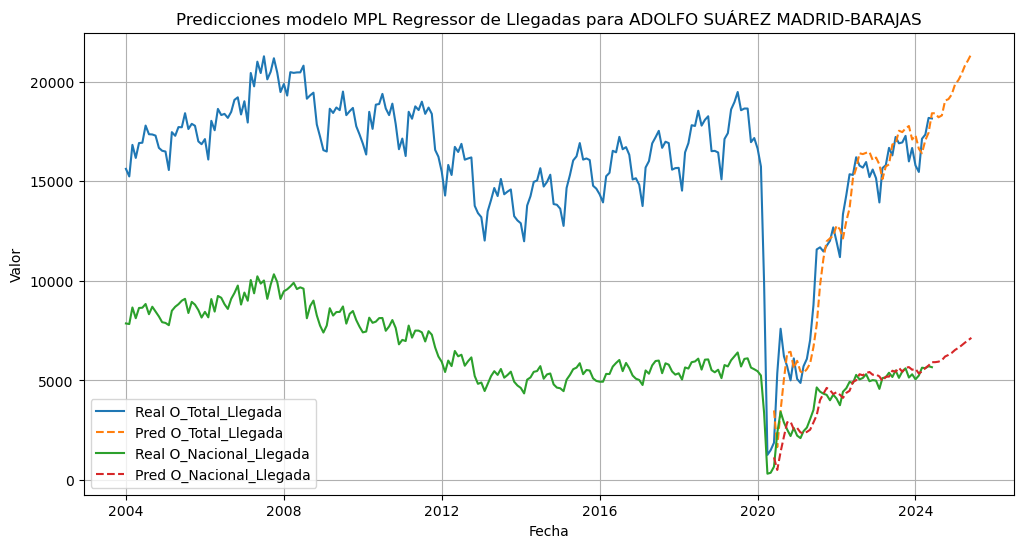

In [11]:
# Se visualizan las predicciones para un aeropuerto específico
Aeropuerto_Prediccion = 'ADOLFO SUÁREZ MADRID-BARAJAS'

# Se filtran los tipos de operación disponibles para el aeropuerto seleccionado
Tipos_Operacion = Operaciones_Unico[Operaciones_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion]['Tipo'].unique()

# Se filtran los tipos de operación para Llegada
Tipos_Llegada = [tipo for tipo in Tipos_Operacion if 'Llegada' in tipo]


# Gráfico para operaciones de Llegada
plt.figure(figsize=(12, 6))
for Tipo_Operacion_Prediccion in Tipos_Llegada:
    # Se filtran los datos reales para el tipo de operación
    Datos_Reales_Operacion_MPL = Operaciones_Unico[(Operaciones_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                               (Operaciones_Unico['Tipo'] == Tipo_Operacion_Prediccion)]
    
    # Se filtran las predicciones para el tipo de operación
    Datos_Predicciones_Operacion_MPL = Predicciones_Operaciones_MPL[(Predicciones_Operaciones_MPL['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                                            (Predicciones_Operaciones_MPL['Tipo'] == Tipo_Operacion_Prediccion)]
    
    # Se añaden las series reales y predicciones al gráfico
    plt.plot(Datos_Reales_Operacion_MPL.index, Datos_Reales_Operacion_MPL['Valor'], label=f'Real {Tipo_Operacion_Prediccion}')
    plt.plot(Datos_Predicciones_Operacion_MPL['Fecha'], Datos_Predicciones_Operacion_MPL['Prediccion'], linestyle='--', label=f'Pred {Tipo_Operacion_Prediccion}')

# Se configura el gráfico
plt.title(f'Predicciones modelo MPL Regressor de Llegadas para {Aeropuerto_Prediccion}')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

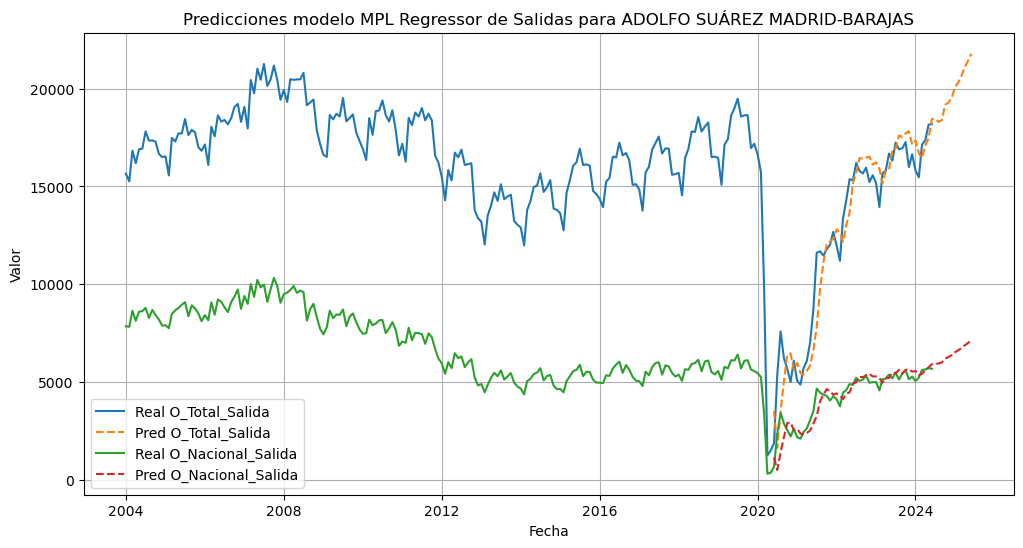

In [12]:
# Se visualizan las predicciones para un aeropuerto específico
Aeropuerto_Prediccion = 'ADOLFO SUÁREZ MADRID-BARAJAS'

# Se filtran los tipos de operación disponibles para el aeropuerto seleccionado
Tipos_Operacion = Operaciones_Unico[Operaciones_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion]['Tipo'].unique()

# Se filtran los tipos de operación para Salida
Tipos_Salida = [tipo for tipo in Tipos_Operacion if 'Salida' in tipo]


# Gráfico para operaciones de Salida
plt.figure(figsize=(12, 6))
for Tipo_Operacion_Prediccion in Tipos_Salida:
    # Se filtran los datos reales para el tipo de operación
    Datos_Reales_Operacion_MPL = Operaciones_Unico[(Operaciones_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                               (Operaciones_Unico['Tipo'] == Tipo_Operacion_Prediccion)]
    
    # Se filtran las predicciones para el tipo de operación
    Datos_Predicciones_Operacion_MPL = Predicciones_Operaciones_MPL[(Predicciones_Operaciones_MPL['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                                            (Predicciones_Operaciones_MPL['Tipo'] == Tipo_Operacion_Prediccion)]
    
    # Se añaden las series reales y predicciones al gráfico
    plt.plot(Datos_Reales_Operacion_MPL.index, Datos_Reales_Operacion_MPL['Valor'], label=f'Real {Tipo_Operacion_Prediccion}')
    plt.plot(Datos_Predicciones_Operacion_MPL['Fecha'], Datos_Predicciones_Operacion_MPL['Prediccion'], linestyle='--', label=f'Pred {Tipo_Operacion_Prediccion}')

# Se configura el gráfico
plt.title(f'Predicciones modelo MPL Regressor de Salidas para {Aeropuerto_Prediccion}')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

**11-c. Métricas de error**

In [14]:
# Se crea un DataFrame para almacenar las métricas de error
Metricas_Error_Operaciones_MPL = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'MAE', 'RMSE', 'MAPE'])

# Se itera sobre las combinaciones de aeropuerto y tipo de operación
for (Aeropuerto, Operacion), (Predicciones_Originales_MPL, _, Fechas_Reales) in Dicc_Predicciones_Operaciones_MPL.items():
    # Se obtienen los valores reales
    Valores_Reales_Operacion_MPL = Operaciones_Unico[(Operaciones_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                       (Operaciones_Unico['Tipo'] == Operacion)]['Valor'][-len(Predicciones_Originales_MPL):]

     # Se calculan las métricas de error si hay valores reales para comparar
    if len(Valores_Reales_Operacion_MPL) == len(Predicciones_Originales_MPL):
        # MAE - Error Absoluto Medio
        mae = mean_absolute_error(Valores_Reales_Operacion_MPL, Predicciones_Originales_MPL)
        # RMSE - Error Cuatrático Medio
        rmse = np.sqrt(mean_squared_error(Valores_Reales_Operacion_MPL, Predicciones_Originales_MPL))
        # MAPE - Error Porcentual Absoluto Medio
        mape = np.mean(np.abs((Valores_Reales_Operacion_MPL - Predicciones_Originales_MPL) / Valores_Reales_Operacion_MPL)) * 100

        # Se almacenan las métricas en el DataFrame
        Temp_Metricas_Error_MPL = pd.DataFrame({
            'Aeropuerto_Base': [Aeropuerto],
            'Tipo': [Operacion],
            'MAE': [mae],
            'RMSE': [rmse],
            'MAPE': [mape]
        })
       
        # Se concatenan las métricas de error
        Metricas_Error_Operaciones_MPL = pd.concat([Metricas_Error_Operaciones_MPL, Temp_Metricas_Error_MPL], ignore_index=True) 
    else:
        print(f"Las longitudes no coinciden para {Aeropuerto} - {Operacion}")

# Se muestran las métricas
print(Metricas_Error_Operaciones_MPL)

                  Aeropuerto_Base                Tipo          MAE  \
0                        A CORUÑA     O_Total_Llegada    90.285040   
1                        A CORUÑA  O_Nacional_Llegada    86.088033   
2                        A CORUÑA      O_Total_Salida    89.652859   
3                        A CORUÑA   O_Nacional_Salida    86.072195   
4    ADOLFO SUÁREZ MADRID-BARAJAS     O_Total_Llegada  1019.970973   
..                            ...                 ...          ...   
191         ALGECIRAS /HELIPUERTO   O_Nacional_Salida    12.809228   
192              MURCIA COMBINADO     O_Total_Llegada    83.691471   
193              MURCIA COMBINADO  O_Nacional_Llegada    16.904186   
194              MURCIA COMBINADO      O_Total_Salida    83.590240   
195              MURCIA COMBINADO   O_Nacional_Salida    17.107745   

            RMSE       MAPE  
0     114.727854  16.767076  
1     110.142128  16.829258  
2     113.976217  16.648349  
3     109.890178  16.821845  
4    1354

**11-d. Métricas de error promedias de todo el conjunto**

In [15]:
# Se calculan las métricas medias para este modelo 
MAE_promedio_MPL = Metricas_Error_Operaciones_MPL['MAE'].mean()
RMSE_promedio_MPL = Metricas_Error_Operaciones_MPL['RMSE'].mean()
MAPE_promedio_MPL = Metricas_Error_Operaciones_MPL['MAPE'].mean()

# Se muestran los resultados MPL Regressor
print(f"MAE Promedio MPL Regressor: {MAE_promedio_MPL}")
print(f"RMSE Promedio AMPL Regressor: {RMSE_promedio_MPL}")
print(f"MAPE Promedio MPL Regressor): {MAPE_promedio_MPL}%")

MAE Promedio MPL Regressor: 203.88825742952358
RMSE Promedio AMPL Regressor: 265.0111621918828
MAPE Promedio MPL Regressor): inf%


Los datos no han mejorado con respecto a lo que ya teníamos, por lo que por ahora el modelo Holt-Winters Aditivo sigue siendo el mejor.

**12. Modelo K-Vecinos**

In [21]:
# Se crea un diccionario para almacenar las predicciones
Dicc_Predicciones_Operaciones_K = {}

# Función para crear variables lag
def crear_lags(data, lags):
    df_lags = pd.DataFrame()
    for lag in range(1, lags + 1):
        df_lags[f'lag_{lag}'] = data.shift(lag)
    df_lags['Valor'] = data.values
    return df_lags.dropna()

# Se obtienen todos los aeropuertos y tipos únicos
Aeropuertos = Operaciones_Unico['Aeropuerto_Base'].unique()
Tipos_Operacion = Operaciones_Unico['Tipo'].unique()

# Se itera sobre cada aeropuerto y tipo
for Aeropuerto in Aeropuertos:
    for Operacion in Tipos_Operacion:
        # Se filtra cada aeropuerto y tipo de operación para los datos originales "reales"
        Datos_Reales_Operacion_K = Operaciones_Unico[(Operaciones_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                                   (Operaciones_Unico['Tipo'] == Operacion)]
        
        # Se comprueba que está ordenado cronológicamente
        Datos_Reales_Operacion_K = Datos_Reales_Operacion_K.sort_index()

        # Se crean las variables lag 
        lags = 3
        data_lags_K = crear_lags(Datos_Reales_Operacion_K['Valor'], lags)
        
        # Se Separa el conjunto en entrenamiento (80%) y test (20%)
        X = data_lags_K.drop(columns=['Valor'])
        y = data_lags_K['Valor']
        X_train_K, X_test_K, y_train_K, y_test_K = train_test_split(X, y, test_size=0.2, shuffle=False)
        
        # Entrenamiento y predicciones
        try:
            
            model_K = KNeighborsRegressor(n_neighbors=7)
            model_K.fit(X_train_K, y_train_K)

            # Predicciones sobre los datos históricos
            Predicciones_Originales_K = model_K.predict(X_test_K)

            # Predicciones futuras
            last_values = X_test_K.iloc[-1].values
            Predicciones_Futuras_K = []
            for _ in range(12):
                next_pred = model_K.predict(pd.DataFrame([last_values], columns=X.columns))
                Predicciones_Futuras_K.append(next_pred[0])
                last_values = np.roll(last_values, -1)
                last_values[-1] = next_pred[0]

            Predicciones_Futuras_K = pd.Series(Predicciones_Futuras_K)

            # Almacenar las predicciones en el diccionario
            Dicc_Predicciones_Operaciones_K[(Aeropuerto, Operacion)] = (Predicciones_Originales_K, Predicciones_Futuras_K, Datos_Reales_Operacion_K.index[-len(Predicciones_Originales_K):])

        except Exception as e:
            print(f"Error al entrenar el modelo para {Aeropuerto}, {Operacion}: {e}")

**12-a. Dataframe en el que se guardan las predicciones y los datos reales**

In [22]:
# Se crea un dataframe para poder comparar las predicciones
Comparacion_Total_Todos_Aeropuertos_K = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'Fecha', 'Valor Real', 'Prediccion'])

for (Aeropuerto, Operacion), (Predicciones_Originales_K, Predicciones_Futuras_K, Fechas_Reales) in Dicc_Predicciones_Operaciones_K.items():
    # Se extraen los valores reales coincidentes con las predicciones originales
    Valores_Reales_Operacion_K = Operaciones_Unico[(Operaciones_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                        (Operaciones_Unico['Tipo'] == Operacion)].loc[Fechas_Reales, 'Valor']
    
    # Se comprueba que ambas longitudes coinciden
    min_len = min(len(Fechas_Reales), len(Predicciones_Originales_K), len(Valores_Reales_Operacion_K))
    
    # Se crea un DataFrame temporal para las predicciones históricas con los valores originales
    Tem_Predicciones_Historicas_K = pd.DataFrame({
        'Aeropuerto_Base': [Aeropuerto] * min_len,
        'Tipo': [Operacion] * min_len,
        'Fecha': Fechas_Reales[:min_len],
        'Valor Real': Valores_Reales_Operacion_K[:min_len],
        'Prediccion': Predicciones_Originales_K[:min_len]
    })

    # Se filtran las columnas que contenga un NaN, en el caso de las históricas, son todas aquellas que pasan de la fecha de junio 2024
    Tem_Predicciones_Historicas_K = Tem_Predicciones_Historicas_K.dropna(axis=1, how='all')

    # Se crea un DataFrame temporal para las predicciones futuras
    Fechas_Futuras = pd.date_range(start=Fechas_Reales[-1] + pd.offsets.MonthBegin(1), periods=len(Predicciones_Futuras_K), freq='MS')
    Temp_Predicciones_Futuras_K = pd.DataFrame({
        'Aeropuerto_Base': [Aeropuerto] * len(Predicciones_Futuras_K),
        'Tipo': [Operacion] * len(Predicciones_Futuras_K),
        'Fecha': Fechas_Futuras,
        'Valor Real': [None] * len(Predicciones_Futuras_K),
        'Prediccion': Predicciones_Futuras_K
    })

    # Se filtran las columnas que contenga un NaN
    Temp_Predicciones_Futuras_K = Temp_Predicciones_Futuras_K.dropna(axis=1, how='all')

    # Se concatena los dos dataframe (históricos y futuros)
    Comparacion_Total_Todos_Aeropuertos_K = pd.concat([Comparacion_Total_Todos_Aeropuertos_K, Tem_Predicciones_Historicas_K, Temp_Predicciones_Futuras_K], ignore_index=True)

# Se muestran las últimas filas para ver los valores reales y predicciones
print(Comparacion_Total_Todos_Aeropuertos_K.tail(20))

        Aeropuerto_Base               Tipo      Fecha  Valor Real  Prediccion
11936  MURCIA COMBINADO  O_Nacional_Salida 2023-11-01        49.0   53.000000
11937  MURCIA COMBINADO  O_Nacional_Salida 2023-12-01        50.0   45.000000
11938  MURCIA COMBINADO  O_Nacional_Salida 2024-01-01        52.0   46.714286
11939  MURCIA COMBINADO  O_Nacional_Salida 2024-02-01        50.0   50.714286
11940  MURCIA COMBINADO  O_Nacional_Salida 2024-03-01        65.0   45.714286
11941  MURCIA COMBINADO  O_Nacional_Salida 2024-04-01        57.0   70.000000
11942  MURCIA COMBINADO  O_Nacional_Salida 2024-05-01       109.0   45.142857
11943  MURCIA COMBINADO  O_Nacional_Salida 2024-06-01        99.0  113.285714
11944  MURCIA COMBINADO  O_Nacional_Salida 2024-07-01         NaN  113.285714
11945  MURCIA COMBINADO  O_Nacional_Salida 2024-08-01         NaN   51.857143
11946  MURCIA COMBINADO  O_Nacional_Salida 2024-09-01         NaN   77.000000
11947  MURCIA COMBINADO  O_Nacional_Salida 2024-10-01         Na

**12-b.Visualización de las predicciones**

In [23]:
# Se crea un DataFrame para almacenar todas las predicciones
Predicciones_Operaciones_K = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'Fecha', 'Prediccion'])

for (Aeropuerto, Operacion), (Predicciones_Originales_K, Predicciones_Futuras_K, Fechas_Reales) in Dicc_Predicciones_Operaciones_K.items():
    # Se guardan en un DataFrame temporal para las predicciones de los datos orginales "reales"
    Tem_Predicciones_Historicas_K = pd.DataFrame({
        'Aeropuerto_Base': Aeropuerto,
        'Tipo': Operacion,
        'Fecha': Fechas_Reales,
        'Prediccion': Predicciones_Originales_K
    })

    # Se guardan en un DataFrame temporal para las predicciones de fechas futuras
    Fechas_Futuras = pd.date_range(start=Fechas_Reales[-1] + pd.offsets.MonthBegin(1), periods=len(Predicciones_Futuras_K), freq='MS')
    Temp_Predicciones_Futuras_K = pd.DataFrame({
        'Aeropuerto_Base': Aeropuerto,
        'Tipo': Operacion,
        'Fecha': Fechas_Futuras,
        'Prediccion': Predicciones_Futuras_K
    })

    # Se concatenan ambas predicciones y se guardan en un dataframe único
    Predicciones_Operaciones_K = pd.concat([Predicciones_Operaciones_K, Tem_Predicciones_Historicas_K, Temp_Predicciones_Futuras_K], ignore_index=True)

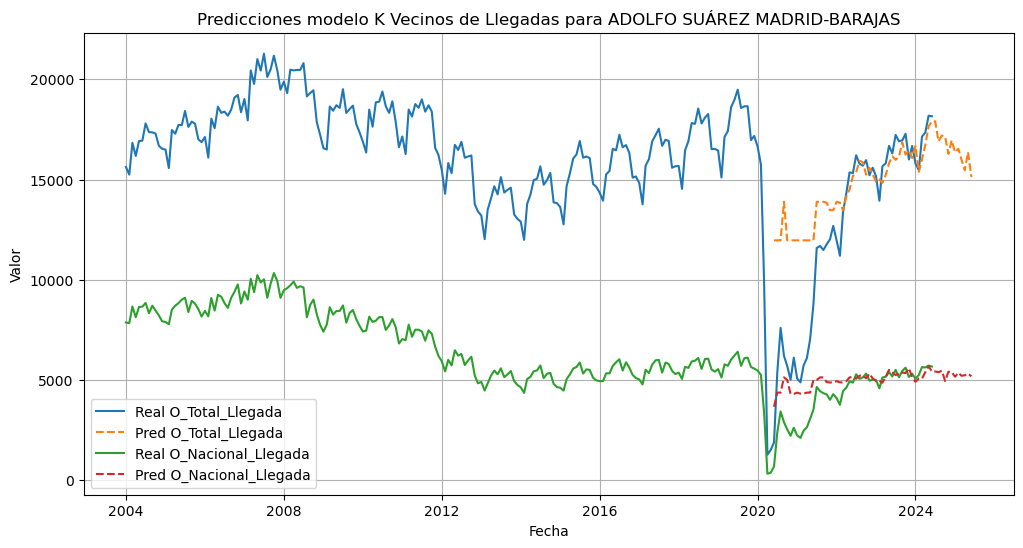

In [24]:
# Se visualizan las predicciones para un aeropuerto específico
Aeropuerto_Prediccion = 'ADOLFO SUÁREZ MADRID-BARAJAS'

# Se filtran los tipos de operación disponibles para el aeropuerto seleccionado
Tipos_Operacion = Operaciones_Unico[Operaciones_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion]['Tipo'].unique()

# Se filtran los tipos de operación para Llegada
Tipos_Llegada = [tipo for tipo in Tipos_Operacion if 'Llegada' in tipo]


# Gráfico para operaciones de Llegada
plt.figure(figsize=(12, 6))
for Tipo_Operacion_Prediccion in Tipos_Llegada:
    # Se filtran los datos reales para el tipo de operación
    Datos_Reales_Operacion_K = Operaciones_Unico[(Operaciones_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                               (Operaciones_Unico['Tipo'] == Tipo_Operacion_Prediccion)]
    
    # Se filtran las predicciones para el tipo de operación
    Datos_Predicciones_Operacion_K = Predicciones_Operaciones_K[(Predicciones_Operaciones_K['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                                            (Predicciones_Operaciones_K['Tipo'] == Tipo_Operacion_Prediccion)]
    
    # Se añaden las series reales y predicciones al gráfico
    plt.plot(Datos_Reales_Operacion_K.index, Datos_Reales_Operacion_K['Valor'], label=f'Real {Tipo_Operacion_Prediccion}')
    plt.plot(Datos_Predicciones_Operacion_K['Fecha'], Datos_Predicciones_Operacion_K['Prediccion'], linestyle='--', label=f'Pred {Tipo_Operacion_Prediccion}')

# Se configura el gráfico
plt.title(f'Predicciones modelo K Vecinos de Llegadas para {Aeropuerto_Prediccion}')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

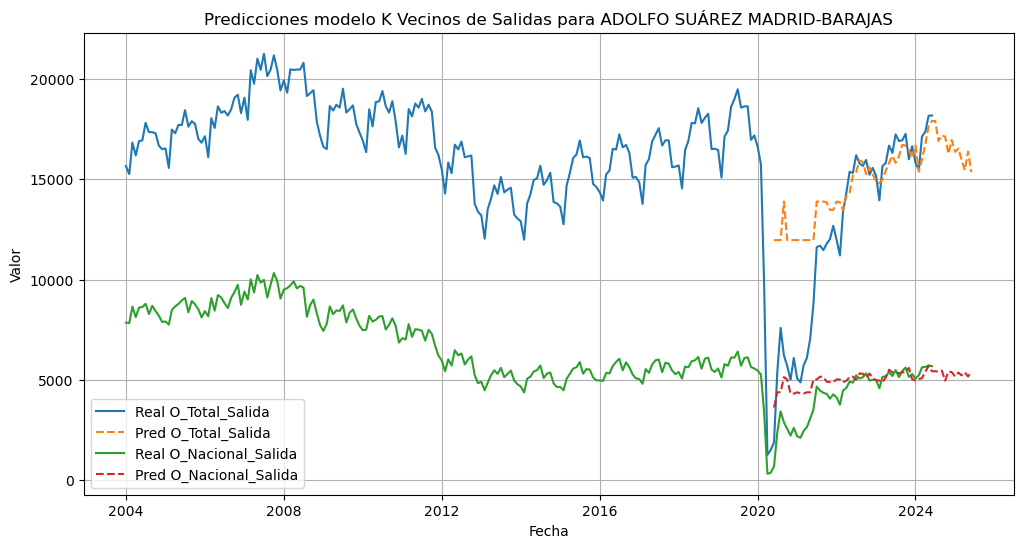

In [25]:
# Se visualizan las predicciones para un aeropuerto específico
Aeropuerto_Prediccion = 'ADOLFO SUÁREZ MADRID-BARAJAS'

# Se filtran los tipos de operación disponibles para el aeropuerto seleccionado
Tipos_Operacion = Operaciones_Unico[Operaciones_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion]['Tipo'].unique()

# Se filtran los tipos de operación para Salida
Tipos_Salida = [tipo for tipo in Tipos_Operacion if 'Salida' in tipo]


# Gráfico para operaciones de Salida
plt.figure(figsize=(12, 6))
for Tipo_Operacion_Prediccion in Tipos_Salida:
    # Se filtran los datos reales para el tipo de operación
    Datos_Reales_Operacion_K = Operaciones_Unico[(Operaciones_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                               (Operaciones_Unico['Tipo'] == Tipo_Operacion_Prediccion)]
    
    # Se filtran las predicciones para el tipo de operación
    Datos_Predicciones_Operacion_K = Predicciones_Operaciones_K[(Predicciones_Operaciones_K['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                                            (Predicciones_Operaciones_K['Tipo'] == Tipo_Operacion_Prediccion)]
    
    # Se añaden las series reales y predicciones al gráfico
    plt.plot(Datos_Reales_Operacion_K.index, Datos_Reales_Operacion_K['Valor'], label=f'Real {Tipo_Operacion_Prediccion}')
    plt.plot(Datos_Predicciones_Operacion_K['Fecha'], Datos_Predicciones_Operacion_K['Prediccion'], linestyle='--', label=f'Pred {Tipo_Operacion_Prediccion}')

# Se configura el gráfico
plt.title(f'Predicciones modelo K Vecinos de Salidas para {Aeropuerto_Prediccion}')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

**12-c. Métricas de error**

In [26]:
# Se crea un DataFrame para almacenar las métricas de error
Metricas_Error_Operaciones_K = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'MAE', 'RMSE', 'MAPE'])

# Se itera sobre las combinaciones de aeropuerto y tipo de operación
for (Aeropuerto, Operacion), (Predicciones_Originales_K, _, Fechas_Reales) in Dicc_Predicciones_Operaciones_K.items():
    # Se obtienen los valores reales
    Valores_Reales_Operacion_K = Operaciones_Unico[(Operaciones_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                       (Operaciones_Unico['Tipo'] == Operacion)]['Valor'][-len(Predicciones_Originales_MPL):]

     # Se calculan las métricas de error si hay valores reales para comparar
    if len(Valores_Reales_Operacion_K) == len(Predicciones_Originales_K):
        # MAE - Error Absoluto Medio
        mae = mean_absolute_error(Valores_Reales_Operacion_K, Predicciones_Originales_K)
        # RMSE - Error Cuatrático Medio
        rmse = np.sqrt(mean_squared_error(Valores_Reales_Operacion_K, Predicciones_Originales_K))
        # MAPE - Error Porcentual Absoluto Medio
        mape = np.mean(np.abs((Valores_Reales_Operacion_K - Predicciones_Originales_K) / Valores_Reales_Operacion_K)) * 100

        # Se almacenan las métricas en el DataFrame
        Temp_Metricas_Error_K = pd.DataFrame({
            'Aeropuerto_Base': [Aeropuerto],
            'Tipo': [Operacion],
            'MAE': [mae],
            'RMSE': [rmse],
            'MAPE': [mape]
        })
       
        # Se concatenan las métricas de error
        Metricas_Error_Operaciones_K = pd.concat([Metricas_Error_Operaciones_K, Temp_Metricas_Error_K], ignore_index=True) 
    else:
        print(f"Las longitudes no coinciden para {Aeropuerto} - {Operacion}")

# Se muestran las métricas
print(Metricas_Error_Operaciones_K)

                  Aeropuerto_Base                Tipo          MAE  \
0                        A CORUÑA     O_Total_Llegada    73.603499   
1                        A CORUÑA  O_Nacional_Llegada    59.553936   
2                        A CORUÑA      O_Total_Salida    71.848397   
3                        A CORUÑA   O_Nacional_Salida    57.294461   
4    ADOLFO SUÁREZ MADRID-BARAJAS     O_Total_Llegada  2310.874636   
..                            ...                 ...          ...   
191         ALGECIRAS /HELIPUERTO   O_Nacional_Salida    15.912536   
192              MURCIA COMBINADO     O_Total_Llegada    89.588921   
193              MURCIA COMBINADO  O_Nacional_Llegada    14.329446   
194              MURCIA COMBINADO      O_Total_Salida    91.110787   
195              MURCIA COMBINADO   O_Nacional_Salida    13.510204   

            RMSE        MAPE  
0      88.460902   14.315952  
1      72.953835   11.866266  
2      85.153638   14.044928  
3      71.267913   11.499133  
4   

**12-d. Métricas de error promedias de todo el conjunto**

In [28]:
# Se calculan las métricas medias para este modelo 
MAE_promedio_K = Metricas_Error_Operaciones_K['MAE'].mean()
RMSE_promedio_K = Metricas_Error_Operaciones_K['RMSE'].mean()
MAPE_promedio_K = Metricas_Error_Operaciones_K['MAPE'].mean()

# Se muestran los resultados K Vecinos
print(f"MAE Promedio K Vecinos: {MAE_promedio_K}")
print(f"RMSE Promedio K Vecinos: {RMSE_promedio_K}")
print(f"MAPE Promedio K Vecinos: {MAPE_promedio_K}%")

MAE Promedio K Vecinos: 225.012628666627
RMSE Promedio K Vecinos: 299.19328564351264
MAPE Promedio K Vecinos: 28.26574741063278%


Este modelo tampoco mejora los datos de predicción que ya se tenían.

**13. Modelo Gradient Boosting**

In [29]:
# Se crea un diccionario para almacenar las predicciones
Dicc_Predicciones_Operaciones_GB = {}

# Función para crear variables lag
def crear_lags(data, lags):
    df_lags = pd.DataFrame()
    for lag in range(1, lags + 1):
        df_lags[f'lag_{lag}'] = data.shift(lag)
    df_lags['Valor'] = data.values
    return df_lags.dropna()

# Se obtienen todos los aeropuertos y tipos únicos
Aeropuertos = Operaciones_Unico['Aeropuerto_Base'].unique()
Tipos_Operacion = Operaciones_Unico['Tipo'].unique()

# Se itera sobre cada aeropuerto y tipo
for Aeropuerto in Aeropuertos:
    for Operacion in Tipos_Operacion:
        # Se filtra cada aeropuerto y tipo de operación para los datos originales "reales"
        Datos_Reales_Operacion_GB = Operaciones_Unico[(Operaciones_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                                   (Operaciones_Unico['Tipo'] == Operacion)]
        
        # Se comprueba que está ordenado cronológicamente
        Datos_Reales_Operacion_GB = Datos_Reales_Operacion_GB.sort_index()

        # Se crean las variables lag 
        lags = 3
        data_lags_GB = crear_lags(Datos_Reales_Operacion_GB['Valor'], lags)
        
        # Se Separa el conjunto en entrenamiento (70%) y test (30%)
        X = data_lags_GB.drop(columns=['Valor'])
        y = data_lags_GB['Valor']
        X_train_GB, X_test_GB, y_train_GB, y_test_GB = train_test_split(X, y, test_size=0.3, shuffle=False)
        
        # Entrenamiento y predicciones
        try:
            
            model_GB = GradientBoostingRegressor(n_estimators=150, random_state=42)
            model_GB.fit(X_train_GB, y_train_GB)

            # Predicciones sobre los datos históricos
            Predicciones_Originales_GB = model_GB.predict(X_test_GB)

            # Predicciones futuras
            last_values = X_test_GB.iloc[-1].values
            Predicciones_Futuras_GB = []
            for _ in range(12):
                next_pred = model_GB.predict(pd.DataFrame([last_values], columns=X.columns))
                Predicciones_Futuras_GB.append(next_pred[0])
                last_values = np.roll(last_values, -1)
                last_values[-1] = next_pred[0]

            Predicciones_Futuras_GB = pd.Series(Predicciones_Futuras_GB)

            # Almacenar las predicciones en el diccionario
            Dicc_Predicciones_Operaciones_GB[(Aeropuerto, Operacion)] = (Predicciones_Originales_GB, Predicciones_Futuras_GB, Datos_Reales_Operacion_GB.index[-len(Predicciones_Originales_GB):])

        except Exception as e:
            print(f"Error al entrenar el modelo para {Aeropuerto}, {Operacion}: {e}")

**13-a. Dataframe en el que se guardan las predicciones y los datos reales**

In [30]:
# Se crea un dataframe para poder comparar las predicciones
Comparacion_Total_Todos_Aeropuertos_GB = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'Fecha', 'Valor Real', 'Prediccion'])

for (Aeropuerto, Operacion), (Predicciones_Originales_GB, Predicciones_Futuras_GB, Fechas_Reales) in Dicc_Predicciones_Operaciones_GB.items():
    # Se extraen los valores reales coincidentes con las predicciones originales
    Valores_Reales_Operacion_GB = Operaciones_Unico[(Operaciones_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                        (Operaciones_Unico['Tipo'] == Operacion)].loc[Fechas_Reales, 'Valor']
    
    # Se comprueba que ambas longitudes coinciden
    min_len = min(len(Fechas_Reales), len(Predicciones_Originales_GB), len(Valores_Reales_Operacion_GB))
    
    # Se crea un DataFrame temporal para las predicciones históricas con los valores originales
    Tem_Predicciones_Historicas_GB = pd.DataFrame({
        'Aeropuerto_Base': [Aeropuerto] * min_len,
        'Tipo': [Operacion] * min_len,
        'Fecha': Fechas_Reales[:min_len],
        'Valor Real': Valores_Reales_Operacion_GB[:min_len],
        'Prediccion': Predicciones_Originales_GB[:min_len]
    })

    # Se filtran las columnas que contenga un NaN, en el caso de las históricas, son todas aquellas que pasan de la fecha de junio 2024
    Tem_Predicciones_Historicas_GB = Tem_Predicciones_Historicas_GB.dropna(axis=1, how='all')

    # Se crea un DataFrame temporal para las predicciones futuras
    Fechas_Futuras = pd.date_range(start=Fechas_Reales[-1] + pd.offsets.MonthBegin(1), periods=len(Predicciones_Futuras_GB), freq='MS')
    Temp_Predicciones_Futuras_GB = pd.DataFrame({
        'Aeropuerto_Base': [Aeropuerto] * len(Predicciones_Futuras_GB),
        'Tipo': [Operacion] * len(Predicciones_Futuras_GB),
        'Fecha': Fechas_Futuras,
        'Valor Real': [None] * len(Predicciones_Futuras_GB),
        'Prediccion': Predicciones_Futuras_GB
    })

    # Se filtran las columnas que contenga un NaN
    Temp_Predicciones_Futuras_GB = Temp_Predicciones_Futuras_GB.dropna(axis=1, how='all')

    # Se concatena los dos dataframe (históricos y futuros)
    Comparacion_Total_Todos_Aeropuertos_GB = pd.concat([Comparacion_Total_Todos_Aeropuertos_GB, Tem_Predicciones_Historicas_GB, Temp_Predicciones_Futuras_GB], ignore_index=True)

# Se muestran las últimas filas para ver los valores reales y predicciones
print(Comparacion_Total_Todos_Aeropuertos_GB.tail(20))

        Aeropuerto_Base               Tipo      Fecha  Valor Real  Prediccion
16640  MURCIA COMBINADO  O_Nacional_Salida 2023-11-01        49.0   40.853340
16641  MURCIA COMBINADO  O_Nacional_Salida 2023-12-01        50.0   44.887899
16642  MURCIA COMBINADO  O_Nacional_Salida 2024-01-01        52.0   51.259072
16643  MURCIA COMBINADO  O_Nacional_Salida 2024-02-01        50.0   51.259072
16644  MURCIA COMBINADO  O_Nacional_Salida 2024-03-01        65.0   51.259072
16645  MURCIA COMBINADO  O_Nacional_Salida 2024-04-01        57.0   64.788815
16646  MURCIA COMBINADO  O_Nacional_Salida 2024-05-01       109.0   61.155257
16647  MURCIA COMBINADO  O_Nacional_Salida 2024-06-01        99.0   83.402433
16648  MURCIA COMBINADO  O_Nacional_Salida 2024-07-01         NaN   83.402433
16649  MURCIA COMBINADO  O_Nacional_Salida 2024-08-01         NaN   56.254718
16650  MURCIA COMBINADO  O_Nacional_Salida 2024-09-01         NaN   61.527580
16651  MURCIA COMBINADO  O_Nacional_Salida 2024-10-01         Na

**13-b.Visualización de las predicciones**

In [31]:
# Se crea un DataFrame para almacenar todas las predicciones
Predicciones_Operaciones_GB = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'Fecha', 'Prediccion'])

for (Aeropuerto, Operacion), (Predicciones_Originales_GB, Predicciones_Futuras_GB, Fechas_Reales) in Dicc_Predicciones_Operaciones_GB.items():
    # Se guardan en un DataFrame temporal para las predicciones de los datos orginales "reales"
    Tem_Predicciones_Historicas_GB = pd.DataFrame({
        'Aeropuerto_Base': Aeropuerto,
        'Tipo': Operacion,
        'Fecha': Fechas_Reales,
        'Prediccion': Predicciones_Originales_GB
    })

    # Se guardan en un DataFrame temporal para las predicciones de fechas futuras
    Fechas_Futuras = pd.date_range(start=Fechas_Reales[-1] + pd.offsets.MonthBegin(1), periods=len(Predicciones_Futuras_GB), freq='MS')
    Temp_Predicciones_Futuras_GB = pd.DataFrame({
        'Aeropuerto_Base': Aeropuerto,
        'Tipo': Operacion,
        'Fecha': Fechas_Futuras,
        'Prediccion': Predicciones_Futuras_GB
    })

    # Se concatenan ambas predicciones y se guardan en un dataframe único
    Predicciones_Operaciones_GB = pd.concat([Predicciones_Operaciones_GB, Tem_Predicciones_Historicas_GB, Temp_Predicciones_Futuras_GB], ignore_index=True)

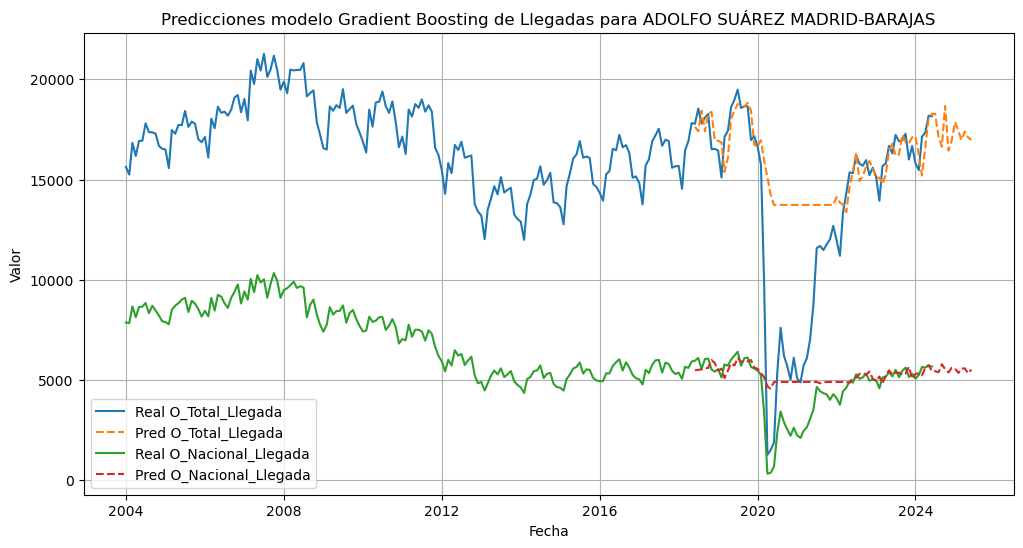

In [32]:
# Se visualizan las predicciones para un aeropuerto específico
Aeropuerto_Prediccion = 'ADOLFO SUÁREZ MADRID-BARAJAS'

# Se filtran los tipos de operación disponibles para el aeropuerto seleccionado
Tipos_Operacion = Operaciones_Unico[Operaciones_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion]['Tipo'].unique()

# Se filtran los tipos de operación para Llegada
Tipos_Llegada = [tipo for tipo in Tipos_Operacion if 'Llegada' in tipo]


# Gráfico para operaciones de Llegada
plt.figure(figsize=(12, 6))
for Tipo_Operacion_Prediccion in Tipos_Llegada:
    # Se filtran los datos reales para el tipo de operación
    Datos_Reales_Operacion_GB = Operaciones_Unico[(Operaciones_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                               (Operaciones_Unico['Tipo'] == Tipo_Operacion_Prediccion)]
    
    # Se filtran las predicciones para el tipo de operación
    Datos_Predicciones_Operacion_GB = Predicciones_Operaciones_GB[(Predicciones_Operaciones_GB['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                                            (Predicciones_Operaciones_GB['Tipo'] == Tipo_Operacion_Prediccion)]
    
    # Se añaden las series reales y predicciones al gráfico
    plt.plot(Datos_Reales_Operacion_GB.index, Datos_Reales_Operacion_GB['Valor'], label=f'Real {Tipo_Operacion_Prediccion}')
    plt.plot(Datos_Predicciones_Operacion_GB['Fecha'], Datos_Predicciones_Operacion_GB['Prediccion'], linestyle='--', label=f'Pred {Tipo_Operacion_Prediccion}')

# Se configura el gráfico
plt.title(f'Predicciones modelo Gradient Boosting de Llegadas para {Aeropuerto_Prediccion}')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

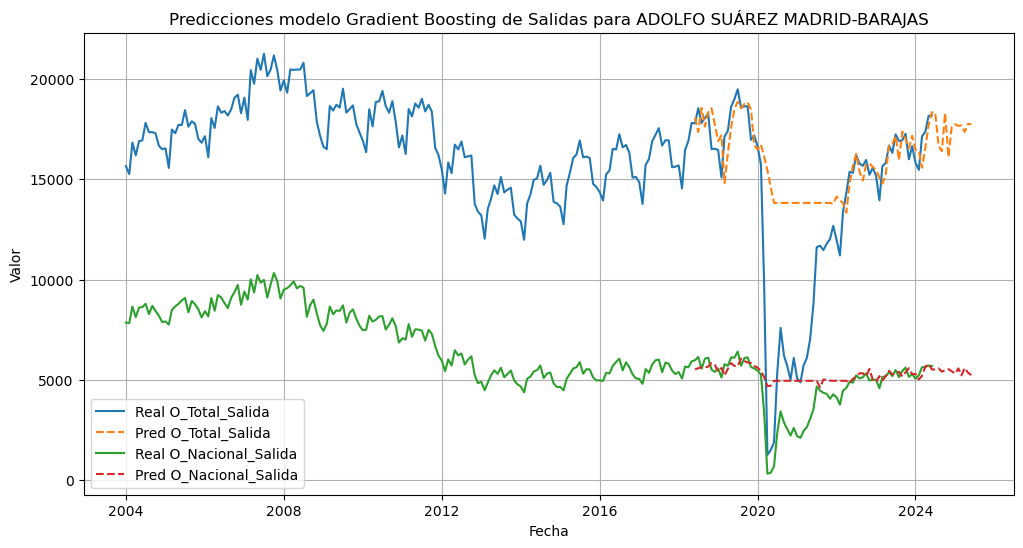

In [33]:
# Se visualizan las predicciones para un aeropuerto específico
Aeropuerto_Prediccion = 'ADOLFO SUÁREZ MADRID-BARAJAS'

# Se filtran los tipos de operación disponibles para el aeropuerto seleccionado
Tipos_Operacion = Operaciones_Unico[Operaciones_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion]['Tipo'].unique()

# Se filtran los tipos de operación para Salida
Tipos_Salida = [tipo for tipo in Tipos_Operacion if 'Salida' in tipo]


# Gráfico para operaciones de Salida
plt.figure(figsize=(12, 6))
for Tipo_Operacion_Prediccion in Tipos_Salida:
    # Se filtran los datos reales para el tipo de operación
    Datos_Reales_Operacion_GB = Operaciones_Unico[(Operaciones_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                               (Operaciones_Unico['Tipo'] == Tipo_Operacion_Prediccion)]
    
    # Se filtran las predicciones para el tipo de operación
    Datos_Predicciones_Operacion_GB = Predicciones_Operaciones_GB[(Predicciones_Operaciones_GB['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                                            (Predicciones_Operaciones_GB['Tipo'] == Tipo_Operacion_Prediccion)]
    
    # Se añaden las series reales y predicciones al gráfico
    plt.plot(Datos_Reales_Operacion_GB.index, Datos_Reales_Operacion_GB['Valor'], label=f'Real {Tipo_Operacion_Prediccion}')
    plt.plot(Datos_Predicciones_Operacion_GB['Fecha'], Datos_Predicciones_Operacion_GB['Prediccion'], linestyle='--', label=f'Pred {Tipo_Operacion_Prediccion}')

# Se configura el gráfico
plt.title(f'Predicciones modelo Gradient Boosting de Salidas para {Aeropuerto_Prediccion}')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

**13-c. Métricas de error**

In [34]:
# Se crea un DataFrame para almacenar las métricas de error
Metricas_Error_Operaciones_GB = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'MAE', 'RMSE', 'MAPE'])

# Se itera sobre las combinaciones de aeropuerto y tipo de operación
for (Aeropuerto, Operacion), (Predicciones_Originales_GB, _, Fechas_Reales) in Dicc_Predicciones_Operaciones_GB.items():
    # Se obtienen los valores reales
    Valores_Reales_Operacion_GB = Operaciones_Unico[(Operaciones_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                       (Operaciones_Unico['Tipo'] == Operacion)]['Valor'][-len(Predicciones_Originales_GB):]

     # Se calculan las métricas de error si hay valores reales para comparar
    if len(Valores_Reales_Operacion_GB) == len(Predicciones_Originales_GB):
        # MAE - Error Absoluto Medio
        mae = mean_absolute_error(Valores_Reales_Operacion_GB, Predicciones_Originales_GB)
        # RMSE - Error Cuatrático Medio
        rmse = np.sqrt(mean_squared_error(Valores_Reales_Operacion_GB, Predicciones_Originales_GB))
        # MAPE - Error Porcentual Absoluto Medio
        mape = np.mean(np.abs((Valores_Reales_Operacion_GB - Predicciones_Originales_GB) / Valores_Reales_Operacion_GB)) * 100

        # Se almacenan las métricas en el DataFrame
        Temp_Metricas_Error_GB = pd.DataFrame({
            'Aeropuerto_Base': [Aeropuerto],
            'Tipo': [Operacion],
            'MAE': [mae],
            'RMSE': [rmse],
            'MAPE': [mape]
        })
       
        # Se concatenan las métricas de error
        Metricas_Error_Operaciones_GB = pd.concat([Metricas_Error_Operaciones_GB, Temp_Metricas_Error_GB], ignore_index=True) 
    else:
        print(f"Las longitudes no coinciden para {Aeropuerto} - {Operacion}")

# Se muestran las métricas
print(Metricas_Error_Operaciones_GB)

                  Aeropuerto_Base                Tipo          MAE  \
0                        A CORUÑA     O_Total_Llegada    72.657360   
1                        A CORUÑA  O_Nacional_Llegada    71.200666   
2                        A CORUÑA      O_Total_Salida    73.714114   
3                        A CORUÑA   O_Nacional_Salida    69.107526   
4    ADOLFO SUÁREZ MADRID-BARAJAS     O_Total_Llegada  2520.894516   
..                            ...                 ...          ...   
191         ALGECIRAS /HELIPUERTO   O_Nacional_Salida    32.010523   
192              MURCIA COMBINADO     O_Total_Llegada    85.638652   
193              MURCIA COMBINADO  O_Nacional_Llegada    16.203421   
194              MURCIA COMBINADO      O_Total_Salida    92.432226   
195              MURCIA COMBINADO   O_Nacional_Salida    14.336554   

            RMSE        MAPE  
0      98.310801   22.973835  
1      97.721808   24.240401  
2      96.972439   22.583915  
3      94.671483   22.707560  
4   

**13-d. Métricas de error promedias de todo el conjunto**

In [35]:
# Se calculan las métricas medias para este modelo 
MAE_promedio_GB = Metricas_Error_Operaciones_GB['MAE'].mean()
RMSE_promedio_GB = Metricas_Error_Operaciones_GB['RMSE'].mean()
MAPE_promedio_GB = Metricas_Error_Operaciones_GB['MAPE'].mean()

# Se muestran los resultados Gradient Boosting
print(f"MAE Promedio Gradient Boosting: {MAE_promedio_GB}")
print(f"RMSE Promedio Gradient Boosting: {RMSE_promedio_GB}")
print(f"MAPE Promedio Gradient Boosting: {MAPE_promedio_GB}%")

MAE Promedio Gradient Boosting: 233.92942469732156
RMSE Promedio Gradient Boosting: 333.04421311657563
MAPE Promedio Gradient Boosting: inf%


Al igual que en el modelo anterior no mejoran. Los datos de predicciones que arroja este modelo, se adaptan, salvo para la época del Covid, que no es capaz de interpretar ese periodo.

**14. Modelo Máquina de Vector Soporte**

In [8]:
# Se crea un diccionario para almacenar las predicciones
Dicc_Predicciones_Operaciones_SVM = {}

# Función para crear variables lag
def crear_lags(data, lags):
    df_lags = pd.DataFrame()
    for lag in range(1, lags + 1):
        df_lags[f'lag_{lag}'] = data.shift(lag)
    df_lags['Valor'] = data.values
    return df_lags.dropna()

# Se obtienen todos los aeropuertos y tipos únicos
Aeropuertos = Operaciones_Unico['Aeropuerto_Base'].unique()
Tipos_Operacion = Operaciones_Unico['Tipo'].unique()

# Se itera sobre cada aeropuerto y tipo
for Aeropuerto in Aeropuertos:
    for Operacion in Tipos_Operacion:
        # Se filtra cada aeropuerto y tipo de operación para los datos originales "reales"
        Datos_Reales_Operacion_SVM = Operaciones_Unico[(Operaciones_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                                   (Operaciones_Unico['Tipo'] == Operacion)]
        
        # Se comprueba que está ordenado cronológicamente
        Datos_Reales_Operacion_SVM = Datos_Reales_Operacion_SVM.sort_index()

        # Se crean las variables lag 
        lags = 2
        data_lags_SVM = crear_lags(Datos_Reales_Operacion_SVM['Valor'], lags)
        
        # Se Separa el conjunto en entrenamiento (75%) y test (25%)
        X = data_lags_SVM.drop(columns=['Valor'])
        y = data_lags_SVM['Valor']
        X_train_SVM, X_test_SVM, y_train_SVM, y_test_SVM = train_test_split(X, y, test_size=0.25, shuffle=False)
        
        # Entrenamiento y predicciones
        try:
            
            model_SVM = SVR(kernel='poly', degree = 2, gamma = 'scale')
            model_SVM.fit(X_train_SVM, y_train_SVM)

            # Predicciones sobre los datos históricos
            Predicciones_Originales_SVM = model_SVM.predict(X_test_SVM)

            # Predicciones futuras
            last_values = X_test_SVM.iloc[-1].values
            Predicciones_Futuras_SVM = []
            for _ in range(12):
                next_pred = model_SVM.predict(pd.DataFrame([last_values], columns=X.columns))
                Predicciones_Futuras_SVM.append(next_pred[0])
                last_values = np.roll(last_values, -1)
                last_values[-1] = next_pred[0]

            Predicciones_Futuras_SVM = pd.Series(Predicciones_Futuras_SVM)

            # Almacenar las predicciones en el diccionario
            Dicc_Predicciones_Operaciones_SVM[(Aeropuerto, Operacion)] = (Predicciones_Originales_SVM, Predicciones_Futuras_SVM, Datos_Reales_Operacion_SVM.index[-len(Predicciones_Originales_SVM):])

        except Exception as e:
            print(f"Error al entrenar el modelo para {Aeropuerto}, {Operacion}: {e}")

**14-a. Dataframe en el que se guardan las predicciones y los datos reales**

In [9]:
# Se crea un dataframe para poder comparar las predicciones
Comparacion_Total_Todos_Aeropuertos_SVM = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'Fecha', 'Valor Real', 'Prediccion'])

for (Aeropuerto, Operacion), (Predicciones_Originales_SVM, Predicciones_Futuras_SVM, Fechas_Reales) in Dicc_Predicciones_Operaciones_SVM.items():
    # Se extraen los valores reales coincidentes con las predicciones originales
    Valores_Reales_Operacion_SVM = Operaciones_Unico[(Operaciones_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                        (Operaciones_Unico['Tipo'] == Operacion)].loc[Fechas_Reales, 'Valor']
    
    # Se comprueba que ambas longitudes coinciden
    min_len = min(len(Fechas_Reales), len(Predicciones_Originales_SVM), len(Valores_Reales_Operacion_SVM))
    
    # Se crea un DataFrame temporal para las predicciones históricas con los valores originales
    Tem_Predicciones_Historicas_SVM = pd.DataFrame({
        'Aeropuerto_Base': [Aeropuerto] * min_len,
        'Tipo': [Operacion] * min_len,
        'Fecha': Fechas_Reales[:min_len],
        'Valor Real': Valores_Reales_Operacion_SVM[:min_len],
        'Prediccion': Predicciones_Originales_SVM[:min_len]
    })

    # Se filtran las columnas que contenga un NaN, en el caso de las históricas, son todas aquellas que pasan de la fecha de junio 2024
    Tem_Predicciones_Historicas_SVM = Tem_Predicciones_Historicas_SVM.dropna(axis=1, how='all')

    # Se crea un DataFrame temporal para las predicciones futuras
    Fechas_Futuras = pd.date_range(start=Fechas_Reales[-1] + pd.offsets.MonthBegin(1), periods=len(Predicciones_Futuras_SVM), freq='MS')
    Temp_Predicciones_Futuras_SVM = pd.DataFrame({
        'Aeropuerto_Base': [Aeropuerto] * len(Predicciones_Futuras_SVM),
        'Tipo': [Operacion] * len(Predicciones_Futuras_SVM),
        'Fecha': Fechas_Futuras,
        'Valor Real': [None] * len(Predicciones_Futuras_SVM),
        'Prediccion': Predicciones_Futuras_SVM
    })

    # Se filtran las columnas que contenga un NaN
    Temp_Predicciones_Futuras_SVM = Temp_Predicciones_Futuras_SVM.dropna(axis=1, how='all')

    # Se concatena los dos dataframe (históricos y futuros)
    Comparacion_Total_Todos_Aeropuertos_SVM = pd.concat([Comparacion_Total_Todos_Aeropuertos_SVM, Tem_Predicciones_Historicas_SVM, Temp_Predicciones_Futuras_SVM], ignore_index=True)

# Se muestran las últimas filas para ver los valores reales y predicciones
print(Comparacion_Total_Todos_Aeropuertos_SVM.tail(20))

        Aeropuerto_Base               Tipo      Fecha  Valor Real  Prediccion
14288  MURCIA COMBINADO  O_Nacional_Salida 2023-11-01        49.0   64.047713
14289  MURCIA COMBINADO  O_Nacional_Salida 2023-12-01        50.0   60.583306
14290  MURCIA COMBINADO  O_Nacional_Salida 2024-01-01        52.0   60.464684
14291  MURCIA COMBINADO  O_Nacional_Salida 2024-02-01        50.0   60.979898
14292  MURCIA COMBINADO  O_Nacional_Salida 2024-03-01        65.0   60.716231
14293  MURCIA COMBINADO  O_Nacional_Salida 2024-04-01        57.0   64.036867
14294  MURCIA COMBINADO  O_Nacional_Salida 2024-05-01       109.0   63.537563
14295  MURCIA COMBINADO  O_Nacional_Salida 2024-06-01        99.0   78.913370
14296  MURCIA COMBINADO  O_Nacional_Salida 2024-07-01         NaN   78.913370
14297  MURCIA COMBINADO  O_Nacional_Salida 2024-08-01         NaN   64.869557
14298  MURCIA COMBINADO  O_Nacional_Salida 2024-09-01         NaN   69.758911
14299  MURCIA COMBINADO  O_Nacional_Salida 2024-10-01         Na

**14-b.Visualización de las predicciones**

In [10]:
# Se crea un DataFrame para almacenar todas las predicciones
Predicciones_Operaciones_SVM = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'Fecha', 'Prediccion'])

for (Aeropuerto, Operacion), (Predicciones_Originales_SVM, Predicciones_Futuras_SVM, Fechas_Reales) in Dicc_Predicciones_Operaciones_SVM.items():
    # Se guardan en un DataFrame temporal para las predicciones de los datos orginales "reales"
    Tem_Predicciones_Historicas_SVM = pd.DataFrame({
        'Aeropuerto_Base': Aeropuerto,
        'Tipo': Operacion,
        'Fecha': Fechas_Reales,
        'Prediccion': Predicciones_Originales_SVM
    })

    # Se guardan en un DataFrame temporal para las predicciones de fechas futuras
    Fechas_Futuras = pd.date_range(start=Fechas_Reales[-1] + pd.offsets.MonthBegin(1), periods=len(Predicciones_Futuras_SVM), freq='MS')
    Temp_Predicciones_Futuras_SVM = pd.DataFrame({
        'Aeropuerto_Base': Aeropuerto,
        'Tipo': Operacion,
        'Fecha': Fechas_Futuras,
        'Prediccion': Predicciones_Futuras_SVM
    })

    # Se concatenan ambas predicciones y se guardan en un dataframe único
    Predicciones_Operaciones_SVM = pd.concat([Predicciones_Operaciones_SVM, Tem_Predicciones_Historicas_SVM, Temp_Predicciones_Futuras_SVM], ignore_index=True)

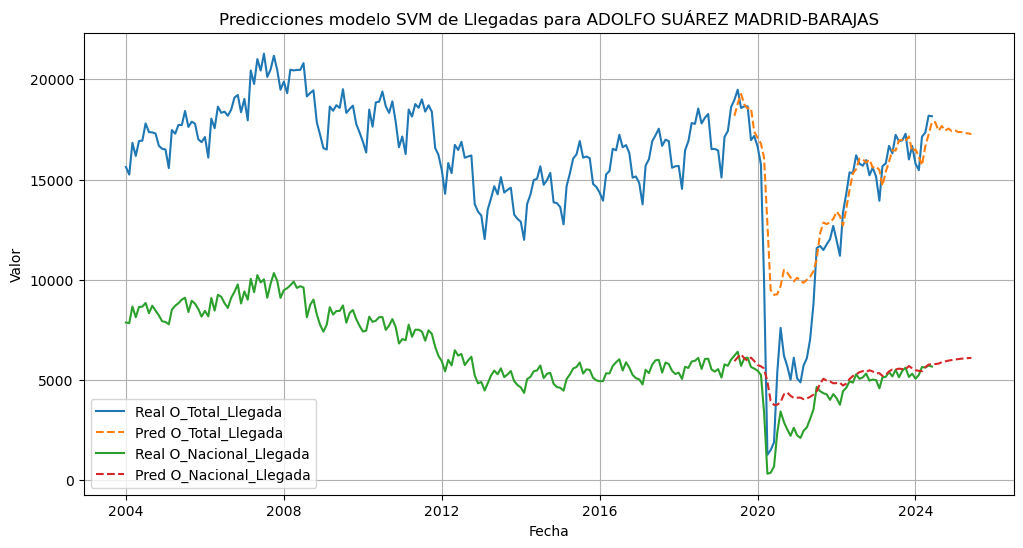

In [11]:
# Se visualizan las predicciones para un aeropuerto específico
Aeropuerto_Prediccion = 'ADOLFO SUÁREZ MADRID-BARAJAS'

# Se filtran los tipos de operación disponibles para el aeropuerto seleccionado
Tipos_Operacion = Operaciones_Unico[Operaciones_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion]['Tipo'].unique()

# Se filtran los tipos de operación para Llegada
Tipos_Llegada = [tipo for tipo in Tipos_Operacion if 'Llegada' in tipo]


# Gráfico para operaciones de Llegada
plt.figure(figsize=(12, 6))
for Tipo_Operacion_Prediccion in Tipos_Llegada:
    # Se filtran los datos reales para el tipo de operación
    Datos_Reales_Operacion_SVM = Operaciones_Unico[(Operaciones_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                               (Operaciones_Unico['Tipo'] == Tipo_Operacion_Prediccion)]
    
    # Se filtran las predicciones para el tipo de operación
    Datos_Predicciones_Operacion_SVM = Predicciones_Operaciones_SVM[(Predicciones_Operaciones_SVM['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                                            (Predicciones_Operaciones_SVM['Tipo'] == Tipo_Operacion_Prediccion)]
    
    # Se añaden las series reales y predicciones al gráfico
    plt.plot(Datos_Reales_Operacion_SVM.index, Datos_Reales_Operacion_SVM['Valor'], label=f'Real {Tipo_Operacion_Prediccion}')
    plt.plot(Datos_Predicciones_Operacion_SVM['Fecha'], Datos_Predicciones_Operacion_SVM['Prediccion'], linestyle='--', label=f'Pred {Tipo_Operacion_Prediccion}')

# Se configura el gráfico
plt.title(f'Predicciones modelo SVM de Llegadas para {Aeropuerto_Prediccion}')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

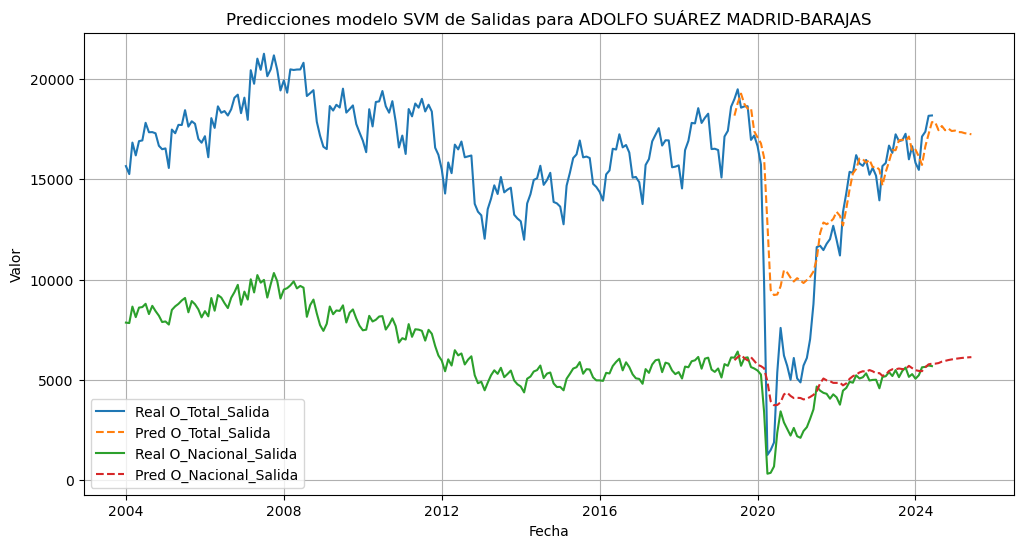

In [12]:
# Se visualizan las predicciones para un aeropuerto específico
Aeropuerto_Prediccion = 'ADOLFO SUÁREZ MADRID-BARAJAS'

# Se filtran los tipos de operación disponibles para el aeropuerto seleccionado
Tipos_Operacion = Operaciones_Unico[Operaciones_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion]['Tipo'].unique()

# Se filtran los tipos de operación para Salida
Tipos_Salida = [tipo for tipo in Tipos_Operacion if 'Salida' in tipo]


# Gráfico para operaciones de Salida
plt.figure(figsize=(12, 6))
for Tipo_Operacion_Prediccion in Tipos_Salida:
    # Se filtran los datos reales para el tipo de operación
    Datos_Reales_Operacion_SVM = Operaciones_Unico[(Operaciones_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                               (Operaciones_Unico['Tipo'] == Tipo_Operacion_Prediccion)]
    
    # Se filtran las predicciones para el tipo de operación
    Datos_Predicciones_Operacion_SVM = Predicciones_Operaciones_SVM[(Predicciones_Operaciones_SVM['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                                            (Predicciones_Operaciones_SVM['Tipo'] == Tipo_Operacion_Prediccion)]
    
    # Se añaden las series reales y predicciones al gráfico
    plt.plot(Datos_Reales_Operacion_SVM.index, Datos_Reales_Operacion_SVM['Valor'], label=f'Real {Tipo_Operacion_Prediccion}')
    plt.plot(Datos_Predicciones_Operacion_SVM['Fecha'], Datos_Predicciones_Operacion_SVM['Prediccion'], linestyle='--', label=f'Pred {Tipo_Operacion_Prediccion}')

# Se configura el gráfico
plt.title(f'Predicciones modelo SVM de Salidas para {Aeropuerto_Prediccion}')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

**14-c. Métricas de error**

In [13]:
# Se crea un DataFrame para almacenar las métricas de error
Metricas_Error_Operaciones_SVM = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'MAE', 'RMSE', 'MAPE'])

# Se itera sobre las combinaciones de aeropuerto y tipo de operación
for (Aeropuerto, Operacion), (Predicciones_Originales_SVM, _, Fechas_Reales) in Dicc_Predicciones_Operaciones_SVM.items():
    # Se obtienen los valores reales
    Valores_Reales_Operacion_SVM = Operaciones_Unico[(Operaciones_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                       (Operaciones_Unico['Tipo'] == Operacion)]['Valor'][-len(Predicciones_Originales_SVM):]

     # Se calculan las métricas de error si hay valores reales para comparar
    if len(Valores_Reales_Operacion_SVM) == len(Predicciones_Originales_SVM):
        # MAE - Error Absoluto Medio
        mae = mean_absolute_error(Valores_Reales_Operacion_SVM, Predicciones_Originales_SVM)
        # RMSE - Error Cuatrático Medio
        rmse = np.sqrt(mean_squared_error(Valores_Reales_Operacion_SVM, Predicciones_Originales_SVM))
        # MAPE - Error Porcentual Absoluto Medio
        mape = np.mean(np.abs((Valores_Reales_Operacion_SVM - Predicciones_Originales_SVM) / Valores_Reales_Operacion_SVM)) * 100

        # Se almacenan las métricas en el DataFrame
        Temp_Metricas_Error_SVM = pd.DataFrame({
            'Aeropuerto_Base': [Aeropuerto],
            'Tipo': [Operacion],
            'MAE': [mae],
            'RMSE': [rmse],
            'MAPE': [mape]
        })
       
        # Se concatenan las métricas de error
        Metricas_Error_Operaciones_SVM = pd.concat([Metricas_Error_Operaciones_SVM, Temp_Metricas_Error_SVM], ignore_index=True) 
    else:
        print(f"Las longitudes no coinciden para {Aeropuerto} - {Operacion}")

# Se muestran las métricas
print(Metricas_Error_Operaciones_SVM)

                  Aeropuerto_Base                Tipo          MAE  \
0                        A CORUÑA     O_Total_Llegada    78.334732   
1                        A CORUÑA  O_Nacional_Llegada    71.463520   
2                        A CORUÑA      O_Total_Salida    76.853476   
3                        A CORUÑA   O_Nacional_Salida    71.185360   
4    ADOLFO SUÁREZ MADRID-BARAJAS     O_Total_Llegada  1800.523759   
..                            ...                 ...          ...   
191         ALGECIRAS /HELIPUERTO   O_Nacional_Salida    33.273370   
192              MURCIA COMBINADO     O_Total_Llegada   142.349963   
193              MURCIA COMBINADO  O_Nacional_Llegada    20.968959   
194              MURCIA COMBINADO      O_Total_Salida   141.497080   
195              MURCIA COMBINADO   O_Nacional_Salida    19.538249   

            RMSE        MAPE  
0     109.161690   30.520734  
1      99.455287   29.386253  
2     107.438617   30.003250  
3      99.102447   29.383777  
4   

**14-d. Métricas de error promedias de todo el conjunto**

In [14]:
# Se calculan las métricas medias para este modelo 
MAE_promedio_SVM = Metricas_Error_Operaciones_SVM['MAE'].mean()
RMSE_promedio_SVM = Metricas_Error_Operaciones_SVM['RMSE'].mean()
MAPE_promedio_SVM = Metricas_Error_Operaciones_SVM['MAPE'].mean()

# Se muestran los resultados SVM
print(f"MAE Promedio SVM: {MAE_promedio_SVM}")
print(f"RMSE Promedio SVM: {RMSE_promedio_SVM}")
print(f"MAPE Promedio SVM: {MAPE_promedio_SVM}%")

MAE Promedio SVM: 263.92489019057
RMSE Promedio SVM: 355.4910112386203
MAPE Promedio SVM: inf%


Este modelo tampoco ha mejorado respecto al modelo de ML anterior ni tampoco respecto al de Holt Winters Aditivo

Por lo que después de haber probado 14 modelos y no conseguir que mejora, se determina que el mejor modelo que en conjunto funciona para los datos de Operaciones es el **modelo de Holt-Winters Aditivo**

### C. Visualizar mejor modelo

In [10]:
# Se crea un DataFrame para almacenar todas las predicciones
Predicciones_Operaciones_HWA = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'Fecha', 'Prediccion'])

for (Aeropuerto, Operacion), (Predicciones_Originales_HWA, Predicciones_Futuras_HWA, Fechas_Reales) in Dicc_Predicciones_HoltWinters_AD.items():
    # Se guardan en un DataFrame temporal para las predicciones de los datos orginales "reales"
    Tem_Predicciones_Historicas_HWA = pd.DataFrame({
        'Aeropuerto_Base': Aeropuerto,
        'Tipo': Operacion,
        'Fecha': Fechas_Reales,
        'Prediccion': Predicciones_Originales_HWA
    })

    # Se guardan en un DataFrame temporal para las predicciones de fechas futuras
    Fechas_Futuras = pd.date_range(start=Fechas_Reales[-1] + pd.offsets.MonthBegin(1), periods=len(Predicciones_Futuras_HWA), freq='MS')
    Temp_Predicciones_Futuras_HWA = pd.DataFrame({
        'Aeropuerto_Base': Aeropuerto,
        'Tipo': Operacion,
        'Fecha': Fechas_Futuras,
        'Prediccion': Predicciones_Futuras_HWA
    })

    # Se concatenan ambas predicciones y se guardan en un dataframe único
    Predicciones_Operaciones_HWA = pd.concat([Predicciones_Operaciones_HWA, Tem_Predicciones_Historicas_HWA, Temp_Predicciones_Futuras_HWA], ignore_index=True)

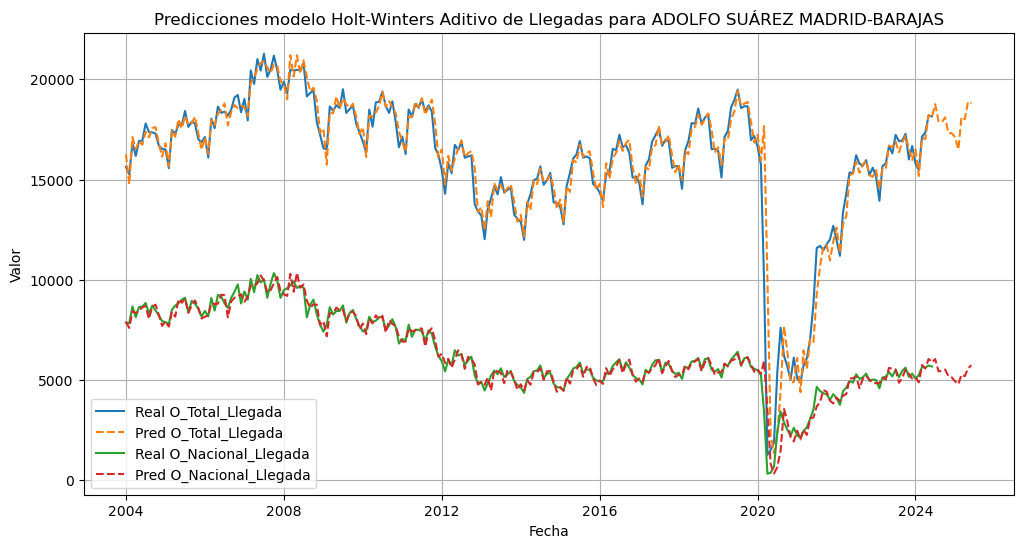

In [11]:
# Se visualizan las predicciones para un aeropuerto específico
Aeropuerto_Prediccion = 'ADOLFO SUÁREZ MADRID-BARAJAS'

# Se filtran los tipos de operación disponibles para el aeropuerto seleccionado
Tipos_Operacion = Operaciones_Unico[Operaciones_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion]['Tipo'].unique()

# Se filtran los tipos de operación para Llegada
Tipos_Llegada = [tipo for tipo in Tipos_Operacion if 'Llegada' in tipo]


# Gráfico para operaciones de Llegada
plt.figure(figsize=(12, 6))
for Tipo_Operacion_Prediccion in Tipos_Llegada:
    # Se filtran los datos reales para el tipo de operación
    Datos_Reales_Operacion_HW_AD = Operaciones_Unico[(Operaciones_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                               (Operaciones_Unico['Tipo'] == Tipo_Operacion_Prediccion)]
    
    # Se filtran las predicciones para el tipo de operación
    Datos_Predicciones_Operacion_HW_AD = Predicciones_Operaciones_HWA[(Predicciones_Operaciones_HWA['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                                            (Predicciones_Operaciones_HWA['Tipo'] == Tipo_Operacion_Prediccion)]
    
    # Se añaden las series reales y predicciones al gráfico
    plt.plot(Datos_Reales_Operacion_HW_AD.index, Datos_Reales_Operacion_HW_AD['Valor'], label=f'Real {Tipo_Operacion_Prediccion}')
    plt.plot(Datos_Predicciones_Operacion_HW_AD['Fecha'], Datos_Predicciones_Operacion_HW_AD['Prediccion'], linestyle='--', label=f'Pred {Tipo_Operacion_Prediccion}')

# Se configura el gráfico
plt.title(f'Predicciones modelo Holt-Winters Aditivo de Llegadas para {Aeropuerto_Prediccion}')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

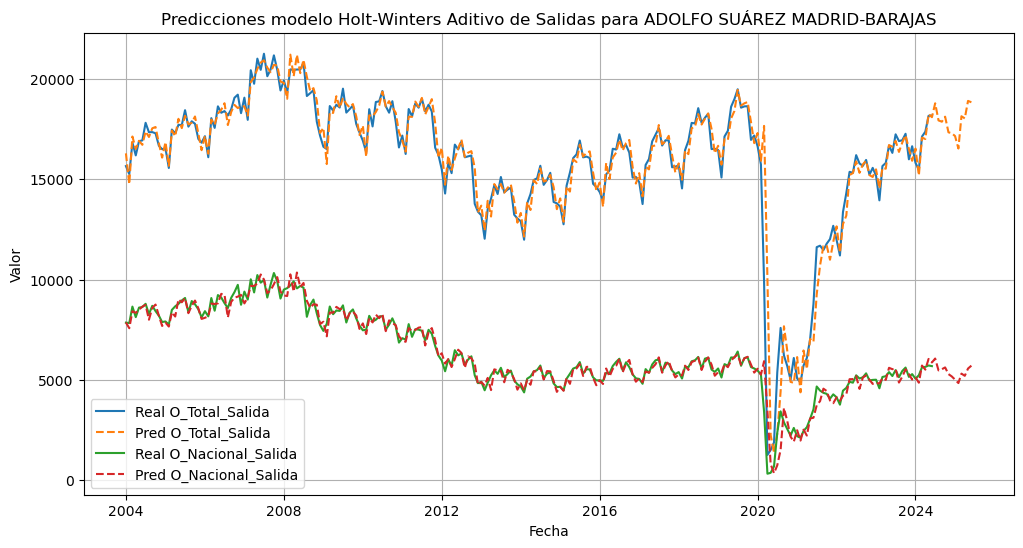

In [12]:
# Se visualizan las predicciones para un aeropuerto específico
Aeropuerto_Prediccion = 'ADOLFO SUÁREZ MADRID-BARAJAS'

# Se filtran los tipos de operación disponibles para el aeropuerto seleccionado
Tipos_Operacion = Operaciones_Unico[Operaciones_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion]['Tipo'].unique()

# Se filtran los tipos de operación para salida
Tipos_Salida = [tipo for tipo in Tipos_Operacion if 'Salida' in tipo]

# Gráfico para operaciones de Salida
plt.figure(figsize=(12, 6))
for Tipo_Operacion_Prediccion in Tipos_Salida:
    # Se filtran los datos reales para el tipo de operación
    Datos_reales_Operacion = Operaciones_Unico[(Operaciones_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                               (Operaciones_Unico['Tipo'] == Tipo_Operacion_Prediccion)]
    
    # Se filtran las predicciones para el tipo de operación
    Datos_Predicciones_Operacion = Predicciones_Operaciones_HWA[(Predicciones_Operaciones_HWA['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                                            (Predicciones_Operaciones_HWA['Tipo'] == Tipo_Operacion_Prediccion)]
    
    # Se añaden las series reales y predicciones al gráfico
    plt.plot(Datos_reales_Operacion.index, Datos_reales_Operacion['Valor'], label=f'Real {Tipo_Operacion_Prediccion}')
    plt.plot(Datos_Predicciones_Operacion['Fecha'], Datos_Predicciones_Operacion['Prediccion'], linestyle='--', label=f'Pred {Tipo_Operacion_Prediccion}')

# Se configura el gráfico
plt.title(f'Predicciones modelo Holt-Winters Aditivo de Salidas para {Aeropuerto_Prediccion}')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

### D. Guardar mejor modelo

In [13]:
# Se guardan los parámetros del modelo para cada aeropuerto y operación
for (Aeropuerto, Operacion), model_fit_hw_AD in Dicc_Predicciones_HoltWinters_AD.items():
     # Se limpian los nombres de archivos para que sean válidos
    nombre_aeropuerto = re.sub(r'[^\w\s]', '_', Aeropuerto)  # Reemplaza caracteres no alfanuméricos con guion bajo
    nombre_operacion = re.sub(r'[^\w\s]', '_', Operacion)
    
    # Se guarda el modelo usando joblib
    try:
        joblib.dump(model_fit_hw_AD, f'modelo_holt_winters_{nombre_aeropuerto}_{nombre_operacion}.pkl')
    except Exception as e:
        print(f"Error al guardar el modelo para {Aeropuerto}, {Operacion}: {e}")

### E. Guardar predicciones

In [14]:
# Se especifica la ruta en la que se van a guardar el dataframe
Ruta_Operaciones_Prediccion = './Ficheros_Predicciones'

# Se crea la carpeta en la que se van a guardar, si esta no existe
if not os.path.exists(Ruta_Operaciones_Prediccion):
    # Si la carpeta no existe, se crea
    os.makedirs(Ruta_Operaciones_Prediccion)
    print(f"Carpeta creada: {Ruta_Operaciones_Prediccion}")
else:
    # Si la carpeta ya existe, se muestra un mensaje
    print(f"La carpeta ya existe: {Ruta_Operaciones_Prediccion}")

La carpeta ya existe: ./Ficheros_Predicciones


In [15]:
# Ruta para guardar las predicciones
Ruta_Operaciones_Prediccion = './Ficheros_Predicciones/Predicciones_Operaciones.csv'

# Se reemplazan las comas por puntos en la columna 'Prediccion'
Comparacion_Total_Todos_Aeropuertos_HWA_O['Prediccion'] = Comparacion_Total_Todos_Aeropuertos_HWA_O['Prediccion'].str.replace(',', '.')

# Se convierte la columna 'Prediccion' a float
Comparacion_Total_Todos_Aeropuertos_HWA_O['Prediccion'] = Comparacion_Total_Todos_Aeropuertos_HWA_O['Prediccion'].astype(float)

# Se guarda el DataFrame en un archivo CSV con el formato correcto para los flotantes
Comparacion_Total_Todos_Aeropuertos_HWA_O.to_csv(Ruta_Operaciones_Prediccion, index=False, encoding='utf-8', decimal=',')

print(f"Predicciones de operaciones guardadas en: {Ruta_Operaciones_Prediccion}")

Predicciones de operaciones guardadas en: ./Ficheros_Predicciones/Predicciones_Operaciones.csv
